In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
from tqdm import tqdm

In [ ]:
import sys
!{sys.executable} -m pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import (ElectraForSequenceClassification, ElectraTokenizerFast)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [ ]:
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')
%cd drive/MyDrive/twitter_training/

In [ ]:
df = pd.read_csv('./p_n_n_tilde_lv.csv')
df = df[['id', 'message_lv_tilde', 'label']]
df.head()

,id,message_lv_tilde,label
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2


In [ ]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message_lv_tilde']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message_lv_tilde,label,clean_message
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,MENTION MENTION MENTION pa reizei tādu nav bij...
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"MENTION Es nojaušu, ka WWE lika viņam iznākt a..."
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...


# Train, validate split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message_lv_tilde  clean_message
label data_type                                        
0     train      65474             65474          65474
      val        11554             11554          11554
1     train      44195             44195          44195
      val         7799              7799           7799
2     train      38778             38778          38778
      val         6844              6844           6844

## Balance training data

In [ ]:
label_dict = {'neutral': 0, 'positive': 1, 'negative': 2}
df['label'] = df.label.replace(label_dict) 
df['label'].value_counts()

df[df.data_type=='train'].head()

In [ ]:
df[df.data_type=='train']['label'].value_counts()

In [ ]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_2.shape[0], random_state=42)
df_1_downsampled = df_1.sample(df_2.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_1_downsampled, df_2])

df_train['label'].value_counts()

0    38778
1    38778
2    38778
Name: label, dtype: int64

In [ ]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
173549,Negadījums. divas labās joslas bloķētas TriSta...,0
13774,"labākais, ko ab ir pilnībā ielenkusi tukši dzī...",2
86302,"Piemērojot to visu šajā nākamajā nodaļā, uzspi...",1
77847,"MENTION Es cerēju, ka jūs galu galā izdarīsiet...",1
14670,"MENTION MENTION MENTION MENTION MENTION Jā, mē...",2


# Tokenizer "google/electra-small-discriminator"

In [ ]:
tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-small-discriminator", do_lower_case=True) 

## Find popular UNK tokens

In [ ]:
unk_tokens = []
for message in df.clean_message.values:
    list_of_space_separated_pieces = message.strip().split()
    ids = [tokenizer(piece, add_special_tokens=False, max_length=1009)["input_ids"] for piece in list_of_space_separated_pieces]
    unk_indices = [i for i, encoded in enumerate(ids) if tokenizer.unk_token_id in encoded]
    unknown_strings = [piece for i, piece in enumerate(list_of_space_separated_pieces) if i in unk_indices]
    for unk_str in unknown_strings:
        unk_tokens.append(unk_str)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
import collections

counter=collections.Counter(unk_tokens)
print(counter.most_common(100))

most_common_values= [word for word, word_count in counter.most_common(100)]
most_common_values

[('😂', 6584), ('😭', 4354), ('🤣', 2423), ('❤', 2236), ('🏾', 2207), ('🏽', 1932), ('🙏', 1883), ('♂', 1521), ('♀', 1299), ('🔥', 1249), ('🏻', 1242), ('✨', 1213), ('🏼', 1209), ('🤷', 1165), ('🤦', 1025), ('🥺', 1018), ('😩', 993), ('🥰', 869), ('🤔', 846), ('🥴', 823), ('👏', 820), ('💯', 816), ('😍', 789), ('🙄', 718), ('🇺', 670), ('🙌', 664), ('💙', 623), ('🇸', 612), ('💀', 573), ('👀', 561), ('😅', 530), ('💜', 527), ('💕', 519), ('😊', 482), ('👍', 455), ('💪', 454), ('😘', 445), ('😔', 428), ('💔', 422), ('😒', 417), ('🚨', 412), ('🙃', 403), ('🏿', 390), ('🚀', 387), ('😎', 377), ('‼', 375), ('😉', 361), ('🎄', 356), ('😁', 351), ('🖤', 335), ('😌', 332), ('😢', 328), ('🎶', 317), ('🎉', 307), ('🤗', 300), ('😆', 295), ('✊', 282), ('✌', 280), ('💛', 279), ('🥳', 278), ('\U0001f972', 277), ('😤', 276), ('😳', 275), ('🌟', 274), ('🤬', 267), ('👌', 261), ('👇', 261), ('🤩', 257), ('😬', 256), ('💖', 253), ('😡', 249), ('☺', 245), ('💋', 244), ('🌹', 244), ('⠀', 243), ('🤍', 242), ('🗣', 240), ('😫', 238), ('💚', 226), ('❄', 219), ('💗', 207), ('

['😂',
 '😭',
 '🤣',
 '❤',
 '🏾',
 '🏽',
 '🙏',
 '♂',
 '♀',
 '🔥',
 '🏻',
 '✨',
 '🏼',
 '🤷',
 '🤦',
 '🥺',
 '😩',
 '🥰',
 '🤔',
 '🥴',
 '👏',
 '💯',
 '😍',
 '🙄',
 '🇺',
 '🙌',
 '💙',
 '🇸',
 '💀',
 '👀',
 '😅',
 '💜',
 '💕',
 '😊',
 '👍',
 '💪',
 '😘',
 '😔',
 '💔',
 '😒',
 '🚨',
 '🙃',
 '🏿',
 '🚀',
 '😎',
 '‼',
 '😉',
 '🎄',
 '😁',
 '🖤',
 '😌',
 '😢',
 '🎶',
 '🎉',
 '🤗',
 '😆',
 '✊',
 '✌',
 '💛',
 '🥳',
 '\U0001f972',
 '😤',
 '😳',
 '🌟',
 '🤬',
 '👌',
 '👇',
 '🤩',
 '😬',
 '💖',
 '😡',
 '☺',
 '💋',
 '🌹',
 '⠀',
 '🤍',
 '🗣',
 '😫',
 '💚',
 '❄',
 '💗',
 '😈',
 '🙂',
 '😞',
 '😂,',
 '😷',
 '🇷',
 '🤯',
 '😀',
 '⃣',
 '💰',
 '😭,',
 '😴',
 '😏',
 '🤞',
 '😋',
 '🎁',
 '💫',
 '😜',
 '👉']

In [ ]:
len(tokenizer)

In [ ]:
tokenizer.add_tokens(most_common_values, special_tokens=True)

100

In [ ]:
len(tokenizer)

### Find max length for tokenizer

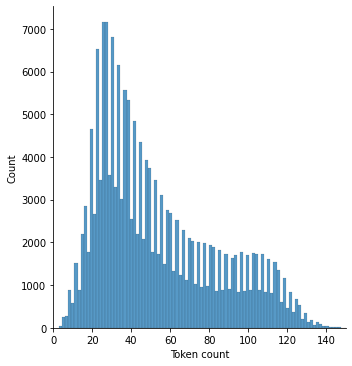

In [ ]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 150])
plt.xlabel('Token count')
plt.show()

In [ ]:
max_length = 160

### Encode messages

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
len(dataset_train), len(dataset_val)

(116334, 26197)

# Model "google/electra-small-discriminator"

In [ ]:
model = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels = 3)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(30622, 128)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [ ]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [ ]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating:', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsUNK-pnn/finetuned_ELECTRA_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))
    print('--------------------------------------------------------------')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:02<?, ?it/s, training_loss=0.367]

Epoch 1:   0%|          | 1/3636 [00:02<2:52:21,  2.84s/it, training_loss=0.367]

Epoch 1:   0%|          | 1/3636 [00:05<2:52:21,  2.84s/it, training_loss=0.367]

Epoch 1:   0%|          | 2/3636 [00:05<2:43:30,  2.70s/it, training_loss=0.367]

Epoch 1:   0%|          | 2/3636 [00:07<2:43:30,  2.70s/it, training_loss=0.368]

Epoch 1:   0%|          | 3/3636 [00:07<2:35:14,  2.56s/it, training_loss=0.368]

Epoch 1:   0%|          | 3/3636 [00:10<2:35:14,  2.56s/it, training_loss=0.368]

Epoch 1:   0%|          | 4/3636 [00:10<2:35:43,  2.57s/it, training_loss=0.368]

Epoch 1:   0%|          | 4/3636 [00:12<2:35:43,  2.57s/it, training_loss=0.364]

Epoch 1:   0%|          | 5/3636 [00:12<2:32:02,  2.51s/it, training_loss=0.364]

Epoch 1:   0%|          | 5/3636 [00:15<2:32:02,  2.51s/it, training_loss=0.361]

Epoch 1:   0%|          | 6/3636 [00:15<2:29:22,  2.47s/it, training_loss=0.361]

Epoch 1:   0%|          | 6/3636 [00:18<2:29:22,  2.47s/it, training_loss=0.367]

Epoch 1:   0%|          | 7/3636 [00:18<2:36:25,  2.59s/it, training_loss=0.367]

Epoch 1:   0%|          | 7/3636 [00:21<2:36:25,  2.59s/it, training_loss=0.368]

Epoch 1:   0%|          | 8/3636 [00:21<2:43:30,  2.70s/it, training_loss=0.368]

Epoch 1:   0%|          | 8/3636 [00:23<2:43:30,  2.70s/it, training_loss=0.366]

Epoch 1:   0%|          | 9/3636 [00:23<2:40:08,  2.65s/it, training_loss=0.366]

Epoch 1:   0%|          | 9/3636 [00:26<2:40:08,  2.65s/it, training_loss=0.366]

Epoch 1:   0%|          | 10/3636 [00:26<2:42:33,  2.69s/it, training_loss=0.366]

Epoch 1:   0%|          | 10/3636 [00:28<2:42:33,  2.69s/it, training_loss=0.364]

Epoch 1:   0%|          | 11/3636 [00:28<2:40:59,  2.66s/it, training_loss=0.364]

Epoch 1:   0%|          | 11/3636 [00:31<2:40:59,  2.66s/it, training_loss=0.369]

Epoch 1:   0%|          | 12/3636 [00:31<2:41:31,  2.67s/it, training_loss=0.369]

Epoch 1:   0%|          | 12/3636 [00:33<2:41:31,  2.67s/it, training_loss=0.368]

Epoch 1:   0%|          | 13/3636 [00:33<2:33:28,  2.54s/it, training_loss=0.368]

Epoch 1:   0%|          | 13/3636 [00:36<2:33:28,  2.54s/it, training_loss=0.369]

Epoch 1:   0%|          | 14/3636 [00:36<2:32:36,  2.53s/it, training_loss=0.369]

Epoch 1:   0%|          | 14/3636 [00:38<2:32:36,  2.53s/it, training_loss=0.369]

Epoch 1:   0%|          | 15/3636 [00:38<2:31:18,  2.51s/it, training_loss=0.369]

Epoch 1:   0%|          | 15/3636 [00:41<2:31:18,  2.51s/it, training_loss=0.366]

Epoch 1:   0%|          | 16/3636 [00:41<2:30:04,  2.49s/it, training_loss=0.366]

Epoch 1:   0%|          | 16/3636 [00:43<2:30:04,  2.49s/it, training_loss=0.366]

Epoch 1:   0%|          | 17/3636 [00:43<2:29:32,  2.48s/it, training_loss=0.366]

Epoch 1:   0%|          | 17/3636 [00:46<2:29:32,  2.48s/it, training_loss=0.366]

Epoch 1:   0%|          | 18/3636 [00:46<2:28:55,  2.47s/it, training_loss=0.366]

Epoch 1:   0%|          | 18/3636 [00:49<2:28:55,  2.47s/it, training_loss=0.367]

Epoch 1:   1%|          | 19/3636 [00:49<2:36:14,  2.59s/it, training_loss=0.367]

Epoch 1:   1%|          | 19/3636 [00:51<2:36:14,  2.59s/it, training_loss=0.367]

Epoch 1:   1%|          | 20/3636 [00:51<2:35:13,  2.58s/it, training_loss=0.367]

Epoch 1:   1%|          | 20/3636 [00:53<2:35:13,  2.58s/it, training_loss=0.367]

Epoch 1:   1%|          | 21/3636 [00:53<2:25:46,  2.42s/it, training_loss=0.367]

Epoch 1:   1%|          | 21/3636 [00:56<2:25:46,  2.42s/it, training_loss=0.364]

Epoch 1:   1%|          | 22/3636 [00:56<2:27:23,  2.45s/it, training_loss=0.364]

Epoch 1:   1%|          | 22/3636 [00:58<2:27:23,  2.45s/it, training_loss=0.364]

Epoch 1:   1%|          | 23/3636 [00:58<2:27:01,  2.44s/it, training_loss=0.364]

Epoch 1:   1%|          | 23/3636 [01:01<2:27:01,  2.44s/it, training_loss=0.366]

Epoch 1:   1%|          | 24/3636 [01:01<2:34:25,  2.57s/it, training_loss=0.366]

Epoch 1:   1%|          | 24/3636 [01:03<2:34:25,  2.57s/it, training_loss=0.366]

Epoch 1:   1%|          | 25/3636 [01:03<2:28:06,  2.46s/it, training_loss=0.366]

Epoch 1:   1%|          | 25/3636 [01:06<2:28:06,  2.46s/it, training_loss=0.366]

Epoch 1:   1%|          | 26/3636 [01:06<2:27:29,  2.45s/it, training_loss=0.366]

Epoch 1:   1%|          | 26/3636 [01:08<2:27:29,  2.45s/it, training_loss=0.367]

Epoch 1:   1%|          | 27/3636 [01:08<2:25:44,  2.42s/it, training_loss=0.367]

Epoch 1:   1%|          | 27/3636 [01:11<2:25:44,  2.42s/it, training_loss=0.365]

Epoch 1:   1%|          | 28/3636 [01:11<2:32:21,  2.53s/it, training_loss=0.365]

Epoch 1:   1%|          | 28/3636 [01:13<2:32:21,  2.53s/it, training_loss=0.366]

Epoch 1:   1%|          | 29/3636 [01:13<2:29:36,  2.49s/it, training_loss=0.366]

Epoch 1:   1%|          | 29/3636 [01:15<2:29:36,  2.49s/it, training_loss=0.365]

Epoch 1:   1%|          | 30/3636 [01:15<2:24:36,  2.41s/it, training_loss=0.365]

Epoch 1:   1%|          | 30/3636 [01:17<2:24:36,  2.41s/it, training_loss=0.362]

Epoch 1:   1%|          | 31/3636 [01:17<2:17:11,  2.28s/it, training_loss=0.362]

Epoch 1:   1%|          | 31/3636 [01:20<2:17:11,  2.28s/it, training_loss=0.366]

Epoch 1:   1%|          | 32/3636 [01:20<2:19:24,  2.32s/it, training_loss=0.366]

Epoch 1:   1%|          | 32/3636 [01:22<2:19:24,  2.32s/it, training_loss=0.366]

Epoch 1:   1%|          | 33/3636 [01:22<2:24:55,  2.41s/it, training_loss=0.366]

Epoch 1:   1%|          | 33/3636 [01:25<2:24:55,  2.41s/it, training_loss=0.366]

Epoch 1:   1%|          | 34/3636 [01:25<2:27:25,  2.46s/it, training_loss=0.366]

Epoch 1:   1%|          | 34/3636 [01:27<2:27:25,  2.46s/it, training_loss=0.365]

Epoch 1:   1%|          | 35/3636 [01:27<2:28:40,  2.48s/it, training_loss=0.365]

Epoch 1:   1%|          | 35/3636 [01:30<2:28:40,  2.48s/it, training_loss=0.364]

Epoch 1:   1%|          | 36/3636 [01:30<2:31:19,  2.52s/it, training_loss=0.364]

Epoch 1:   1%|          | 36/3636 [01:33<2:31:19,  2.52s/it, training_loss=0.363]

Epoch 1:   1%|          | 37/3636 [01:33<2:30:49,  2.51s/it, training_loss=0.363]

Epoch 1:   1%|          | 37/3636 [01:35<2:30:49,  2.51s/it, training_loss=0.366]

Epoch 1:   1%|          | 38/3636 [01:35<2:32:08,  2.54s/it, training_loss=0.366]

Epoch 1:   1%|          | 38/3636 [01:38<2:32:08,  2.54s/it, training_loss=0.367]

Epoch 1:   1%|          | 39/3636 [01:38<2:29:41,  2.50s/it, training_loss=0.367]

Epoch 1:   1%|          | 39/3636 [01:40<2:29:41,  2.50s/it, training_loss=0.364]

Epoch 1:   1%|          | 40/3636 [01:40<2:29:25,  2.49s/it, training_loss=0.364]

Epoch 1:   1%|          | 40/3636 [01:43<2:29:25,  2.49s/it, training_loss=0.365]

Epoch 1:   1%|          | 41/3636 [01:43<2:29:25,  2.49s/it, training_loss=0.365]

Epoch 1:   1%|          | 41/3636 [01:45<2:29:25,  2.49s/it, training_loss=0.365]

Epoch 1:   1%|          | 42/3636 [01:45<2:31:13,  2.52s/it, training_loss=0.365]

Epoch 1:   1%|          | 42/3636 [01:47<2:31:13,  2.52s/it, training_loss=0.366]

Epoch 1:   1%|          | 43/3636 [01:47<2:27:41,  2.47s/it, training_loss=0.366]

Epoch 1:   1%|          | 43/3636 [01:50<2:27:41,  2.47s/it, training_loss=0.366]

Epoch 1:   1%|          | 44/3636 [01:50<2:33:52,  2.57s/it, training_loss=0.366]

Epoch 1:   1%|          | 44/3636 [01:53<2:33:52,  2.57s/it, training_loss=0.366]

Epoch 1:   1%|          | 45/3636 [01:53<2:30:39,  2.52s/it, training_loss=0.366]

Epoch 1:   1%|          | 45/3636 [01:55<2:30:39,  2.52s/it, training_loss=0.363]

Epoch 1:   1%|▏         | 46/3636 [01:55<2:29:27,  2.50s/it, training_loss=0.363]

Epoch 1:   1%|▏         | 46/3636 [01:58<2:29:27,  2.50s/it, training_loss=0.363]

Epoch 1:   1%|▏         | 47/3636 [01:58<2:29:52,  2.51s/it, training_loss=0.363]

Epoch 1:   1%|▏         | 47/3636 [02:00<2:29:52,  2.51s/it, training_loss=0.365]

Epoch 1:   1%|▏         | 48/3636 [02:00<2:32:46,  2.55s/it, training_loss=0.365]

Epoch 1:   1%|▏         | 48/3636 [02:03<2:32:46,  2.55s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 49/3636 [02:03<2:29:57,  2.51s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 49/3636 [02:05<2:29:57,  2.51s/it, training_loss=0.369]

Epoch 1:   1%|▏         | 50/3636 [02:05<2:27:02,  2.46s/it, training_loss=0.369]

Epoch 1:   1%|▏         | 50/3636 [02:07<2:27:02,  2.46s/it, training_loss=0.365]

Epoch 1:   1%|▏         | 51/3636 [02:07<2:25:58,  2.44s/it, training_loss=0.365]

Epoch 1:   1%|▏         | 51/3636 [02:10<2:25:58,  2.44s/it, training_loss=0.363]

Epoch 1:   1%|▏         | 52/3636 [02:10<2:24:50,  2.42s/it, training_loss=0.363]

Epoch 1:   1%|▏         | 52/3636 [02:12<2:24:50,  2.42s/it, training_loss=0.363]

Epoch 1:   1%|▏         | 53/3636 [02:12<2:24:08,  2.41s/it, training_loss=0.363]

Epoch 1:   1%|▏         | 53/3636 [02:15<2:24:08,  2.41s/it, training_loss=0.365]

Epoch 1:   1%|▏         | 54/3636 [02:15<2:24:10,  2.42s/it, training_loss=0.365]

Epoch 1:   1%|▏         | 54/3636 [02:17<2:24:10,  2.42s/it, training_loss=0.359]

Epoch 1:   2%|▏         | 55/3636 [02:17<2:30:19,  2.52s/it, training_loss=0.359]

Epoch 1:   2%|▏         | 55/3636 [02:20<2:30:19,  2.52s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 56/3636 [02:20<2:31:41,  2.54s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 56/3636 [02:23<2:31:41,  2.54s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 57/3636 [02:23<2:32:47,  2.56s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 57/3636 [02:25<2:32:47,  2.56s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 58/3636 [02:25<2:26:25,  2.46s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 58/3636 [02:27<2:26:25,  2.46s/it, training_loss=0.367]

Epoch 1:   2%|▏         | 59/3636 [02:27<2:29:19,  2.50s/it, training_loss=0.367]

Epoch 1:   2%|▏         | 59/3636 [02:30<2:29:19,  2.50s/it, training_loss=0.359]

Epoch 1:   2%|▏         | 60/3636 [02:30<2:31:22,  2.54s/it, training_loss=0.359]

Epoch 1:   2%|▏         | 60/3636 [02:33<2:31:22,  2.54s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 61/3636 [02:33<2:31:20,  2.54s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 61/3636 [02:35<2:31:20,  2.54s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 62/3636 [02:35<2:31:48,  2.55s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 62/3636 [02:37<2:31:48,  2.55s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 63/3636 [02:37<2:25:27,  2.44s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 63/3636 [02:40<2:25:27,  2.44s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 64/3636 [02:40<2:22:32,  2.39s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 64/3636 [02:42<2:22:32,  2.39s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 65/3636 [02:42<2:25:28,  2.44s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 65/3636 [02:45<2:25:28,  2.44s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 66/3636 [02:45<2:25:26,  2.44s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 66/3636 [02:47<2:25:26,  2.44s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 67/3636 [02:47<2:26:10,  2.46s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 67/3636 [02:50<2:26:10,  2.46s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 68/3636 [02:50<2:25:24,  2.45s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 68/3636 [02:52<2:25:24,  2.45s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 69/3636 [02:52<2:27:03,  2.47s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 69/3636 [02:54<2:27:03,  2.47s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 70/3636 [02:54<2:24:35,  2.43s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 70/3636 [02:57<2:24:35,  2.43s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 71/3636 [02:57<2:29:03,  2.51s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 71/3636 [02:59<2:29:03,  2.51s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 72/3636 [02:59<2:25:28,  2.45s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 72/3636 [03:02<2:25:28,  2.45s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 73/3636 [03:02<2:32:16,  2.56s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 73/3636 [03:05<2:32:16,  2.56s/it, training_loss=0.368]

Epoch 1:   2%|▏         | 74/3636 [03:05<2:28:51,  2.51s/it, training_loss=0.368]

Epoch 1:   2%|▏         | 74/3636 [03:07<2:28:51,  2.51s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 75/3636 [03:07<2:27:02,  2.48s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 75/3636 [03:10<2:27:02,  2.48s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 76/3636 [03:10<2:28:58,  2.51s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 76/3636 [03:12<2:28:58,  2.51s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 77/3636 [03:12<2:27:27,  2.49s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 77/3636 [03:15<2:27:27,  2.49s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 78/3636 [03:15<2:32:21,  2.57s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 78/3636 [03:17<2:32:21,  2.57s/it, training_loss=0.362]

Epoch 1:   2%|▏         | 79/3636 [03:17<2:30:34,  2.54s/it, training_loss=0.362]

Epoch 1:   2%|▏         | 79/3636 [03:20<2:30:34,  2.54s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 80/3636 [03:20<2:37:54,  2.66s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 80/3636 [03:23<2:37:54,  2.66s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 81/3636 [03:23<2:43:46,  2.76s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 81/3636 [03:26<2:43:46,  2.76s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 82/3636 [03:26<2:38:43,  2.68s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 82/3636 [03:28<2:38:43,  2.68s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 83/3636 [03:28<2:37:39,  2.66s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 83/3636 [03:31<2:37:39,  2.66s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 84/3636 [03:31<2:39:25,  2.69s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 84/3636 [03:34<2:39:25,  2.69s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 85/3636 [03:34<2:42:46,  2.75s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 85/3636 [03:37<2:42:46,  2.75s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 86/3636 [03:37<2:44:09,  2.77s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 86/3636 [03:39<2:44:09,  2.77s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 87/3636 [03:39<2:39:14,  2.69s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 87/3636 [03:42<2:39:14,  2.69s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 88/3636 [03:42<2:39:11,  2.69s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 88/3636 [03:45<2:39:11,  2.69s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 89/3636 [03:45<2:37:29,  2.66s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 89/3636 [03:47<2:37:29,  2.66s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 90/3636 [03:47<2:33:08,  2.59s/it, training_loss=0.364]

Epoch 1:   2%|▏         | 90/3636 [03:49<2:33:08,  2.59s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 91/3636 [03:49<2:26:30,  2.48s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 91/3636 [03:52<2:26:30,  2.48s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 92/3636 [03:52<2:27:58,  2.51s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 92/3636 [03:54<2:27:58,  2.51s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 93/3636 [03:54<2:30:08,  2.54s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 93/3636 [03:57<2:30:08,  2.54s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 94/3636 [03:57<2:34:42,  2.62s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 94/3636 [04:00<2:34:42,  2.62s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 95/3636 [04:00<2:43:00,  2.76s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 95/3636 [04:03<2:43:00,  2.76s/it, training_loss=0.361]

Epoch 1:   3%|▎         | 96/3636 [04:03<2:41:02,  2.73s/it, training_loss=0.361]

Epoch 1:   3%|▎         | 96/3636 [04:06<2:41:02,  2.73s/it, training_loss=0.365]

Epoch 1:   3%|▎         | 97/3636 [04:06<2:37:13,  2.67s/it, training_loss=0.365]

Epoch 1:   3%|▎         | 97/3636 [04:08<2:37:13,  2.67s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 98/3636 [04:08<2:34:42,  2.62s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 98/3636 [04:11<2:34:42,  2.62s/it, training_loss=0.361]

Epoch 1:   3%|▎         | 99/3636 [04:11<2:34:23,  2.62s/it, training_loss=0.361]

Epoch 1:   3%|▎         | 99/3636 [04:13<2:34:23,  2.62s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 100/3636 [04:13<2:34:04,  2.61s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 100/3636 [04:16<2:34:04,  2.61s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 101/3636 [04:16<2:31:57,  2.58s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 101/3636 [04:19<2:31:57,  2.58s/it, training_loss=0.360]

Epoch 1:   3%|▎         | 102/3636 [04:19<2:40:11,  2.72s/it, training_loss=0.360]

Epoch 1:   3%|▎         | 102/3636 [04:22<2:40:11,  2.72s/it, training_loss=0.367]

Epoch 1:   3%|▎         | 103/3636 [04:22<2:40:43,  2.73s/it, training_loss=0.367]

Epoch 1:   3%|▎         | 103/3636 [04:24<2:40:43,  2.73s/it, training_loss=0.367]

Epoch 1:   3%|▎         | 104/3636 [04:24<2:35:55,  2.65s/it, training_loss=0.367]

Epoch 1:   3%|▎         | 104/3636 [04:27<2:35:55,  2.65s/it, training_loss=0.360]

Epoch 1:   3%|▎         | 105/3636 [04:27<2:33:22,  2.61s/it, training_loss=0.360]

Epoch 1:   3%|▎         | 105/3636 [04:29<2:33:22,  2.61s/it, training_loss=0.370]

Epoch 1:   3%|▎         | 106/3636 [04:29<2:35:29,  2.64s/it, training_loss=0.370]

Epoch 1:   3%|▎         | 106/3636 [04:31<2:35:29,  2.64s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 107/3636 [04:31<2:27:46,  2.51s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 107/3636 [04:34<2:27:46,  2.51s/it, training_loss=0.361]

Epoch 1:   3%|▎         | 108/3636 [04:34<2:25:05,  2.47s/it, training_loss=0.361]

Epoch 1:   3%|▎         | 108/3636 [04:36<2:25:05,  2.47s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 109/3636 [04:36<2:24:37,  2.46s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 109/3636 [04:39<2:24:37,  2.46s/it, training_loss=0.369]

Epoch 1:   3%|▎         | 110/3636 [04:39<2:25:56,  2.48s/it, training_loss=0.369]

Epoch 1:   3%|▎         | 110/3636 [04:42<2:25:56,  2.48s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 111/3636 [04:42<2:30:04,  2.55s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 111/3636 [04:44<2:30:04,  2.55s/it, training_loss=0.362]

Epoch 1:   3%|▎         | 112/3636 [04:44<2:25:59,  2.49s/it, training_loss=0.362]

Epoch 1:   3%|▎         | 112/3636 [04:47<2:25:59,  2.49s/it, training_loss=0.370]

Epoch 1:   3%|▎         | 113/3636 [04:47<2:29:03,  2.54s/it, training_loss=0.370]

Epoch 1:   3%|▎         | 113/3636 [04:49<2:29:03,  2.54s/it, training_loss=0.365]

Epoch 1:   3%|▎         | 114/3636 [04:49<2:28:49,  2.54s/it, training_loss=0.365]

Epoch 1:   3%|▎         | 114/3636 [04:51<2:28:49,  2.54s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 115/3636 [04:51<2:26:23,  2.49s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 115/3636 [04:54<2:26:23,  2.49s/it, training_loss=0.361]

Epoch 1:   3%|▎         | 116/3636 [04:54<2:34:41,  2.64s/it, training_loss=0.361]

Epoch 1:   3%|▎         | 116/3636 [04:57<2:34:41,  2.64s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 117/3636 [04:57<2:35:06,  2.64s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 117/3636 [05:00<2:35:06,  2.64s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 118/3636 [05:00<2:31:40,  2.59s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 118/3636 [05:02<2:31:40,  2.59s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 119/3636 [05:02<2:31:37,  2.59s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 119/3636 [05:05<2:31:37,  2.59s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 120/3636 [05:05<2:31:40,  2.59s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 120/3636 [05:07<2:31:40,  2.59s/it, training_loss=0.357]

Epoch 1:   3%|▎         | 121/3636 [05:07<2:30:43,  2.57s/it, training_loss=0.357]

Epoch 1:   3%|▎         | 121/3636 [05:10<2:30:43,  2.57s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 122/3636 [05:10<2:29:59,  2.56s/it, training_loss=0.358]

Epoch 1:   3%|▎         | 122/3636 [05:12<2:29:59,  2.56s/it, training_loss=0.365]

Epoch 1:   3%|▎         | 123/3636 [05:12<2:30:09,  2.56s/it, training_loss=0.365]

Epoch 1:   3%|▎         | 123/3636 [05:15<2:30:09,  2.56s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 124/3636 [05:15<2:30:13,  2.57s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 124/3636 [05:18<2:30:13,  2.57s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 125/3636 [05:18<2:34:45,  2.64s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 125/3636 [05:20<2:34:45,  2.64s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 126/3636 [05:20<2:35:04,  2.65s/it, training_loss=0.364]

Epoch 1:   3%|▎         | 126/3636 [05:23<2:35:04,  2.65s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 127/3636 [05:23<2:35:07,  2.65s/it, training_loss=0.363]

Epoch 1:   3%|▎         | 127/3636 [05:26<2:35:07,  2.65s/it, training_loss=0.360]

Epoch 1:   4%|▎         | 128/3636 [05:26<2:32:58,  2.62s/it, training_loss=0.360]

Epoch 1:   4%|▎         | 128/3636 [05:28<2:32:58,  2.62s/it, training_loss=0.356]

Epoch 1:   4%|▎         | 129/3636 [05:28<2:30:59,  2.58s/it, training_loss=0.356]

Epoch 1:   4%|▎         | 129/3636 [05:31<2:30:59,  2.58s/it, training_loss=0.350]

Epoch 1:   4%|▎         | 130/3636 [05:31<2:31:22,  2.59s/it, training_loss=0.350]

Epoch 1:   4%|▎         | 130/3636 [05:33<2:31:22,  2.59s/it, training_loss=0.367]

Epoch 1:   4%|▎         | 131/3636 [05:33<2:31:38,  2.60s/it, training_loss=0.367]

Epoch 1:   4%|▎         | 131/3636 [05:36<2:31:38,  2.60s/it, training_loss=0.360]

Epoch 1:   4%|▎         | 132/3636 [05:36<2:34:15,  2.64s/it, training_loss=0.360]

Epoch 1:   4%|▎         | 132/3636 [05:39<2:34:15,  2.64s/it, training_loss=0.354]

Epoch 1:   4%|▎         | 133/3636 [05:39<2:34:13,  2.64s/it, training_loss=0.354]

Epoch 1:   4%|▎         | 133/3636 [05:41<2:34:13,  2.64s/it, training_loss=0.358]

Epoch 1:   4%|▎         | 134/3636 [05:41<2:31:33,  2.60s/it, training_loss=0.358]

Epoch 1:   4%|▎         | 134/3636 [05:44<2:31:33,  2.60s/it, training_loss=0.355]

Epoch 1:   4%|▎         | 135/3636 [05:44<2:30:39,  2.58s/it, training_loss=0.355]

Epoch 1:   4%|▎         | 135/3636 [05:46<2:30:39,  2.58s/it, training_loss=0.360]

Epoch 1:   4%|▎         | 136/3636 [05:46<2:28:32,  2.55s/it, training_loss=0.360]

Epoch 1:   4%|▎         | 136/3636 [05:49<2:28:32,  2.55s/it, training_loss=0.352]

Epoch 1:   4%|▍         | 137/3636 [05:49<2:27:44,  2.53s/it, training_loss=0.352]

Epoch 1:   4%|▍         | 137/3636 [05:51<2:27:44,  2.53s/it, training_loss=0.364]

Epoch 1:   4%|▍         | 138/3636 [05:51<2:27:17,  2.53s/it, training_loss=0.364]

Epoch 1:   4%|▍         | 138/3636 [05:54<2:27:17,  2.53s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 139/3636 [05:54<2:27:03,  2.52s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 139/3636 [05:56<2:27:03,  2.52s/it, training_loss=0.368]

Epoch 1:   4%|▍         | 140/3636 [05:56<2:23:09,  2.46s/it, training_loss=0.368]

Epoch 1:   4%|▍         | 140/3636 [05:59<2:23:09,  2.46s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 141/3636 [05:59<2:25:23,  2.50s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 141/3636 [06:01<2:25:23,  2.50s/it, training_loss=0.353]

Epoch 1:   4%|▍         | 142/3636 [06:01<2:26:52,  2.52s/it, training_loss=0.353]

Epoch 1:   4%|▍         | 142/3636 [06:04<2:26:52,  2.52s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 143/3636 [06:04<2:25:17,  2.50s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 143/3636 [06:06<2:25:17,  2.50s/it, training_loss=0.359]

Epoch 1:   4%|▍         | 144/3636 [06:06<2:24:56,  2.49s/it, training_loss=0.359]

Epoch 1:   4%|▍         | 144/3636 [06:09<2:24:56,  2.49s/it, training_loss=0.355]

Epoch 1:   4%|▍         | 145/3636 [06:09<2:25:38,  2.50s/it, training_loss=0.355]

Epoch 1:   4%|▍         | 145/3636 [06:11<2:25:38,  2.50s/it, training_loss=0.357]

Epoch 1:   4%|▍         | 146/3636 [06:11<2:27:28,  2.54s/it, training_loss=0.357]

Epoch 1:   4%|▍         | 146/3636 [06:14<2:27:28,  2.54s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 147/3636 [06:14<2:29:49,  2.58s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 147/3636 [06:16<2:29:49,  2.58s/it, training_loss=0.352]

Epoch 1:   4%|▍         | 148/3636 [06:16<2:28:44,  2.56s/it, training_loss=0.352]

Epoch 1:   4%|▍         | 148/3636 [06:19<2:28:44,  2.56s/it, training_loss=0.368]

Epoch 1:   4%|▍         | 149/3636 [06:19<2:29:32,  2.57s/it, training_loss=0.368]

Epoch 1:   4%|▍         | 149/3636 [06:22<2:29:32,  2.57s/it, training_loss=0.363]

Epoch 1:   4%|▍         | 150/3636 [06:22<2:28:12,  2.55s/it, training_loss=0.363]

Epoch 1:   4%|▍         | 150/3636 [06:24<2:28:12,  2.55s/it, training_loss=0.359]

Epoch 1:   4%|▍         | 151/3636 [06:24<2:31:29,  2.61s/it, training_loss=0.359]

Epoch 1:   4%|▍         | 151/3636 [06:27<2:31:29,  2.61s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 152/3636 [06:27<2:28:27,  2.56s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 152/3636 [06:29<2:28:27,  2.56s/it, training_loss=0.353]

Epoch 1:   4%|▍         | 153/3636 [06:29<2:31:18,  2.61s/it, training_loss=0.353]

Epoch 1:   4%|▍         | 153/3636 [06:32<2:31:18,  2.61s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 154/3636 [06:32<2:30:29,  2.59s/it, training_loss=0.362]

Epoch 1:   4%|▍         | 154/3636 [06:35<2:30:29,  2.59s/it, training_loss=0.349]

Epoch 1:   4%|▍         | 155/3636 [06:35<2:29:14,  2.57s/it, training_loss=0.349]

Epoch 1:   4%|▍         | 155/3636 [06:37<2:29:14,  2.57s/it, training_loss=0.361]

Epoch 1:   4%|▍         | 156/3636 [06:37<2:29:44,  2.58s/it, training_loss=0.361]

Epoch 1:   4%|▍         | 156/3636 [06:40<2:29:44,  2.58s/it, training_loss=0.359]

Epoch 1:   4%|▍         | 157/3636 [06:40<2:31:31,  2.61s/it, training_loss=0.359]

Epoch 1:   4%|▍         | 157/3636 [06:42<2:31:31,  2.61s/it, training_loss=0.352]

Epoch 1:   4%|▍         | 158/3636 [06:42<2:30:00,  2.59s/it, training_loss=0.352]

Epoch 1:   4%|▍         | 158/3636 [06:45<2:30:00,  2.59s/it, training_loss=0.356]

Epoch 1:   4%|▍         | 159/3636 [06:45<2:29:53,  2.59s/it, training_loss=0.356]

Epoch 1:   4%|▍         | 159/3636 [06:47<2:29:53,  2.59s/it, training_loss=0.356]

Epoch 1:   4%|▍         | 160/3636 [06:47<2:27:32,  2.55s/it, training_loss=0.356]

Epoch 1:   4%|▍         | 160/3636 [06:50<2:27:32,  2.55s/it, training_loss=0.357]

Epoch 1:   4%|▍         | 161/3636 [06:50<2:30:15,  2.59s/it, training_loss=0.357]

Epoch 1:   4%|▍         | 161/3636 [06:53<2:30:15,  2.59s/it, training_loss=0.346]

Epoch 1:   4%|▍         | 162/3636 [06:53<2:28:33,  2.57s/it, training_loss=0.346]

Epoch 1:   4%|▍         | 162/3636 [06:55<2:28:33,  2.57s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 163/3636 [06:55<2:29:16,  2.58s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 163/3636 [06:58<2:29:16,  2.58s/it, training_loss=0.362]

Epoch 1:   5%|▍         | 164/3636 [06:58<2:28:35,  2.57s/it, training_loss=0.362]

Epoch 1:   5%|▍         | 164/3636 [07:00<2:28:35,  2.57s/it, training_loss=0.352]

Epoch 1:   5%|▍         | 165/3636 [07:00<2:31:26,  2.62s/it, training_loss=0.352]

Epoch 1:   5%|▍         | 165/3636 [07:03<2:31:26,  2.62s/it, training_loss=0.351]

Epoch 1:   5%|▍         | 166/3636 [07:03<2:27:55,  2.56s/it, training_loss=0.351]

Epoch 1:   5%|▍         | 166/3636 [07:05<2:27:55,  2.56s/it, training_loss=0.350]

Epoch 1:   5%|▍         | 167/3636 [07:05<2:27:43,  2.56s/it, training_loss=0.350]

Epoch 1:   5%|▍         | 167/3636 [07:08<2:27:43,  2.56s/it, training_loss=0.357]

Epoch 1:   5%|▍         | 168/3636 [07:08<2:25:59,  2.53s/it, training_loss=0.357]

Epoch 1:   5%|▍         | 168/3636 [07:10<2:25:59,  2.53s/it, training_loss=0.353]

Epoch 1:   5%|▍         | 169/3636 [07:10<2:25:50,  2.52s/it, training_loss=0.353]

Epoch 1:   5%|▍         | 169/3636 [07:13<2:25:50,  2.52s/it, training_loss=0.365]

Epoch 1:   5%|▍         | 170/3636 [07:13<2:25:49,  2.52s/it, training_loss=0.365]

Epoch 1:   5%|▍         | 170/3636 [07:15<2:25:49,  2.52s/it, training_loss=0.354]

Epoch 1:   5%|▍         | 171/3636 [07:15<2:24:49,  2.51s/it, training_loss=0.354]

Epoch 1:   5%|▍         | 171/3636 [07:18<2:24:49,  2.51s/it, training_loss=0.350]

Epoch 1:   5%|▍         | 172/3636 [07:18<2:29:21,  2.59s/it, training_loss=0.350]

Epoch 1:   5%|▍         | 172/3636 [07:21<2:29:21,  2.59s/it, training_loss=0.362]

Epoch 1:   5%|▍         | 173/3636 [07:21<2:28:12,  2.57s/it, training_loss=0.362]

Epoch 1:   5%|▍         | 173/3636 [07:23<2:28:12,  2.57s/it, training_loss=0.343]

Epoch 1:   5%|▍         | 174/3636 [07:23<2:24:43,  2.51s/it, training_loss=0.343]

Epoch 1:   5%|▍         | 174/3636 [07:25<2:24:43,  2.51s/it, training_loss=0.351]

Epoch 1:   5%|▍         | 175/3636 [07:25<2:21:58,  2.46s/it, training_loss=0.351]

Epoch 1:   5%|▍         | 175/3636 [07:27<2:21:58,  2.46s/it, training_loss=0.355]

Epoch 1:   5%|▍         | 176/3636 [07:27<2:13:17,  2.31s/it, training_loss=0.355]

Epoch 1:   5%|▍         | 176/3636 [07:30<2:13:17,  2.31s/it, training_loss=0.352]

Epoch 1:   5%|▍         | 177/3636 [07:30<2:12:00,  2.29s/it, training_loss=0.352]

Epoch 1:   5%|▍         | 177/3636 [07:32<2:12:00,  2.29s/it, training_loss=0.355]

Epoch 1:   5%|▍         | 178/3636 [07:32<2:15:49,  2.36s/it, training_loss=0.355]

Epoch 1:   5%|▍         | 178/3636 [07:35<2:15:49,  2.36s/it, training_loss=0.351]

Epoch 1:   5%|▍         | 179/3636 [07:35<2:19:01,  2.41s/it, training_loss=0.351]

Epoch 1:   5%|▍         | 179/3636 [07:37<2:19:01,  2.41s/it, training_loss=0.356]

Epoch 1:   5%|▍         | 180/3636 [07:37<2:23:00,  2.48s/it, training_loss=0.356]

Epoch 1:   5%|▍         | 180/3636 [07:40<2:23:00,  2.48s/it, training_loss=0.353]

Epoch 1:   5%|▍         | 181/3636 [07:40<2:24:13,  2.50s/it, training_loss=0.353]

Epoch 1:   5%|▍         | 181/3636 [07:42<2:24:13,  2.50s/it, training_loss=0.363]

Epoch 1:   5%|▌         | 182/3636 [07:42<2:24:25,  2.51s/it, training_loss=0.363]

Epoch 1:   5%|▌         | 182/3636 [07:45<2:24:25,  2.51s/it, training_loss=0.358]

Epoch 1:   5%|▌         | 183/3636 [07:45<2:27:17,  2.56s/it, training_loss=0.358]

Epoch 1:   5%|▌         | 183/3636 [07:48<2:27:17,  2.56s/it, training_loss=0.353]

Epoch 1:   5%|▌         | 184/3636 [07:48<2:24:48,  2.52s/it, training_loss=0.353]

Epoch 1:   5%|▌         | 184/3636 [07:50<2:24:48,  2.52s/it, training_loss=0.350]

Epoch 1:   5%|▌         | 185/3636 [07:50<2:25:08,  2.52s/it, training_loss=0.350]

Epoch 1:   5%|▌         | 185/3636 [07:53<2:25:08,  2.52s/it, training_loss=0.333]

Epoch 1:   5%|▌         | 186/3636 [07:53<2:24:11,  2.51s/it, training_loss=0.333]

Epoch 1:   5%|▌         | 186/3636 [07:55<2:24:11,  2.51s/it, training_loss=0.344]

Epoch 1:   5%|▌         | 187/3636 [07:55<2:23:22,  2.49s/it, training_loss=0.344]

Epoch 1:   5%|▌         | 187/3636 [07:57<2:23:22,  2.49s/it, training_loss=0.342]

Epoch 1:   5%|▌         | 188/3636 [07:57<2:22:34,  2.48s/it, training_loss=0.342]

Epoch 1:   5%|▌         | 188/3636 [08:00<2:22:34,  2.48s/it, training_loss=0.341]

Epoch 1:   5%|▌         | 189/3636 [08:00<2:26:34,  2.55s/it, training_loss=0.341]

Epoch 1:   5%|▌         | 189/3636 [08:03<2:26:34,  2.55s/it, training_loss=0.349]

Epoch 1:   5%|▌         | 190/3636 [08:03<2:25:39,  2.54s/it, training_loss=0.349]

Epoch 1:   5%|▌         | 190/3636 [08:05<2:25:39,  2.54s/it, training_loss=0.371]

Epoch 1:   5%|▌         | 191/3636 [08:05<2:28:25,  2.59s/it, training_loss=0.371]

Epoch 1:   5%|▌         | 191/3636 [08:08<2:28:25,  2.59s/it, training_loss=0.355]

Epoch 1:   5%|▌         | 192/3636 [08:08<2:27:01,  2.56s/it, training_loss=0.355]

Epoch 1:   5%|▌         | 192/3636 [08:11<2:27:01,  2.56s/it, training_loss=0.344]

Epoch 1:   5%|▌         | 193/3636 [08:11<2:28:55,  2.60s/it, training_loss=0.344]

Epoch 1:   5%|▌         | 193/3636 [08:13<2:28:55,  2.60s/it, training_loss=0.367]

Epoch 1:   5%|▌         | 194/3636 [08:13<2:29:51,  2.61s/it, training_loss=0.367]

Epoch 1:   5%|▌         | 194/3636 [08:16<2:29:51,  2.61s/it, training_loss=0.343]

Epoch 1:   5%|▌         | 195/3636 [08:16<2:30:40,  2.63s/it, training_loss=0.343]

Epoch 1:   5%|▌         | 195/3636 [08:18<2:30:40,  2.63s/it, training_loss=0.343]

Epoch 1:   5%|▌         | 196/3636 [08:18<2:28:18,  2.59s/it, training_loss=0.343]

Epoch 1:   5%|▌         | 196/3636 [08:21<2:28:18,  2.59s/it, training_loss=0.353]

Epoch 1:   5%|▌         | 197/3636 [08:21<2:26:33,  2.56s/it, training_loss=0.353]

Epoch 1:   5%|▌         | 197/3636 [08:24<2:26:33,  2.56s/it, training_loss=0.363]

Epoch 1:   5%|▌         | 198/3636 [08:24<2:28:50,  2.60s/it, training_loss=0.363]

Epoch 1:   5%|▌         | 198/3636 [08:26<2:28:50,  2.60s/it, training_loss=0.342]

Epoch 1:   5%|▌         | 199/3636 [08:26<2:27:32,  2.58s/it, training_loss=0.342]

Epoch 1:   5%|▌         | 199/3636 [08:28<2:27:32,  2.58s/it, training_loss=0.362]

Epoch 1:   6%|▌         | 200/3636 [08:28<2:22:57,  2.50s/it, training_loss=0.362]

Epoch 1:   6%|▌         | 200/3636 [08:31<2:22:57,  2.50s/it, training_loss=0.354]

Epoch 1:   6%|▌         | 201/3636 [08:31<2:21:08,  2.47s/it, training_loss=0.354]

Epoch 1:   6%|▌         | 201/3636 [08:33<2:21:08,  2.47s/it, training_loss=0.349]

Epoch 1:   6%|▌         | 202/3636 [08:33<2:19:21,  2.43s/it, training_loss=0.349]

Epoch 1:   6%|▌         | 202/3636 [08:36<2:19:21,  2.43s/it, training_loss=0.365]

Epoch 1:   6%|▌         | 203/3636 [08:36<2:23:30,  2.51s/it, training_loss=0.365]

Epoch 1:   6%|▌         | 203/3636 [08:38<2:23:30,  2.51s/it, training_loss=0.355]

Epoch 1:   6%|▌         | 204/3636 [08:38<2:20:33,  2.46s/it, training_loss=0.355]

Epoch 1:   6%|▌         | 204/3636 [08:41<2:20:33,  2.46s/it, training_loss=0.350]

Epoch 1:   6%|▌         | 205/3636 [08:41<2:24:11,  2.52s/it, training_loss=0.350]

Epoch 1:   6%|▌         | 205/3636 [08:43<2:24:11,  2.52s/it, training_loss=0.352]

Epoch 1:   6%|▌         | 206/3636 [08:43<2:26:11,  2.56s/it, training_loss=0.352]

Epoch 1:   6%|▌         | 206/3636 [08:46<2:26:11,  2.56s/it, training_loss=0.338]

Epoch 1:   6%|▌         | 207/3636 [08:46<2:25:19,  2.54s/it, training_loss=0.338]

Epoch 1:   6%|▌         | 207/3636 [08:48<2:25:19,  2.54s/it, training_loss=0.358]

Epoch 1:   6%|▌         | 208/3636 [08:48<2:24:31,  2.53s/it, training_loss=0.358]

Epoch 1:   6%|▌         | 208/3636 [08:51<2:24:31,  2.53s/it, training_loss=0.342]

Epoch 1:   6%|▌         | 209/3636 [08:51<2:23:36,  2.51s/it, training_loss=0.342]

Epoch 1:   6%|▌         | 209/3636 [08:54<2:23:36,  2.51s/it, training_loss=0.349]

Epoch 1:   6%|▌         | 210/3636 [08:54<2:25:07,  2.54s/it, training_loss=0.349]

Epoch 1:   6%|▌         | 210/3636 [08:56<2:25:07,  2.54s/it, training_loss=0.360]

Epoch 1:   6%|▌         | 211/3636 [08:56<2:25:58,  2.56s/it, training_loss=0.360]

Epoch 1:   6%|▌         | 211/3636 [08:59<2:25:58,  2.56s/it, training_loss=0.340]

Epoch 1:   6%|▌         | 212/3636 [08:59<2:26:05,  2.56s/it, training_loss=0.340]

Epoch 1:   6%|▌         | 212/3636 [09:01<2:26:05,  2.56s/it, training_loss=0.340]

Epoch 1:   6%|▌         | 213/3636 [09:01<2:27:25,  2.58s/it, training_loss=0.340]

Epoch 1:   6%|▌         | 213/3636 [09:04<2:27:25,  2.58s/it, training_loss=0.362]

Epoch 1:   6%|▌         | 214/3636 [09:04<2:25:26,  2.55s/it, training_loss=0.362]

Epoch 1:   6%|▌         | 214/3636 [09:06<2:25:26,  2.55s/it, training_loss=0.345]

Epoch 1:   6%|▌         | 215/3636 [09:06<2:26:03,  2.56s/it, training_loss=0.345]

Epoch 1:   6%|▌         | 215/3636 [09:09<2:26:03,  2.56s/it, training_loss=0.354]

Epoch 1:   6%|▌         | 216/3636 [09:09<2:23:46,  2.52s/it, training_loss=0.354]

Epoch 1:   6%|▌         | 216/3636 [09:11<2:23:46,  2.52s/it, training_loss=0.352]

Epoch 1:   6%|▌         | 217/3636 [09:11<2:20:08,  2.46s/it, training_loss=0.352]

Epoch 1:   6%|▌         | 217/3636 [09:14<2:20:08,  2.46s/it, training_loss=0.335]

Epoch 1:   6%|▌         | 218/3636 [09:14<2:22:48,  2.51s/it, training_loss=0.335]

Epoch 1:   6%|▌         | 218/3636 [09:16<2:22:48,  2.51s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 219/3636 [09:16<2:25:26,  2.55s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 219/3636 [09:19<2:25:26,  2.55s/it, training_loss=0.350]

Epoch 1:   6%|▌         | 220/3636 [09:19<2:29:08,  2.62s/it, training_loss=0.350]

Epoch 1:   6%|▌         | 220/3636 [09:22<2:29:08,  2.62s/it, training_loss=0.370]

Epoch 1:   6%|▌         | 221/3636 [09:22<2:28:03,  2.60s/it, training_loss=0.370]

Epoch 1:   6%|▌         | 221/3636 [09:25<2:28:03,  2.60s/it, training_loss=0.362]

Epoch 1:   6%|▌         | 222/3636 [09:25<2:34:02,  2.71s/it, training_loss=0.362]

Epoch 1:   6%|▌         | 222/3636 [09:27<2:34:02,  2.71s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 223/3636 [09:27<2:29:28,  2.63s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 223/3636 [09:30<2:29:28,  2.63s/it, training_loss=0.365]

Epoch 1:   6%|▌         | 224/3636 [09:30<2:33:44,  2.70s/it, training_loss=0.365]

Epoch 1:   6%|▌         | 224/3636 [09:33<2:33:44,  2.70s/it, training_loss=0.358]

Epoch 1:   6%|▌         | 225/3636 [09:33<2:36:34,  2.75s/it, training_loss=0.358]

Epoch 1:   6%|▌         | 225/3636 [09:36<2:36:34,  2.75s/it, training_loss=0.359]

Epoch 1:   6%|▌         | 226/3636 [09:36<2:34:09,  2.71s/it, training_loss=0.359]

Epoch 1:   6%|▌         | 226/3636 [09:38<2:34:09,  2.71s/it, training_loss=0.348]

Epoch 1:   6%|▌         | 227/3636 [09:38<2:34:05,  2.71s/it, training_loss=0.348]

Epoch 1:   6%|▌         | 227/3636 [09:41<2:34:05,  2.71s/it, training_loss=0.345]

Epoch 1:   6%|▋         | 228/3636 [09:41<2:33:28,  2.70s/it, training_loss=0.345]

Epoch 1:   6%|▋         | 228/3636 [09:43<2:33:28,  2.70s/it, training_loss=0.353]

Epoch 1:   6%|▋         | 229/3636 [09:43<2:28:41,  2.62s/it, training_loss=0.353]

Epoch 1:   6%|▋         | 229/3636 [09:46<2:28:41,  2.62s/it, training_loss=0.348]

Epoch 1:   6%|▋         | 230/3636 [09:46<2:26:29,  2.58s/it, training_loss=0.348]

Epoch 1:   6%|▋         | 230/3636 [09:49<2:26:29,  2.58s/it, training_loss=0.363]

Epoch 1:   6%|▋         | 231/3636 [09:49<2:29:12,  2.63s/it, training_loss=0.363]

Epoch 1:   6%|▋         | 231/3636 [09:51<2:29:12,  2.63s/it, training_loss=0.346]

Epoch 1:   6%|▋         | 232/3636 [09:51<2:31:38,  2.67s/it, training_loss=0.346]

Epoch 1:   6%|▋         | 232/3636 [09:54<2:31:38,  2.67s/it, training_loss=0.353]

Epoch 1:   6%|▋         | 233/3636 [09:54<2:28:57,  2.63s/it, training_loss=0.353]

Epoch 1:   6%|▋         | 233/3636 [09:56<2:28:57,  2.63s/it, training_loss=0.354]

Epoch 1:   6%|▋         | 234/3636 [09:56<2:25:03,  2.56s/it, training_loss=0.354]

Epoch 1:   6%|▋         | 234/3636 [09:59<2:25:03,  2.56s/it, training_loss=0.363]

Epoch 1:   6%|▋         | 235/3636 [09:59<2:25:44,  2.57s/it, training_loss=0.363]

Epoch 1:   6%|▋         | 235/3636 [10:02<2:25:44,  2.57s/it, training_loss=0.341]

Epoch 1:   6%|▋         | 236/3636 [10:02<2:29:11,  2.63s/it, training_loss=0.341]

Epoch 1:   6%|▋         | 236/3636 [10:04<2:29:11,  2.63s/it, training_loss=0.356]

Epoch 1:   7%|▋         | 237/3636 [10:04<2:31:12,  2.67s/it, training_loss=0.356]

Epoch 1:   7%|▋         | 237/3636 [10:07<2:31:12,  2.67s/it, training_loss=0.359]

Epoch 1:   7%|▋         | 238/3636 [10:07<2:30:20,  2.65s/it, training_loss=0.359]

Epoch 1:   7%|▋         | 238/3636 [10:10<2:30:20,  2.65s/it, training_loss=0.361]

Epoch 1:   7%|▋         | 239/3636 [10:10<2:30:48,  2.66s/it, training_loss=0.361]

Epoch 1:   7%|▋         | 239/3636 [10:12<2:30:48,  2.66s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 240/3636 [10:12<2:30:43,  2.66s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 240/3636 [10:15<2:30:43,  2.66s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 241/3636 [10:15<2:33:48,  2.72s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 241/3636 [10:18<2:33:48,  2.72s/it, training_loss=0.359]

Epoch 1:   7%|▋         | 242/3636 [10:18<2:26:52,  2.60s/it, training_loss=0.359]

Epoch 1:   7%|▋         | 242/3636 [10:20<2:26:52,  2.60s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 243/3636 [10:20<2:25:44,  2.58s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 243/3636 [10:22<2:25:44,  2.58s/it, training_loss=0.347]

Epoch 1:   7%|▋         | 244/3636 [10:22<2:21:52,  2.51s/it, training_loss=0.347]

Epoch 1:   7%|▋         | 244/3636 [10:25<2:21:52,  2.51s/it, training_loss=0.347]

Epoch 1:   7%|▋         | 245/3636 [10:25<2:23:46,  2.54s/it, training_loss=0.347]

Epoch 1:   7%|▋         | 245/3636 [10:27<2:23:46,  2.54s/it, training_loss=0.352]

Epoch 1:   7%|▋         | 246/3636 [10:27<2:19:28,  2.47s/it, training_loss=0.352]

Epoch 1:   7%|▋         | 246/3636 [10:30<2:19:28,  2.47s/it, training_loss=0.360]

Epoch 1:   7%|▋         | 247/3636 [10:30<2:21:47,  2.51s/it, training_loss=0.360]

Epoch 1:   7%|▋         | 247/3636 [10:32<2:21:47,  2.51s/it, training_loss=0.349]

Epoch 1:   7%|▋         | 248/3636 [10:32<2:19:34,  2.47s/it, training_loss=0.349]

Epoch 1:   7%|▋         | 248/3636 [10:35<2:19:34,  2.47s/it, training_loss=0.348]

Epoch 1:   7%|▋         | 249/3636 [10:35<2:18:12,  2.45s/it, training_loss=0.348]

Epoch 1:   7%|▋         | 249/3636 [10:37<2:18:12,  2.45s/it, training_loss=0.348]

Epoch 1:   7%|▋         | 250/3636 [10:37<2:17:55,  2.44s/it, training_loss=0.348]

Epoch 1:   7%|▋         | 250/3636 [10:40<2:17:55,  2.44s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 251/3636 [10:40<2:23:43,  2.55s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 251/3636 [10:43<2:23:43,  2.55s/it, training_loss=0.340]

Epoch 1:   7%|▋         | 252/3636 [10:43<2:26:42,  2.60s/it, training_loss=0.340]

Epoch 1:   7%|▋         | 252/3636 [10:45<2:26:42,  2.60s/it, training_loss=0.346]

Epoch 1:   7%|▋         | 253/3636 [10:45<2:25:51,  2.59s/it, training_loss=0.346]

Epoch 1:   7%|▋         | 253/3636 [10:47<2:25:51,  2.59s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 254/3636 [10:47<2:19:58,  2.48s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 254/3636 [10:50<2:19:58,  2.48s/it, training_loss=0.358]

Epoch 1:   7%|▋         | 255/3636 [10:50<2:22:51,  2.54s/it, training_loss=0.358]

Epoch 1:   7%|▋         | 255/3636 [10:53<2:22:51,  2.54s/it, training_loss=0.332]

Epoch 1:   7%|▋         | 256/3636 [10:53<2:22:43,  2.53s/it, training_loss=0.332]

Epoch 1:   7%|▋         | 256/3636 [10:55<2:22:43,  2.53s/it, training_loss=0.349]

Epoch 1:   7%|▋         | 257/3636 [10:55<2:21:42,  2.52s/it, training_loss=0.349]

Epoch 1:   7%|▋         | 257/3636 [10:58<2:21:42,  2.52s/it, training_loss=0.359]

Epoch 1:   7%|▋         | 258/3636 [10:58<2:19:47,  2.48s/it, training_loss=0.359]

Epoch 1:   7%|▋         | 258/3636 [11:00<2:19:47,  2.48s/it, training_loss=0.344]

Epoch 1:   7%|▋         | 259/3636 [11:00<2:25:36,  2.59s/it, training_loss=0.344]

Epoch 1:   7%|▋         | 259/3636 [11:03<2:25:36,  2.59s/it, training_loss=0.354]

Epoch 1:   7%|▋         | 260/3636 [11:03<2:26:57,  2.61s/it, training_loss=0.354]

Epoch 1:   7%|▋         | 260/3636 [11:06<2:26:57,  2.61s/it, training_loss=0.346]

Epoch 1:   7%|▋         | 261/3636 [11:06<2:25:22,  2.58s/it, training_loss=0.346]

Epoch 1:   7%|▋         | 261/3636 [11:08<2:25:22,  2.58s/it, training_loss=0.342]

Epoch 1:   7%|▋         | 262/3636 [11:08<2:27:17,  2.62s/it, training_loss=0.342]

Epoch 1:   7%|▋         | 262/3636 [11:11<2:27:17,  2.62s/it, training_loss=0.353]

Epoch 1:   7%|▋         | 263/3636 [11:11<2:24:49,  2.58s/it, training_loss=0.353]

Epoch 1:   7%|▋         | 263/3636 [11:13<2:24:49,  2.58s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 264/3636 [11:13<2:20:32,  2.50s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 264/3636 [11:16<2:20:32,  2.50s/it, training_loss=0.355]

Epoch 1:   7%|▋         | 265/3636 [11:16<2:20:31,  2.50s/it, training_loss=0.355]

Epoch 1:   7%|▋         | 265/3636 [11:18<2:20:31,  2.50s/it, training_loss=0.374]

Epoch 1:   7%|▋         | 266/3636 [11:18<2:24:10,  2.57s/it, training_loss=0.374]

Epoch 1:   7%|▋         | 266/3636 [11:21<2:24:10,  2.57s/it, training_loss=0.356]

Epoch 1:   7%|▋         | 267/3636 [11:21<2:27:52,  2.63s/it, training_loss=0.356]

Epoch 1:   7%|▋         | 267/3636 [11:24<2:27:52,  2.63s/it, training_loss=0.363]

Epoch 1:   7%|▋         | 268/3636 [11:24<2:25:10,  2.59s/it, training_loss=0.363]

Epoch 1:   7%|▋         | 268/3636 [11:26<2:25:10,  2.59s/it, training_loss=0.356]

Epoch 1:   7%|▋         | 269/3636 [11:26<2:23:33,  2.56s/it, training_loss=0.356]

Epoch 1:   7%|▋         | 269/3636 [11:28<2:23:33,  2.56s/it, training_loss=0.350]

Epoch 1:   7%|▋         | 270/3636 [11:29<2:22:08,  2.53s/it, training_loss=0.350]

Epoch 1:   7%|▋         | 270/3636 [11:31<2:22:08,  2.53s/it, training_loss=0.338]

Epoch 1:   7%|▋         | 271/3636 [11:31<2:13:31,  2.38s/it, training_loss=0.338]

Epoch 1:   7%|▋         | 271/3636 [11:33<2:13:31,  2.38s/it, training_loss=0.335]

Epoch 1:   7%|▋         | 272/3636 [11:33<2:17:12,  2.45s/it, training_loss=0.335]

Epoch 1:   7%|▋         | 272/3636 [11:36<2:17:12,  2.45s/it, training_loss=0.336]

Epoch 1:   8%|▊         | 273/3636 [11:36<2:19:31,  2.49s/it, training_loss=0.336]

Epoch 1:   8%|▊         | 273/3636 [11:38<2:19:31,  2.49s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 274/3636 [11:38<2:21:07,  2.52s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 274/3636 [11:41<2:21:07,  2.52s/it, training_loss=0.362]

Epoch 1:   8%|▊         | 275/3636 [11:41<2:19:10,  2.48s/it, training_loss=0.362]

Epoch 1:   8%|▊         | 275/3636 [11:43<2:19:10,  2.48s/it, training_loss=0.351]

Epoch 1:   8%|▊         | 276/3636 [11:43<2:17:34,  2.46s/it, training_loss=0.351]

Epoch 1:   8%|▊         | 276/3636 [11:46<2:17:34,  2.46s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 277/3636 [11:46<2:21:12,  2.52s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 277/3636 [11:49<2:21:12,  2.52s/it, training_loss=0.356]

Epoch 1:   8%|▊         | 278/3636 [11:49<2:25:21,  2.60s/it, training_loss=0.356]

Epoch 1:   8%|▊         | 278/3636 [11:51<2:25:21,  2.60s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 279/3636 [11:51<2:25:00,  2.59s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 279/3636 [11:54<2:25:00,  2.59s/it, training_loss=0.349]

Epoch 1:   8%|▊         | 280/3636 [11:54<2:26:46,  2.62s/it, training_loss=0.349]

Epoch 1:   8%|▊         | 280/3636 [11:57<2:26:46,  2.62s/it, training_loss=0.336]

Epoch 1:   8%|▊         | 281/3636 [11:57<2:28:23,  2.65s/it, training_loss=0.336]

Epoch 1:   8%|▊         | 281/3636 [11:59<2:28:23,  2.65s/it, training_loss=0.348]

Epoch 1:   8%|▊         | 282/3636 [11:59<2:28:56,  2.66s/it, training_loss=0.348]

Epoch 1:   8%|▊         | 282/3636 [12:02<2:28:56,  2.66s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 283/3636 [12:02<2:23:04,  2.56s/it, training_loss=0.353]

Epoch 1:   8%|▊         | 283/3636 [12:04<2:23:04,  2.56s/it, training_loss=0.346]

Epoch 1:   8%|▊         | 284/3636 [12:04<2:24:37,  2.59s/it, training_loss=0.346]

Epoch 1:   8%|▊         | 284/3636 [12:07<2:24:37,  2.59s/it, training_loss=0.336]

Epoch 1:   8%|▊         | 285/3636 [12:07<2:21:50,  2.54s/it, training_loss=0.336]

Epoch 1:   8%|▊         | 285/3636 [12:09<2:21:50,  2.54s/it, training_loss=0.347]

Epoch 1:   8%|▊         | 286/3636 [12:09<2:21:12,  2.53s/it, training_loss=0.347]

Epoch 1:   8%|▊         | 286/3636 [12:12<2:21:12,  2.53s/it, training_loss=0.329]

Epoch 1:   8%|▊         | 287/3636 [12:12<2:23:47,  2.58s/it, training_loss=0.329]

Epoch 1:   8%|▊         | 287/3636 [12:14<2:23:47,  2.58s/it, training_loss=0.345]

Epoch 1:   8%|▊         | 288/3636 [12:14<2:22:41,  2.56s/it, training_loss=0.345]

Epoch 1:   8%|▊         | 288/3636 [12:17<2:22:41,  2.56s/it, training_loss=0.352]

Epoch 1:   8%|▊         | 289/3636 [12:17<2:24:39,  2.59s/it, training_loss=0.352]

Epoch 1:   8%|▊         | 289/3636 [12:19<2:24:39,  2.59s/it, training_loss=0.341]

Epoch 1:   8%|▊         | 290/3636 [12:19<2:21:55,  2.55s/it, training_loss=0.341]

Epoch 1:   8%|▊         | 290/3636 [12:22<2:21:55,  2.55s/it, training_loss=0.348]

Epoch 1:   8%|▊         | 291/3636 [12:22<2:21:23,  2.54s/it, training_loss=0.348]

Epoch 1:   8%|▊         | 291/3636 [12:25<2:21:23,  2.54s/it, training_loss=0.351]

Epoch 1:   8%|▊         | 292/3636 [12:25<2:21:52,  2.55s/it, training_loss=0.351]

Epoch 1:   8%|▊         | 292/3636 [12:27<2:21:52,  2.55s/it, training_loss=0.326]

Epoch 1:   8%|▊         | 293/3636 [12:27<2:23:19,  2.57s/it, training_loss=0.326]

Epoch 1:   8%|▊         | 293/3636 [12:30<2:23:19,  2.57s/it, training_loss=0.345]

Epoch 1:   8%|▊         | 294/3636 [12:30<2:26:06,  2.62s/it, training_loss=0.345]

Epoch 1:   8%|▊         | 294/3636 [12:32<2:26:06,  2.62s/it, training_loss=0.356]

Epoch 1:   8%|▊         | 295/3636 [12:32<2:23:09,  2.57s/it, training_loss=0.356]

Epoch 1:   8%|▊         | 295/3636 [12:35<2:23:09,  2.57s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 296/3636 [12:35<2:19:22,  2.50s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 296/3636 [12:37<2:19:22,  2.50s/it, training_loss=0.327]

Epoch 1:   8%|▊         | 297/3636 [12:37<2:20:59,  2.53s/it, training_loss=0.327]

Epoch 1:   8%|▊         | 297/3636 [12:40<2:20:59,  2.53s/it, training_loss=0.326]

Epoch 1:   8%|▊         | 298/3636 [12:40<2:24:29,  2.60s/it, training_loss=0.326]

Epoch 1:   8%|▊         | 298/3636 [12:43<2:24:29,  2.60s/it, training_loss=0.363]

Epoch 1:   8%|▊         | 299/3636 [12:43<2:22:27,  2.56s/it, training_loss=0.363]

Epoch 1:   8%|▊         | 299/3636 [12:45<2:22:27,  2.56s/it, training_loss=0.386]

Epoch 1:   8%|▊         | 300/3636 [12:45<2:27:39,  2.66s/it, training_loss=0.386]

Epoch 1:   8%|▊         | 300/3636 [12:48<2:27:39,  2.66s/it, training_loss=0.344]

Epoch 1:   8%|▊         | 301/3636 [12:48<2:18:24,  2.49s/it, training_loss=0.344]

Epoch 1:   8%|▊         | 301/3636 [12:50<2:18:24,  2.49s/it, training_loss=0.332]

Epoch 1:   8%|▊         | 302/3636 [12:50<2:20:29,  2.53s/it, training_loss=0.332]

Epoch 1:   8%|▊         | 302/3636 [12:53<2:20:29,  2.53s/it, training_loss=0.341]

Epoch 1:   8%|▊         | 303/3636 [12:53<2:21:28,  2.55s/it, training_loss=0.341]

Epoch 1:   8%|▊         | 303/3636 [12:55<2:21:28,  2.55s/it, training_loss=0.354]

Epoch 1:   8%|▊         | 304/3636 [12:55<2:20:42,  2.53s/it, training_loss=0.354]

Epoch 1:   8%|▊         | 304/3636 [12:58<2:20:42,  2.53s/it, training_loss=0.349]

Epoch 1:   8%|▊         | 305/3636 [12:58<2:19:03,  2.50s/it, training_loss=0.349]

Epoch 1:   8%|▊         | 305/3636 [13:00<2:19:03,  2.50s/it, training_loss=0.327]

Epoch 1:   8%|▊         | 306/3636 [13:00<2:14:04,  2.42s/it, training_loss=0.327]

Epoch 1:   8%|▊         | 306/3636 [13:02<2:14:04,  2.42s/it, training_loss=0.351]

Epoch 1:   8%|▊         | 307/3636 [13:02<2:10:17,  2.35s/it, training_loss=0.351]

Epoch 1:   8%|▊         | 307/3636 [13:05<2:10:17,  2.35s/it, training_loss=0.347]

Epoch 1:   8%|▊         | 308/3636 [13:05<2:13:58,  2.42s/it, training_loss=0.347]

Epoch 1:   8%|▊         | 308/3636 [13:07<2:13:58,  2.42s/it, training_loss=0.359]

Epoch 1:   8%|▊         | 309/3636 [13:07<2:20:07,  2.53s/it, training_loss=0.359]

Epoch 1:   8%|▊         | 309/3636 [13:10<2:20:07,  2.53s/it, training_loss=0.348]

Epoch 1:   9%|▊         | 310/3636 [13:10<2:27:51,  2.67s/it, training_loss=0.348]

Epoch 1:   9%|▊         | 310/3636 [13:13<2:27:51,  2.67s/it, training_loss=0.370]

Epoch 1:   9%|▊         | 311/3636 [13:13<2:27:18,  2.66s/it, training_loss=0.370]

Epoch 1:   9%|▊         | 311/3636 [13:16<2:27:18,  2.66s/it, training_loss=0.354]

Epoch 1:   9%|▊         | 312/3636 [13:16<2:26:06,  2.64s/it, training_loss=0.354]

Epoch 1:   9%|▊         | 312/3636 [13:18<2:26:06,  2.64s/it, training_loss=0.353]

Epoch 1:   9%|▊         | 313/3636 [13:18<2:21:01,  2.55s/it, training_loss=0.353]

Epoch 1:   9%|▊         | 313/3636 [13:20<2:21:01,  2.55s/it, training_loss=0.352]

Epoch 1:   9%|▊         | 314/3636 [13:20<2:18:01,  2.49s/it, training_loss=0.352]

Epoch 1:   9%|▊         | 314/3636 [13:23<2:18:01,  2.49s/it, training_loss=0.349]

Epoch 1:   9%|▊         | 315/3636 [13:23<2:19:48,  2.53s/it, training_loss=0.349]

Epoch 1:   9%|▊         | 315/3636 [13:25<2:19:48,  2.53s/it, training_loss=0.360]

Epoch 1:   9%|▊         | 316/3636 [13:25<2:17:55,  2.49s/it, training_loss=0.360]

Epoch 1:   9%|▊         | 316/3636 [13:28<2:17:55,  2.49s/it, training_loss=0.338]

Epoch 1:   9%|▊         | 317/3636 [13:28<2:12:42,  2.40s/it, training_loss=0.338]

Epoch 1:   9%|▊         | 317/3636 [13:30<2:12:42,  2.40s/it, training_loss=0.358]

Epoch 1:   9%|▊         | 318/3636 [13:30<2:12:33,  2.40s/it, training_loss=0.358]

Epoch 1:   9%|▊         | 318/3636 [13:32<2:12:33,  2.40s/it, training_loss=0.327]

Epoch 1:   9%|▉         | 319/3636 [13:32<2:11:21,  2.38s/it, training_loss=0.327]

Epoch 1:   9%|▉         | 319/3636 [13:35<2:11:21,  2.38s/it, training_loss=0.335]

Epoch 1:   9%|▉         | 320/3636 [13:35<2:11:37,  2.38s/it, training_loss=0.335]

Epoch 1:   9%|▉         | 320/3636 [13:37<2:11:37,  2.38s/it, training_loss=0.335]

Epoch 1:   9%|▉         | 321/3636 [13:37<2:16:28,  2.47s/it, training_loss=0.335]

Epoch 1:   9%|▉         | 321/3636 [13:40<2:16:28,  2.47s/it, training_loss=0.341]

Epoch 1:   9%|▉         | 322/3636 [13:40<2:19:08,  2.52s/it, training_loss=0.341]

Epoch 1:   9%|▉         | 322/3636 [13:43<2:19:08,  2.52s/it, training_loss=0.362]

Epoch 1:   9%|▉         | 323/3636 [13:43<2:23:40,  2.60s/it, training_loss=0.362]

Epoch 1:   9%|▉         | 323/3636 [13:45<2:23:40,  2.60s/it, training_loss=0.330]

Epoch 1:   9%|▉         | 324/3636 [13:45<2:25:08,  2.63s/it, training_loss=0.330]

Epoch 1:   9%|▉         | 324/3636 [13:48<2:25:08,  2.63s/it, training_loss=0.340]

Epoch 1:   9%|▉         | 325/3636 [13:48<2:26:03,  2.65s/it, training_loss=0.340]

Epoch 1:   9%|▉         | 325/3636 [13:51<2:26:03,  2.65s/it, training_loss=0.333]

Epoch 1:   9%|▉         | 326/3636 [13:51<2:25:28,  2.64s/it, training_loss=0.333]

Epoch 1:   9%|▉         | 326/3636 [13:53<2:25:28,  2.64s/it, training_loss=0.337]

Epoch 1:   9%|▉         | 327/3636 [13:53<2:24:18,  2.62s/it, training_loss=0.337]

Epoch 1:   9%|▉         | 327/3636 [13:56<2:24:18,  2.62s/it, training_loss=0.349]

Epoch 1:   9%|▉         | 328/3636 [13:56<2:25:36,  2.64s/it, training_loss=0.349]

Epoch 1:   9%|▉         | 328/3636 [13:59<2:25:36,  2.64s/it, training_loss=0.340]

Epoch 1:   9%|▉         | 329/3636 [13:59<2:25:19,  2.64s/it, training_loss=0.340]

Epoch 1:   9%|▉         | 329/3636 [14:01<2:25:19,  2.64s/it, training_loss=0.328]

Epoch 1:   9%|▉         | 330/3636 [14:01<2:21:19,  2.57s/it, training_loss=0.328]

Epoch 1:   9%|▉         | 330/3636 [14:04<2:21:19,  2.57s/it, training_loss=0.343]

Epoch 1:   9%|▉         | 331/3636 [14:04<2:20:24,  2.55s/it, training_loss=0.343]

Epoch 1:   9%|▉         | 331/3636 [14:06<2:20:24,  2.55s/it, training_loss=0.332]

Epoch 1:   9%|▉         | 332/3636 [14:06<2:20:43,  2.56s/it, training_loss=0.332]

Epoch 1:   9%|▉         | 332/3636 [14:09<2:20:43,  2.56s/it, training_loss=0.346]

Epoch 1:   9%|▉         | 333/3636 [14:09<2:22:12,  2.58s/it, training_loss=0.346]

Epoch 1:   9%|▉         | 333/3636 [14:11<2:22:12,  2.58s/it, training_loss=0.360]

Epoch 1:   9%|▉         | 334/3636 [14:11<2:21:28,  2.57s/it, training_loss=0.360]

Epoch 1:   9%|▉         | 334/3636 [14:14<2:21:28,  2.57s/it, training_loss=0.351]

Epoch 1:   9%|▉         | 335/3636 [14:14<2:21:11,  2.57s/it, training_loss=0.351]

Epoch 1:   9%|▉         | 335/3636 [14:17<2:21:11,  2.57s/it, training_loss=0.345]

Epoch 1:   9%|▉         | 336/3636 [14:17<2:29:40,  2.72s/it, training_loss=0.345]

Epoch 1:   9%|▉         | 336/3636 [14:19<2:29:40,  2.72s/it, training_loss=0.344]

Epoch 1:   9%|▉         | 337/3636 [14:19<2:21:52,  2.58s/it, training_loss=0.344]

Epoch 1:   9%|▉         | 337/3636 [14:22<2:21:52,  2.58s/it, training_loss=0.338]

Epoch 1:   9%|▉         | 338/3636 [14:22<2:22:18,  2.59s/it, training_loss=0.338]

Epoch 1:   9%|▉         | 338/3636 [14:24<2:22:18,  2.59s/it, training_loss=0.347]

Epoch 1:   9%|▉         | 339/3636 [14:24<2:17:57,  2.51s/it, training_loss=0.347]

Epoch 1:   9%|▉         | 339/3636 [14:27<2:17:57,  2.51s/it, training_loss=0.339]

Epoch 1:   9%|▉         | 340/3636 [14:27<2:16:13,  2.48s/it, training_loss=0.339]

Epoch 1:   9%|▉         | 340/3636 [14:29<2:16:13,  2.48s/it, training_loss=0.353]

Epoch 1:   9%|▉         | 341/3636 [14:29<2:18:07,  2.52s/it, training_loss=0.353]

Epoch 1:   9%|▉         | 341/3636 [14:32<2:18:07,  2.52s/it, training_loss=0.325]

Epoch 1:   9%|▉         | 342/3636 [14:32<2:19:18,  2.54s/it, training_loss=0.325]

Epoch 1:   9%|▉         | 342/3636 [14:34<2:19:18,  2.54s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 343/3636 [14:34<2:18:52,  2.53s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 343/3636 [14:37<2:18:52,  2.53s/it, training_loss=0.350]

Epoch 1:   9%|▉         | 344/3636 [14:37<2:16:58,  2.50s/it, training_loss=0.350]

Epoch 1:   9%|▉         | 344/3636 [14:39<2:16:58,  2.50s/it, training_loss=0.363]

Epoch 1:   9%|▉         | 345/3636 [14:39<2:20:02,  2.55s/it, training_loss=0.363]

Epoch 1:   9%|▉         | 345/3636 [14:42<2:20:02,  2.55s/it, training_loss=0.347]

Epoch 1:  10%|▉         | 346/3636 [14:42<2:21:57,  2.59s/it, training_loss=0.347]

Epoch 1:  10%|▉         | 346/3636 [14:45<2:21:57,  2.59s/it, training_loss=0.339]

Epoch 1:  10%|▉         | 347/3636 [14:45<2:22:19,  2.60s/it, training_loss=0.339]

Epoch 1:  10%|▉         | 347/3636 [14:47<2:22:19,  2.60s/it, training_loss=0.332]

Epoch 1:  10%|▉         | 348/3636 [14:47<2:19:20,  2.54s/it, training_loss=0.332]

Epoch 1:  10%|▉         | 348/3636 [14:49<2:19:20,  2.54s/it, training_loss=0.331]

Epoch 1:  10%|▉         | 349/3636 [14:49<2:15:06,  2.47s/it, training_loss=0.331]

Epoch 1:  10%|▉         | 349/3636 [14:52<2:15:06,  2.47s/it, training_loss=0.345]

Epoch 1:  10%|▉         | 350/3636 [14:52<2:14:07,  2.45s/it, training_loss=0.345]

Epoch 1:  10%|▉         | 350/3636 [14:55<2:14:07,  2.45s/it, training_loss=0.348]

Epoch 1:  10%|▉         | 351/3636 [14:55<2:20:38,  2.57s/it, training_loss=0.348]

Epoch 1:  10%|▉         | 351/3636 [14:57<2:20:38,  2.57s/it, training_loss=0.344]

Epoch 1:  10%|▉         | 352/3636 [14:57<2:18:17,  2.53s/it, training_loss=0.344]

Epoch 1:  10%|▉         | 352/3636 [14:59<2:18:17,  2.53s/it, training_loss=0.363]

Epoch 1:  10%|▉         | 353/3636 [14:59<2:14:14,  2.45s/it, training_loss=0.363]

Epoch 1:  10%|▉         | 353/3636 [15:02<2:14:14,  2.45s/it, training_loss=0.326]

Epoch 1:  10%|▉         | 354/3636 [15:02<2:14:56,  2.47s/it, training_loss=0.326]

Epoch 1:  10%|▉         | 354/3636 [15:04<2:14:56,  2.47s/it, training_loss=0.345]

Epoch 1:  10%|▉         | 355/3636 [15:04<2:14:42,  2.46s/it, training_loss=0.345]

Epoch 1:  10%|▉         | 355/3636 [15:07<2:14:42,  2.46s/it, training_loss=0.341]

Epoch 1:  10%|▉         | 356/3636 [15:07<2:14:25,  2.46s/it, training_loss=0.341]

Epoch 1:  10%|▉         | 356/3636 [15:09<2:14:25,  2.46s/it, training_loss=0.361]

Epoch 1:  10%|▉         | 357/3636 [15:09<2:15:00,  2.47s/it, training_loss=0.361]

Epoch 1:  10%|▉         | 357/3636 [15:12<2:15:00,  2.47s/it, training_loss=0.342]

Epoch 1:  10%|▉         | 358/3636 [15:12<2:15:28,  2.48s/it, training_loss=0.342]

Epoch 1:  10%|▉         | 358/3636 [15:14<2:15:28,  2.48s/it, training_loss=0.366]

Epoch 1:  10%|▉         | 359/3636 [15:14<2:16:17,  2.50s/it, training_loss=0.366]

Epoch 1:  10%|▉         | 359/3636 [15:17<2:16:17,  2.50s/it, training_loss=0.326]

Epoch 1:  10%|▉         | 360/3636 [15:17<2:24:29,  2.65s/it, training_loss=0.326]

Epoch 1:  10%|▉         | 360/3636 [15:20<2:24:29,  2.65s/it, training_loss=0.332]

Epoch 1:  10%|▉         | 361/3636 [15:20<2:26:48,  2.69s/it, training_loss=0.332]

Epoch 1:  10%|▉         | 361/3636 [15:23<2:26:48,  2.69s/it, training_loss=0.346]

Epoch 1:  10%|▉         | 362/3636 [15:23<2:27:16,  2.70s/it, training_loss=0.346]

Epoch 1:  10%|▉         | 362/3636 [15:25<2:27:16,  2.70s/it, training_loss=0.367]

Epoch 1:  10%|▉         | 363/3636 [15:25<2:23:05,  2.62s/it, training_loss=0.367]

Epoch 1:  10%|▉         | 363/3636 [15:28<2:23:05,  2.62s/it, training_loss=0.340]

Epoch 1:  10%|█         | 364/3636 [15:28<2:21:23,  2.59s/it, training_loss=0.340]

Epoch 1:  10%|█         | 364/3636 [15:30<2:21:23,  2.59s/it, training_loss=0.344]

Epoch 1:  10%|█         | 365/3636 [15:30<2:12:23,  2.43s/it, training_loss=0.344]

Epoch 1:  10%|█         | 365/3636 [15:33<2:12:23,  2.43s/it, training_loss=0.339]

Epoch 1:  10%|█         | 366/3636 [15:33<2:18:18,  2.54s/it, training_loss=0.339]

Epoch 1:  10%|█         | 366/3636 [15:35<2:18:18,  2.54s/it, training_loss=0.316]

Epoch 1:  10%|█         | 367/3636 [15:35<2:16:10,  2.50s/it, training_loss=0.316]

Epoch 1:  10%|█         | 367/3636 [15:37<2:16:10,  2.50s/it, training_loss=0.357]

Epoch 1:  10%|█         | 368/3636 [15:37<2:12:51,  2.44s/it, training_loss=0.357]

Epoch 1:  10%|█         | 368/3636 [15:40<2:12:51,  2.44s/it, training_loss=0.335]

Epoch 1:  10%|█         | 369/3636 [15:40<2:17:01,  2.52s/it, training_loss=0.335]

Epoch 1:  10%|█         | 369/3636 [15:42<2:17:01,  2.52s/it, training_loss=0.367]

Epoch 1:  10%|█         | 370/3636 [15:42<2:15:52,  2.50s/it, training_loss=0.367]

Epoch 1:  10%|█         | 370/3636 [15:45<2:15:52,  2.50s/it, training_loss=0.355]

Epoch 1:  10%|█         | 371/3636 [15:45<2:18:25,  2.54s/it, training_loss=0.355]

Epoch 1:  10%|█         | 371/3636 [15:48<2:18:25,  2.54s/it, training_loss=0.369]

Epoch 1:  10%|█         | 372/3636 [15:48<2:19:46,  2.57s/it, training_loss=0.369]

Epoch 1:  10%|█         | 372/3636 [15:50<2:19:46,  2.57s/it, training_loss=0.402]

Epoch 1:  10%|█         | 373/3636 [15:50<2:22:24,  2.62s/it, training_loss=0.402]

Epoch 1:  10%|█         | 373/3636 [15:53<2:22:24,  2.62s/it, training_loss=0.339]

Epoch 1:  10%|█         | 374/3636 [15:53<2:22:19,  2.62s/it, training_loss=0.339]

Epoch 1:  10%|█         | 374/3636 [15:56<2:22:19,  2.62s/it, training_loss=0.341]

Epoch 1:  10%|█         | 375/3636 [15:56<2:20:22,  2.58s/it, training_loss=0.341]

Epoch 1:  10%|█         | 375/3636 [15:58<2:20:22,  2.58s/it, training_loss=0.347]

Epoch 1:  10%|█         | 376/3636 [15:58<2:23:34,  2.64s/it, training_loss=0.347]

Epoch 1:  10%|█         | 376/3636 [16:01<2:23:34,  2.64s/it, training_loss=0.363]

Epoch 1:  10%|█         | 377/3636 [16:01<2:25:04,  2.67s/it, training_loss=0.363]

Epoch 1:  10%|█         | 377/3636 [16:04<2:25:04,  2.67s/it, training_loss=0.347]

Epoch 1:  10%|█         | 378/3636 [16:04<2:25:27,  2.68s/it, training_loss=0.347]

Epoch 1:  10%|█         | 378/3636 [16:06<2:25:27,  2.68s/it, training_loss=0.351]

Epoch 1:  10%|█         | 379/3636 [16:06<2:22:35,  2.63s/it, training_loss=0.351]

Epoch 1:  10%|█         | 379/3636 [16:09<2:22:35,  2.63s/it, training_loss=0.337]

Epoch 1:  10%|█         | 380/3636 [16:09<2:23:16,  2.64s/it, training_loss=0.337]

Epoch 1:  10%|█         | 380/3636 [16:12<2:23:16,  2.64s/it, training_loss=0.327]

Epoch 1:  10%|█         | 381/3636 [16:12<2:22:24,  2.63s/it, training_loss=0.327]

Epoch 1:  10%|█         | 381/3636 [16:14<2:22:24,  2.63s/it, training_loss=0.361]

Epoch 1:  11%|█         | 382/3636 [16:14<2:20:08,  2.58s/it, training_loss=0.361]

Epoch 1:  11%|█         | 382/3636 [16:16<2:20:08,  2.58s/it, training_loss=0.348]

Epoch 1:  11%|█         | 383/3636 [16:16<2:14:15,  2.48s/it, training_loss=0.348]

Epoch 1:  11%|█         | 383/3636 [16:19<2:14:15,  2.48s/it, training_loss=0.360]

Epoch 1:  11%|█         | 384/3636 [16:19<2:14:50,  2.49s/it, training_loss=0.360]

Epoch 1:  11%|█         | 384/3636 [16:21<2:14:50,  2.49s/it, training_loss=0.328]

Epoch 1:  11%|█         | 385/3636 [16:21<2:14:44,  2.49s/it, training_loss=0.328]

Epoch 1:  11%|█         | 385/3636 [16:24<2:14:44,  2.49s/it, training_loss=0.340]

Epoch 1:  11%|█         | 386/3636 [16:24<2:12:02,  2.44s/it, training_loss=0.340]

Epoch 1:  11%|█         | 386/3636 [16:26<2:12:02,  2.44s/it, training_loss=0.358]

Epoch 1:  11%|█         | 387/3636 [16:26<2:11:16,  2.42s/it, training_loss=0.358]

Epoch 1:  11%|█         | 387/3636 [16:28<2:11:16,  2.42s/it, training_loss=0.342]

Epoch 1:  11%|█         | 388/3636 [16:28<2:12:19,  2.44s/it, training_loss=0.342]

Epoch 1:  11%|█         | 388/3636 [16:31<2:12:19,  2.44s/it, training_loss=0.313]

Epoch 1:  11%|█         | 389/3636 [16:31<2:10:01,  2.40s/it, training_loss=0.313]

Epoch 1:  11%|█         | 389/3636 [16:33<2:10:01,  2.40s/it, training_loss=0.334]

Epoch 1:  11%|█         | 390/3636 [16:33<2:14:11,  2.48s/it, training_loss=0.334]

Epoch 1:  11%|█         | 390/3636 [16:36<2:14:11,  2.48s/it, training_loss=0.359]

Epoch 1:  11%|█         | 391/3636 [16:36<2:16:24,  2.52s/it, training_loss=0.359]

Epoch 1:  11%|█         | 391/3636 [16:39<2:16:24,  2.52s/it, training_loss=0.349]

Epoch 1:  11%|█         | 392/3636 [16:39<2:19:37,  2.58s/it, training_loss=0.349]

Epoch 1:  11%|█         | 392/3636 [16:41<2:19:37,  2.58s/it, training_loss=0.342]

Epoch 1:  11%|█         | 393/3636 [16:41<2:19:19,  2.58s/it, training_loss=0.342]

Epoch 1:  11%|█         | 393/3636 [16:44<2:19:19,  2.58s/it, training_loss=0.330]

Epoch 1:  11%|█         | 394/3636 [16:44<2:16:56,  2.53s/it, training_loss=0.330]

Epoch 1:  11%|█         | 394/3636 [16:46<2:16:56,  2.53s/it, training_loss=0.364]

Epoch 1:  11%|█         | 395/3636 [16:46<2:19:06,  2.58s/it, training_loss=0.364]

Epoch 1:  11%|█         | 395/3636 [16:49<2:19:06,  2.58s/it, training_loss=0.362]

Epoch 1:  11%|█         | 396/3636 [16:49<2:15:43,  2.51s/it, training_loss=0.362]

Epoch 1:  11%|█         | 396/3636 [16:51<2:15:43,  2.51s/it, training_loss=0.356]

Epoch 1:  11%|█         | 397/3636 [16:51<2:16:15,  2.52s/it, training_loss=0.356]

Epoch 1:  11%|█         | 397/3636 [16:54<2:16:15,  2.52s/it, training_loss=0.339]

Epoch 1:  11%|█         | 398/3636 [16:54<2:14:07,  2.49s/it, training_loss=0.339]

Epoch 1:  11%|█         | 398/3636 [16:56<2:14:07,  2.49s/it, training_loss=0.351]

Epoch 1:  11%|█         | 399/3636 [16:56<2:11:09,  2.43s/it, training_loss=0.351]

Epoch 1:  11%|█         | 399/3636 [16:59<2:11:09,  2.43s/it, training_loss=0.335]

Epoch 1:  11%|█         | 400/3636 [16:59<2:15:21,  2.51s/it, training_loss=0.335]

Epoch 1:  11%|█         | 400/3636 [17:01<2:15:21,  2.51s/it, training_loss=0.340]

Epoch 1:  11%|█         | 401/3636 [17:01<2:18:23,  2.57s/it, training_loss=0.340]

Epoch 1:  11%|█         | 401/3636 [17:04<2:18:23,  2.57s/it, training_loss=0.366]

Epoch 1:  11%|█         | 402/3636 [17:04<2:20:20,  2.60s/it, training_loss=0.366]

Epoch 1:  11%|█         | 402/3636 [17:07<2:20:20,  2.60s/it, training_loss=0.343]

Epoch 1:  11%|█         | 403/3636 [17:07<2:18:26,  2.57s/it, training_loss=0.343]

Epoch 1:  11%|█         | 403/3636 [17:09<2:18:26,  2.57s/it, training_loss=0.343]

Epoch 1:  11%|█         | 404/3636 [17:09<2:21:51,  2.63s/it, training_loss=0.343]

Epoch 1:  11%|█         | 404/3636 [17:12<2:21:51,  2.63s/it, training_loss=0.347]

Epoch 1:  11%|█         | 405/3636 [17:12<2:23:27,  2.66s/it, training_loss=0.347]

Epoch 1:  11%|█         | 405/3636 [17:15<2:23:27,  2.66s/it, training_loss=0.347]

Epoch 1:  11%|█         | 406/3636 [17:15<2:19:08,  2.58s/it, training_loss=0.347]

Epoch 1:  11%|█         | 406/3636 [17:17<2:19:08,  2.58s/it, training_loss=0.335]

Epoch 1:  11%|█         | 407/3636 [17:17<2:20:53,  2.62s/it, training_loss=0.335]

Epoch 1:  11%|█         | 407/3636 [17:20<2:20:53,  2.62s/it, training_loss=0.348]

Epoch 1:  11%|█         | 408/3636 [17:20<2:24:05,  2.68s/it, training_loss=0.348]

Epoch 1:  11%|█         | 408/3636 [17:23<2:24:05,  2.68s/it, training_loss=0.378]

Epoch 1:  11%|█         | 409/3636 [17:23<2:25:36,  2.71s/it, training_loss=0.378]

Epoch 1:  11%|█         | 409/3636 [17:25<2:25:36,  2.71s/it, training_loss=0.318]

Epoch 1:  11%|█▏        | 410/3636 [17:25<2:24:03,  2.68s/it, training_loss=0.318]

Epoch 1:  11%|█▏        | 410/3636 [17:28<2:24:03,  2.68s/it, training_loss=0.360]

Epoch 1:  11%|█▏        | 411/3636 [17:28<2:27:24,  2.74s/it, training_loss=0.360]

Epoch 1:  11%|█▏        | 411/3636 [17:31<2:27:24,  2.74s/it, training_loss=0.345]

Epoch 1:  11%|█▏        | 412/3636 [17:31<2:25:35,  2.71s/it, training_loss=0.345]

Epoch 1:  11%|█▏        | 412/3636 [17:34<2:25:35,  2.71s/it, training_loss=0.340]

Epoch 1:  11%|█▏        | 413/3636 [17:34<2:26:39,  2.73s/it, training_loss=0.340]

Epoch 1:  11%|█▏        | 413/3636 [17:36<2:26:39,  2.73s/it, training_loss=0.374]

Epoch 1:  11%|█▏        | 414/3636 [17:36<2:22:34,  2.65s/it, training_loss=0.374]

Epoch 1:  11%|█▏        | 414/3636 [17:39<2:22:34,  2.65s/it, training_loss=0.344]

Epoch 1:  11%|█▏        | 415/3636 [17:39<2:21:14,  2.63s/it, training_loss=0.344]

Epoch 1:  11%|█▏        | 415/3636 [17:41<2:21:14,  2.63s/it, training_loss=0.344]

Epoch 1:  11%|█▏        | 416/3636 [17:41<2:20:02,  2.61s/it, training_loss=0.344]

Epoch 1:  11%|█▏        | 416/3636 [17:44<2:20:02,  2.61s/it, training_loss=0.338]

Epoch 1:  11%|█▏        | 417/3636 [17:44<2:20:37,  2.62s/it, training_loss=0.338]

Epoch 1:  11%|█▏        | 417/3636 [17:47<2:20:37,  2.62s/it, training_loss=0.340]

Epoch 1:  11%|█▏        | 418/3636 [17:47<2:21:03,  2.63s/it, training_loss=0.340]

Epoch 1:  11%|█▏        | 418/3636 [17:49<2:21:03,  2.63s/it, training_loss=0.359]

Epoch 1:  12%|█▏        | 419/3636 [17:49<2:17:34,  2.57s/it, training_loss=0.359]

Epoch 1:  12%|█▏        | 419/3636 [17:52<2:17:34,  2.57s/it, training_loss=0.358]

Epoch 1:  12%|█▏        | 420/3636 [17:52<2:17:30,  2.57s/it, training_loss=0.358]

Epoch 1:  12%|█▏        | 420/3636 [17:54<2:17:30,  2.57s/it, training_loss=0.328]

Epoch 1:  12%|█▏        | 421/3636 [17:54<2:19:54,  2.61s/it, training_loss=0.328]

Epoch 1:  12%|█▏        | 421/3636 [17:57<2:19:54,  2.61s/it, training_loss=0.328]

Epoch 1:  12%|█▏        | 422/3636 [17:57<2:17:08,  2.56s/it, training_loss=0.328]

Epoch 1:  12%|█▏        | 422/3636 [17:59<2:17:08,  2.56s/it, training_loss=0.347]

Epoch 1:  12%|█▏        | 423/3636 [17:59<2:15:03,  2.52s/it, training_loss=0.347]

Epoch 1:  12%|█▏        | 423/3636 [18:01<2:15:03,  2.52s/it, training_loss=0.329]

Epoch 1:  12%|█▏        | 424/3636 [18:01<2:10:19,  2.43s/it, training_loss=0.329]

Epoch 1:  12%|█▏        | 424/3636 [18:04<2:10:19,  2.43s/it, training_loss=0.319]

Epoch 1:  12%|█▏        | 425/3636 [18:04<2:04:53,  2.33s/it, training_loss=0.319]

Epoch 1:  12%|█▏        | 425/3636 [18:06<2:04:53,  2.33s/it, training_loss=0.338]

Epoch 1:  12%|█▏        | 426/3636 [18:06<2:07:41,  2.39s/it, training_loss=0.338]

Epoch 1:  12%|█▏        | 426/3636 [18:09<2:07:41,  2.39s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 427/3636 [18:09<2:13:28,  2.50s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 427/3636 [18:11<2:13:28,  2.50s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 428/3636 [18:11<2:12:26,  2.48s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 428/3636 [18:13<2:12:26,  2.48s/it, training_loss=0.338]

Epoch 1:  12%|█▏        | 429/3636 [18:13<2:08:08,  2.40s/it, training_loss=0.338]

Epoch 1:  12%|█▏        | 429/3636 [18:16<2:08:08,  2.40s/it, training_loss=0.378]

Epoch 1:  12%|█▏        | 430/3636 [18:16<2:05:40,  2.35s/it, training_loss=0.378]

Epoch 1:  12%|█▏        | 430/3636 [18:18<2:05:40,  2.35s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 431/3636 [18:18<2:05:46,  2.35s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 431/3636 [18:21<2:05:46,  2.35s/it, training_loss=0.383]

Epoch 1:  12%|█▏        | 432/3636 [18:21<2:12:28,  2.48s/it, training_loss=0.383]

Epoch 1:  12%|█▏        | 432/3636 [18:23<2:12:28,  2.48s/it, training_loss=0.343]

Epoch 1:  12%|█▏        | 433/3636 [18:23<2:09:31,  2.43s/it, training_loss=0.343]

Epoch 1:  12%|█▏        | 433/3636 [18:26<2:09:31,  2.43s/it, training_loss=0.343]

Epoch 1:  12%|█▏        | 434/3636 [18:26<2:11:31,  2.46s/it, training_loss=0.343]

Epoch 1:  12%|█▏        | 434/3636 [18:28<2:11:31,  2.46s/it, training_loss=0.363]

Epoch 1:  12%|█▏        | 435/3636 [18:28<2:07:26,  2.39s/it, training_loss=0.363]

Epoch 1:  12%|█▏        | 435/3636 [18:30<2:07:26,  2.39s/it, training_loss=0.334]

Epoch 1:  12%|█▏        | 436/3636 [18:30<2:06:16,  2.37s/it, training_loss=0.334]

Epoch 1:  12%|█▏        | 436/3636 [18:33<2:06:16,  2.37s/it, training_loss=0.356]

Epoch 1:  12%|█▏        | 437/3636 [18:33<2:09:56,  2.44s/it, training_loss=0.356]

Epoch 1:  12%|█▏        | 437/3636 [18:35<2:09:56,  2.44s/it, training_loss=0.331]

Epoch 1:  12%|█▏        | 438/3636 [18:35<2:07:28,  2.39s/it, training_loss=0.331]

Epoch 1:  12%|█▏        | 438/3636 [18:37<2:07:28,  2.39s/it, training_loss=0.336]

Epoch 1:  12%|█▏        | 439/3636 [18:37<2:04:15,  2.33s/it, training_loss=0.336]

Epoch 1:  12%|█▏        | 439/3636 [18:40<2:04:15,  2.33s/it, training_loss=0.353]

Epoch 1:  12%|█▏        | 440/3636 [18:40<2:05:10,  2.35s/it, training_loss=0.353]

Epoch 1:  12%|█▏        | 440/3636 [18:42<2:05:10,  2.35s/it, training_loss=0.344]

Epoch 1:  12%|█▏        | 441/3636 [18:42<2:03:30,  2.32s/it, training_loss=0.344]

Epoch 1:  12%|█▏        | 441/3636 [18:44<2:03:30,  2.32s/it, training_loss=0.356]

Epoch 1:  12%|█▏        | 442/3636 [18:44<2:05:37,  2.36s/it, training_loss=0.356]

Epoch 1:  12%|█▏        | 442/3636 [18:47<2:05:37,  2.36s/it, training_loss=0.334]

Epoch 1:  12%|█▏        | 443/3636 [18:47<2:07:07,  2.39s/it, training_loss=0.334]

Epoch 1:  12%|█▏        | 443/3636 [18:49<2:07:07,  2.39s/it, training_loss=0.349]

Epoch 1:  12%|█▏        | 444/3636 [18:49<2:08:15,  2.41s/it, training_loss=0.349]

Epoch 1:  12%|█▏        | 444/3636 [18:52<2:08:15,  2.41s/it, training_loss=0.357]

Epoch 1:  12%|█▏        | 445/3636 [18:52<2:05:33,  2.36s/it, training_loss=0.357]

Epoch 1:  12%|█▏        | 445/3636 [18:54<2:05:33,  2.36s/it, training_loss=0.365]

Epoch 1:  12%|█▏        | 446/3636 [18:54<2:05:40,  2.36s/it, training_loss=0.365]

Epoch 1:  12%|█▏        | 446/3636 [18:56<2:05:40,  2.36s/it, training_loss=0.345]

Epoch 1:  12%|█▏        | 447/3636 [18:56<2:02:40,  2.31s/it, training_loss=0.345]

Epoch 1:  12%|█▏        | 447/3636 [18:59<2:02:40,  2.31s/it, training_loss=0.359]

Epoch 1:  12%|█▏        | 448/3636 [18:59<2:07:30,  2.40s/it, training_loss=0.359]

Epoch 1:  12%|█▏        | 448/3636 [19:01<2:07:30,  2.40s/it, training_loss=0.317]

Epoch 1:  12%|█▏        | 449/3636 [19:01<2:09:05,  2.43s/it, training_loss=0.317]

Epoch 1:  12%|█▏        | 449/3636 [19:03<2:09:05,  2.43s/it, training_loss=0.332]

Epoch 1:  12%|█▏        | 450/3636 [19:03<2:01:11,  2.28s/it, training_loss=0.332]

Epoch 1:  12%|█▏        | 450/3636 [19:06<2:01:11,  2.28s/it, training_loss=0.337]

Epoch 1:  12%|█▏        | 451/3636 [19:06<2:02:23,  2.31s/it, training_loss=0.337]

Epoch 1:  12%|█▏        | 451/3636 [19:08<2:02:23,  2.31s/it, training_loss=0.346]

Epoch 1:  12%|█▏        | 452/3636 [19:08<2:07:17,  2.40s/it, training_loss=0.346]

Epoch 1:  12%|█▏        | 452/3636 [19:11<2:07:17,  2.40s/it, training_loss=0.328]

Epoch 1:  12%|█▏        | 453/3636 [19:11<2:06:59,  2.39s/it, training_loss=0.328]

Epoch 1:  12%|█▏        | 453/3636 [19:13<2:06:59,  2.39s/it, training_loss=0.333]

Epoch 1:  12%|█▏        | 454/3636 [19:13<2:05:25,  2.37s/it, training_loss=0.333]

Epoch 1:  12%|█▏        | 454/3636 [19:15<2:05:25,  2.37s/it, training_loss=0.335]

Epoch 1:  13%|█▎        | 455/3636 [19:15<2:05:33,  2.37s/it, training_loss=0.335]

Epoch 1:  13%|█▎        | 455/3636 [19:18<2:05:33,  2.37s/it, training_loss=0.369]

Epoch 1:  13%|█▎        | 456/3636 [19:18<2:06:04,  2.38s/it, training_loss=0.369]

Epoch 1:  13%|█▎        | 456/3636 [19:20<2:06:04,  2.38s/it, training_loss=0.345]

Epoch 1:  13%|█▎        | 457/3636 [19:20<2:07:07,  2.40s/it, training_loss=0.345]

Epoch 1:  13%|█▎        | 457/3636 [19:22<2:07:07,  2.40s/it, training_loss=0.323]

Epoch 1:  13%|█▎        | 458/3636 [19:22<2:05:51,  2.38s/it, training_loss=0.323]

Epoch 1:  13%|█▎        | 458/3636 [19:25<2:05:51,  2.38s/it, training_loss=0.333]

Epoch 1:  13%|█▎        | 459/3636 [19:25<2:07:24,  2.41s/it, training_loss=0.333]

Epoch 1:  13%|█▎        | 459/3636 [19:27<2:07:24,  2.41s/it, training_loss=0.344]

Epoch 1:  13%|█▎        | 460/3636 [19:27<2:05:24,  2.37s/it, training_loss=0.344]

Epoch 1:  13%|█▎        | 460/3636 [19:30<2:05:24,  2.37s/it, training_loss=0.357]

Epoch 1:  13%|█▎        | 461/3636 [19:30<2:06:28,  2.39s/it, training_loss=0.357]

Epoch 1:  13%|█▎        | 461/3636 [19:32<2:06:28,  2.39s/it, training_loss=0.352]

Epoch 1:  13%|█▎        | 462/3636 [19:32<2:09:09,  2.44s/it, training_loss=0.352]

Epoch 1:  13%|█▎        | 462/3636 [19:35<2:09:09,  2.44s/it, training_loss=0.329]

Epoch 1:  13%|█▎        | 463/3636 [19:35<2:15:07,  2.56s/it, training_loss=0.329]

Epoch 1:  13%|█▎        | 463/3636 [19:37<2:15:07,  2.56s/it, training_loss=0.344]

Epoch 1:  13%|█▎        | 464/3636 [19:37<2:13:32,  2.53s/it, training_loss=0.344]

Epoch 1:  13%|█▎        | 464/3636 [19:40<2:13:32,  2.53s/it, training_loss=0.333]

Epoch 1:  13%|█▎        | 465/3636 [19:40<2:11:51,  2.49s/it, training_loss=0.333]

Epoch 1:  13%|█▎        | 465/3636 [19:42<2:11:51,  2.49s/it, training_loss=0.330]

Epoch 1:  13%|█▎        | 466/3636 [19:42<2:11:30,  2.49s/it, training_loss=0.330]

Epoch 1:  13%|█▎        | 466/3636 [19:45<2:11:30,  2.49s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 467/3636 [19:45<2:07:38,  2.42s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 467/3636 [19:47<2:07:38,  2.42s/it, training_loss=0.356]

Epoch 1:  13%|█▎        | 468/3636 [19:47<2:09:47,  2.46s/it, training_loss=0.356]

Epoch 1:  13%|█▎        | 468/3636 [19:50<2:09:47,  2.46s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 469/3636 [19:50<2:10:58,  2.48s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 469/3636 [19:52<2:10:58,  2.48s/it, training_loss=0.352]

Epoch 1:  13%|█▎        | 470/3636 [19:52<2:10:51,  2.48s/it, training_loss=0.352]

Epoch 1:  13%|█▎        | 470/3636 [19:54<2:10:51,  2.48s/it, training_loss=0.334]

Epoch 1:  13%|█▎        | 471/3636 [19:55<2:09:15,  2.45s/it, training_loss=0.334]

Epoch 1:  13%|█▎        | 471/3636 [19:57<2:09:15,  2.45s/it, training_loss=0.328]

Epoch 1:  13%|█▎        | 472/3636 [19:57<2:08:34,  2.44s/it, training_loss=0.328]

Epoch 1:  13%|█▎        | 472/3636 [19:59<2:08:34,  2.44s/it, training_loss=0.322]

Epoch 1:  13%|█▎        | 473/3636 [19:59<2:04:46,  2.37s/it, training_loss=0.322]

Epoch 1:  13%|█▎        | 473/3636 [20:02<2:04:46,  2.37s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 474/3636 [20:02<2:05:27,  2.38s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 474/3636 [20:04<2:05:27,  2.38s/it, training_loss=0.340]

Epoch 1:  13%|█▎        | 475/3636 [20:04<2:05:21,  2.38s/it, training_loss=0.340]

Epoch 1:  13%|█▎        | 475/3636 [20:06<2:05:21,  2.38s/it, training_loss=0.320]

Epoch 1:  13%|█▎        | 476/3636 [20:06<2:06:24,  2.40s/it, training_loss=0.320]

Epoch 1:  13%|█▎        | 476/3636 [20:09<2:06:24,  2.40s/it, training_loss=0.326]

Epoch 1:  13%|█▎        | 477/3636 [20:09<2:05:53,  2.39s/it, training_loss=0.326]

Epoch 1:  13%|█▎        | 477/3636 [20:11<2:05:53,  2.39s/it, training_loss=0.327]

Epoch 1:  13%|█▎        | 478/3636 [20:11<2:07:40,  2.43s/it, training_loss=0.327]

Epoch 1:  13%|█▎        | 478/3636 [20:14<2:07:40,  2.43s/it, training_loss=0.325]

Epoch 1:  13%|█▎        | 479/3636 [20:14<2:05:32,  2.39s/it, training_loss=0.325]

Epoch 1:  13%|█▎        | 479/3636 [20:16<2:05:32,  2.39s/it, training_loss=0.345]

Epoch 1:  13%|█▎        | 480/3636 [20:16<2:04:50,  2.37s/it, training_loss=0.345]

Epoch 1:  13%|█▎        | 480/3636 [20:18<2:04:50,  2.37s/it, training_loss=0.318]

Epoch 1:  13%|█▎        | 481/3636 [20:18<2:04:44,  2.37s/it, training_loss=0.318]

Epoch 1:  13%|█▎        | 481/3636 [20:21<2:04:44,  2.37s/it, training_loss=0.333]

Epoch 1:  13%|█▎        | 482/3636 [20:21<2:05:08,  2.38s/it, training_loss=0.333]

Epoch 1:  13%|█▎        | 482/3636 [20:23<2:05:08,  2.38s/it, training_loss=0.354]

Epoch 1:  13%|█▎        | 483/3636 [20:23<2:05:30,  2.39s/it, training_loss=0.354]

Epoch 1:  13%|█▎        | 483/3636 [20:25<2:05:30,  2.39s/it, training_loss=0.369]

Epoch 1:  13%|█▎        | 484/3636 [20:25<2:02:13,  2.33s/it, training_loss=0.369]

Epoch 1:  13%|█▎        | 484/3636 [20:27<2:02:13,  2.33s/it, training_loss=0.313]

Epoch 1:  13%|█▎        | 485/3636 [20:27<1:59:21,  2.27s/it, training_loss=0.313]

Epoch 1:  13%|█▎        | 485/3636 [20:30<1:59:21,  2.27s/it, training_loss=0.327]

Epoch 1:  13%|█▎        | 486/3636 [20:30<1:57:23,  2.24s/it, training_loss=0.327]

Epoch 1:  13%|█▎        | 486/3636 [20:32<1:57:23,  2.24s/it, training_loss=0.326]

Epoch 1:  13%|█▎        | 487/3636 [20:32<2:03:36,  2.36s/it, training_loss=0.326]

Epoch 1:  13%|█▎        | 487/3636 [20:35<2:03:36,  2.36s/it, training_loss=0.346]

Epoch 1:  13%|█▎        | 488/3636 [20:35<2:03:49,  2.36s/it, training_loss=0.346]

Epoch 1:  13%|█▎        | 488/3636 [20:37<2:03:49,  2.36s/it, training_loss=0.333]

Epoch 1:  13%|█▎        | 489/3636 [20:37<2:03:09,  2.35s/it, training_loss=0.333]

Epoch 1:  13%|█▎        | 489/3636 [20:39<2:03:09,  2.35s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 490/3636 [20:39<2:04:03,  2.37s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 490/3636 [20:42<2:04:03,  2.37s/it, training_loss=0.324]

Epoch 1:  14%|█▎        | 491/3636 [20:42<2:05:33,  2.40s/it, training_loss=0.324]

Epoch 1:  14%|█▎        | 491/3636 [20:44<2:05:33,  2.40s/it, training_loss=0.339]

Epoch 1:  14%|█▎        | 492/3636 [20:44<2:04:07,  2.37s/it, training_loss=0.339]

Epoch 1:  14%|█▎        | 492/3636 [20:46<2:04:07,  2.37s/it, training_loss=0.326]

Epoch 1:  14%|█▎        | 493/3636 [20:46<2:03:25,  2.36s/it, training_loss=0.326]

Epoch 1:  14%|█▎        | 493/3636 [20:49<2:03:25,  2.36s/it, training_loss=0.354]

Epoch 1:  14%|█▎        | 494/3636 [20:49<2:00:47,  2.31s/it, training_loss=0.354]

Epoch 1:  14%|█▎        | 494/3636 [20:51<2:00:47,  2.31s/it, training_loss=0.338]

Epoch 1:  14%|█▎        | 495/3636 [20:51<2:00:22,  2.30s/it, training_loss=0.338]

Epoch 1:  14%|█▎        | 495/3636 [20:53<2:00:22,  2.30s/it, training_loss=0.337]

Epoch 1:  14%|█▎        | 496/3636 [20:53<2:02:10,  2.33s/it, training_loss=0.337]

Epoch 1:  14%|█▎        | 496/3636 [20:56<2:02:10,  2.33s/it, training_loss=0.341]

Epoch 1:  14%|█▎        | 497/3636 [20:56<2:09:12,  2.47s/it, training_loss=0.341]

Epoch 1:  14%|█▎        | 497/3636 [20:58<2:09:12,  2.47s/it, training_loss=0.343]

Epoch 1:  14%|█▎        | 498/3636 [20:58<2:07:05,  2.43s/it, training_loss=0.343]

Epoch 1:  14%|█▎        | 498/3636 [21:01<2:07:05,  2.43s/it, training_loss=0.329]

Epoch 1:  14%|█▎        | 499/3636 [21:01<2:07:57,  2.45s/it, training_loss=0.329]

Epoch 1:  14%|█▎        | 499/3636 [21:03<2:07:57,  2.45s/it, training_loss=0.342]

Epoch 1:  14%|█▍        | 500/3636 [21:03<2:08:11,  2.45s/it, training_loss=0.342]

Epoch 1:  14%|█▍        | 500/3636 [21:06<2:08:11,  2.45s/it, training_loss=0.324]

Epoch 1:  14%|█▍        | 501/3636 [21:06<2:04:09,  2.38s/it, training_loss=0.324]

Epoch 1:  14%|█▍        | 501/3636 [21:08<2:04:09,  2.38s/it, training_loss=0.340]

Epoch 1:  14%|█▍        | 502/3636 [21:08<2:02:59,  2.35s/it, training_loss=0.340]

Epoch 1:  14%|█▍        | 502/3636 [21:10<2:02:59,  2.35s/it, training_loss=0.344]

Epoch 1:  14%|█▍        | 503/3636 [21:10<2:02:17,  2.34s/it, training_loss=0.344]

Epoch 1:  14%|█▍        | 503/3636 [21:12<2:02:17,  2.34s/it, training_loss=0.361]

Epoch 1:  14%|█▍        | 504/3636 [21:12<1:59:05,  2.28s/it, training_loss=0.361]

Epoch 1:  14%|█▍        | 504/3636 [21:14<1:59:05,  2.28s/it, training_loss=0.335]

Epoch 1:  14%|█▍        | 505/3636 [21:14<1:56:55,  2.24s/it, training_loss=0.335]

Epoch 1:  14%|█▍        | 505/3636 [21:17<1:56:55,  2.24s/it, training_loss=0.349]

Epoch 1:  14%|█▍        | 506/3636 [21:17<1:58:00,  2.26s/it, training_loss=0.349]

Epoch 1:  14%|█▍        | 506/3636 [21:19<1:58:00,  2.26s/it, training_loss=0.335]

Epoch 1:  14%|█▍        | 507/3636 [21:19<1:57:13,  2.25s/it, training_loss=0.335]

Epoch 1:  14%|█▍        | 507/3636 [21:21<1:57:13,  2.25s/it, training_loss=0.310]

Epoch 1:  14%|█▍        | 508/3636 [21:21<2:00:50,  2.32s/it, training_loss=0.310]

Epoch 1:  14%|█▍        | 508/3636 [21:24<2:00:50,  2.32s/it, training_loss=0.341]

Epoch 1:  14%|█▍        | 509/3636 [21:24<2:01:47,  2.34s/it, training_loss=0.341]

Epoch 1:  14%|█▍        | 509/3636 [21:26<2:01:47,  2.34s/it, training_loss=0.317]

Epoch 1:  14%|█▍        | 510/3636 [21:26<2:01:43,  2.34s/it, training_loss=0.317]

Epoch 1:  14%|█▍        | 510/3636 [21:28<2:01:43,  2.34s/it, training_loss=0.325]

Epoch 1:  14%|█▍        | 511/3636 [21:28<1:59:26,  2.29s/it, training_loss=0.325]

Epoch 1:  14%|█▍        | 511/3636 [21:31<1:59:26,  2.29s/it, training_loss=0.312]

Epoch 1:  14%|█▍        | 512/3636 [21:31<2:05:40,  2.41s/it, training_loss=0.312]

Epoch 1:  14%|█▍        | 512/3636 [21:33<2:05:40,  2.41s/it, training_loss=0.326]

Epoch 1:  14%|█▍        | 513/3636 [21:33<2:06:04,  2.42s/it, training_loss=0.326]

Epoch 1:  14%|█▍        | 513/3636 [21:36<2:06:04,  2.42s/it, training_loss=0.304]

Epoch 1:  14%|█▍        | 514/3636 [21:36<2:04:47,  2.40s/it, training_loss=0.304]

Epoch 1:  14%|█▍        | 514/3636 [21:38<2:04:47,  2.40s/it, training_loss=0.332]

Epoch 1:  14%|█▍        | 515/3636 [21:38<2:04:39,  2.40s/it, training_loss=0.332]

Epoch 1:  14%|█▍        | 515/3636 [21:41<2:04:39,  2.40s/it, training_loss=0.376]

Epoch 1:  14%|█▍        | 516/3636 [21:41<2:09:38,  2.49s/it, training_loss=0.376]

Epoch 1:  14%|█▍        | 516/3636 [21:43<2:09:38,  2.49s/it, training_loss=0.338]

Epoch 1:  14%|█▍        | 517/3636 [21:43<2:09:42,  2.50s/it, training_loss=0.338]

Epoch 1:  14%|█▍        | 517/3636 [21:46<2:09:42,  2.50s/it, training_loss=0.338]

Epoch 1:  14%|█▍        | 518/3636 [21:46<2:08:28,  2.47s/it, training_loss=0.338]

Epoch 1:  14%|█▍        | 518/3636 [21:48<2:08:28,  2.47s/it, training_loss=0.375]

Epoch 1:  14%|█▍        | 519/3636 [21:48<2:09:04,  2.48s/it, training_loss=0.375]

Epoch 1:  14%|█▍        | 519/3636 [21:51<2:09:04,  2.48s/it, training_loss=0.358]

Epoch 1:  14%|█▍        | 520/3636 [21:51<2:05:46,  2.42s/it, training_loss=0.358]

Epoch 1:  14%|█▍        | 520/3636 [21:53<2:05:46,  2.42s/it, training_loss=0.333]

Epoch 1:  14%|█▍        | 521/3636 [21:53<2:05:38,  2.42s/it, training_loss=0.333]

Epoch 1:  14%|█▍        | 521/3636 [21:55<2:05:38,  2.42s/it, training_loss=0.325]

Epoch 1:  14%|█▍        | 522/3636 [21:55<2:02:32,  2.36s/it, training_loss=0.325]

Epoch 1:  14%|█▍        | 522/3636 [21:57<2:02:32,  2.36s/it, training_loss=0.309]

Epoch 1:  14%|█▍        | 523/3636 [21:57<1:59:54,  2.31s/it, training_loss=0.309]

Epoch 1:  14%|█▍        | 523/3636 [22:00<1:59:54,  2.31s/it, training_loss=0.345]

Epoch 1:  14%|█▍        | 524/3636 [22:00<2:02:48,  2.37s/it, training_loss=0.345]

Epoch 1:  14%|█▍        | 524/3636 [22:02<2:02:48,  2.37s/it, training_loss=0.349]

Epoch 1:  14%|█▍        | 525/3636 [22:02<2:02:30,  2.36s/it, training_loss=0.349]

Epoch 1:  14%|█▍        | 525/3636 [22:05<2:02:30,  2.36s/it, training_loss=0.344]

Epoch 1:  14%|█▍        | 526/3636 [22:05<2:01:21,  2.34s/it, training_loss=0.344]

Epoch 1:  14%|█▍        | 526/3636 [22:07<2:01:21,  2.34s/it, training_loss=0.315]

Epoch 1:  14%|█▍        | 527/3636 [22:07<2:01:37,  2.35s/it, training_loss=0.315]

Epoch 1:  14%|█▍        | 527/3636 [22:09<2:01:37,  2.35s/it, training_loss=0.320]

Epoch 1:  15%|█▍        | 528/3636 [22:09<2:00:25,  2.32s/it, training_loss=0.320]

Epoch 1:  15%|█▍        | 528/3636 [22:11<2:00:25,  2.32s/it, training_loss=0.347]

Epoch 1:  15%|█▍        | 529/3636 [22:11<1:57:16,  2.26s/it, training_loss=0.347]

Epoch 1:  15%|█▍        | 529/3636 [22:14<1:57:16,  2.26s/it, training_loss=0.341]

Epoch 1:  15%|█▍        | 530/3636 [22:14<1:56:42,  2.25s/it, training_loss=0.341]

Epoch 1:  15%|█▍        | 530/3636 [22:16<1:56:42,  2.25s/it, training_loss=0.324]

Epoch 1:  15%|█▍        | 531/3636 [22:16<1:57:29,  2.27s/it, training_loss=0.324]

Epoch 1:  15%|█▍        | 531/3636 [22:18<1:57:29,  2.27s/it, training_loss=0.323]

Epoch 1:  15%|█▍        | 532/3636 [22:18<1:57:09,  2.26s/it, training_loss=0.323]

Epoch 1:  15%|█▍        | 532/3636 [22:21<1:57:09,  2.26s/it, training_loss=0.343]

Epoch 1:  15%|█▍        | 533/3636 [22:21<2:00:49,  2.34s/it, training_loss=0.343]

Epoch 1:  15%|█▍        | 533/3636 [22:23<2:00:49,  2.34s/it, training_loss=0.332]

Epoch 1:  15%|█▍        | 534/3636 [22:23<2:01:24,  2.35s/it, training_loss=0.332]

Epoch 1:  15%|█▍        | 534/3636 [22:25<2:01:24,  2.35s/it, training_loss=0.304]

Epoch 1:  15%|█▍        | 535/3636 [22:25<2:00:44,  2.34s/it, training_loss=0.304]

Epoch 1:  15%|█▍        | 535/3636 [22:28<2:00:44,  2.34s/it, training_loss=0.316]

Epoch 1:  15%|█▍        | 536/3636 [22:28<2:06:19,  2.44s/it, training_loss=0.316]

Epoch 1:  15%|█▍        | 536/3636 [22:30<2:06:19,  2.44s/it, training_loss=0.322]

Epoch 1:  15%|█▍        | 537/3636 [22:30<2:05:08,  2.42s/it, training_loss=0.322]

Epoch 1:  15%|█▍        | 537/3636 [22:33<2:05:08,  2.42s/it, training_loss=0.301]

Epoch 1:  15%|█▍        | 538/3636 [22:33<2:05:02,  2.42s/it, training_loss=0.301]

Epoch 1:  15%|█▍        | 538/3636 [22:36<2:05:02,  2.42s/it, training_loss=0.342]

Epoch 1:  15%|█▍        | 539/3636 [22:36<2:09:13,  2.50s/it, training_loss=0.342]

Epoch 1:  15%|█▍        | 539/3636 [22:38<2:09:13,  2.50s/it, training_loss=0.322]

Epoch 1:  15%|█▍        | 540/3636 [22:38<2:03:24,  2.39s/it, training_loss=0.322]

Epoch 1:  15%|█▍        | 540/3636 [22:40<2:03:24,  2.39s/it, training_loss=0.316]

Epoch 1:  15%|█▍        | 541/3636 [22:40<2:08:54,  2.50s/it, training_loss=0.316]

Epoch 1:  15%|█▍        | 541/3636 [22:43<2:08:54,  2.50s/it, training_loss=0.315]

Epoch 1:  15%|█▍        | 542/3636 [22:43<2:05:40,  2.44s/it, training_loss=0.315]

Epoch 1:  15%|█▍        | 542/3636 [22:45<2:05:40,  2.44s/it, training_loss=0.323]

Epoch 1:  15%|█▍        | 543/3636 [22:45<2:03:56,  2.40s/it, training_loss=0.323]

Epoch 1:  15%|█▍        | 543/3636 [22:48<2:03:56,  2.40s/it, training_loss=0.335]

Epoch 1:  15%|█▍        | 544/3636 [22:48<2:06:45,  2.46s/it, training_loss=0.335]

Epoch 1:  15%|█▍        | 544/3636 [22:50<2:06:45,  2.46s/it, training_loss=0.305]

Epoch 1:  15%|█▍        | 545/3636 [22:50<2:07:28,  2.47s/it, training_loss=0.305]

Epoch 1:  15%|█▍        | 545/3636 [22:52<2:07:28,  2.47s/it, training_loss=0.327]

Epoch 1:  15%|█▌        | 546/3636 [22:52<2:03:28,  2.40s/it, training_loss=0.327]

Epoch 1:  15%|█▌        | 546/3636 [22:55<2:03:28,  2.40s/it, training_loss=0.321]

Epoch 1:  15%|█▌        | 547/3636 [22:55<2:00:17,  2.34s/it, training_loss=0.321]

Epoch 1:  15%|█▌        | 547/3636 [22:57<2:00:17,  2.34s/it, training_loss=0.321]

Epoch 1:  15%|█▌        | 548/3636 [22:57<2:03:13,  2.39s/it, training_loss=0.321]

Epoch 1:  15%|█▌        | 548/3636 [22:59<2:03:13,  2.39s/it, training_loss=0.321]

Epoch 1:  15%|█▌        | 549/3636 [22:59<2:03:22,  2.40s/it, training_loss=0.321]

Epoch 1:  15%|█▌        | 549/3636 [23:02<2:03:22,  2.40s/it, training_loss=0.312]

Epoch 1:  15%|█▌        | 550/3636 [23:02<2:01:48,  2.37s/it, training_loss=0.312]

Epoch 1:  15%|█▌        | 550/3636 [23:04<2:01:48,  2.37s/it, training_loss=0.341]

Epoch 1:  15%|█▌        | 551/3636 [23:04<1:58:47,  2.31s/it, training_loss=0.341]

Epoch 1:  15%|█▌        | 551/3636 [23:06<1:58:47,  2.31s/it, training_loss=0.318]

Epoch 1:  15%|█▌        | 552/3636 [23:06<1:56:48,  2.27s/it, training_loss=0.318]

Epoch 1:  15%|█▌        | 552/3636 [23:09<1:56:48,  2.27s/it, training_loss=0.332]

Epoch 1:  15%|█▌        | 553/3636 [23:09<2:00:05,  2.34s/it, training_loss=0.332]

Epoch 1:  15%|█▌        | 553/3636 [23:11<2:00:05,  2.34s/it, training_loss=0.332]

Epoch 1:  15%|█▌        | 554/3636 [23:11<2:01:43,  2.37s/it, training_loss=0.332]

Epoch 1:  15%|█▌        | 554/3636 [23:13<2:01:43,  2.37s/it, training_loss=0.352]

Epoch 1:  15%|█▌        | 555/3636 [23:13<2:01:57,  2.37s/it, training_loss=0.352]

Epoch 1:  15%|█▌        | 555/3636 [23:16<2:01:57,  2.37s/it, training_loss=0.334]

Epoch 1:  15%|█▌        | 556/3636 [23:16<2:03:00,  2.40s/it, training_loss=0.334]

Epoch 1:  15%|█▌        | 556/3636 [23:19<2:03:00,  2.40s/it, training_loss=0.324]

Epoch 1:  15%|█▌        | 557/3636 [23:19<2:14:32,  2.62s/it, training_loss=0.324]

Epoch 1:  15%|█▌        | 557/3636 [23:22<2:14:32,  2.62s/it, training_loss=0.349]

Epoch 1:  15%|█▌        | 558/3636 [23:22<2:20:15,  2.73s/it, training_loss=0.349]

Epoch 1:  15%|█▌        | 558/3636 [23:25<2:20:15,  2.73s/it, training_loss=0.324]

Epoch 1:  15%|█▌        | 559/3636 [23:25<2:21:14,  2.75s/it, training_loss=0.324]

Epoch 1:  15%|█▌        | 559/3636 [23:27<2:21:14,  2.75s/it, training_loss=0.331]

Epoch 1:  15%|█▌        | 560/3636 [23:27<2:19:10,  2.71s/it, training_loss=0.331]

Epoch 1:  15%|█▌        | 560/3636 [23:30<2:19:10,  2.71s/it, training_loss=0.345]

Epoch 1:  15%|█▌        | 561/3636 [23:30<2:20:23,  2.74s/it, training_loss=0.345]

Epoch 1:  15%|█▌        | 561/3636 [23:33<2:20:23,  2.74s/it, training_loss=0.342]

Epoch 1:  15%|█▌        | 562/3636 [23:33<2:17:45,  2.69s/it, training_loss=0.342]

Epoch 1:  15%|█▌        | 562/3636 [23:35<2:17:45,  2.69s/it, training_loss=0.342]

Epoch 1:  15%|█▌        | 563/3636 [23:35<2:16:05,  2.66s/it, training_loss=0.342]

Epoch 1:  15%|█▌        | 563/3636 [23:39<2:16:05,  2.66s/it, training_loss=0.329]

Epoch 1:  16%|█▌        | 564/3636 [23:39<2:22:52,  2.79s/it, training_loss=0.329]

Epoch 1:  16%|█▌        | 564/3636 [23:41<2:22:52,  2.79s/it, training_loss=0.350]

Epoch 1:  16%|█▌        | 565/3636 [23:41<2:21:39,  2.77s/it, training_loss=0.350]

Epoch 1:  16%|█▌        | 565/3636 [23:44<2:21:39,  2.77s/it, training_loss=0.363]

Epoch 1:  16%|█▌        | 566/3636 [23:44<2:20:08,  2.74s/it, training_loss=0.363]

Epoch 1:  16%|█▌        | 566/3636 [23:47<2:20:08,  2.74s/it, training_loss=0.360]

Epoch 1:  16%|█▌        | 567/3636 [23:47<2:18:59,  2.72s/it, training_loss=0.360]

Epoch 1:  16%|█▌        | 567/3636 [23:49<2:18:59,  2.72s/it, training_loss=0.316]

Epoch 1:  16%|█▌        | 568/3636 [23:49<2:21:05,  2.76s/it, training_loss=0.316]

Epoch 1:  16%|█▌        | 568/3636 [23:52<2:21:05,  2.76s/it, training_loss=0.327]

Epoch 1:  16%|█▌        | 569/3636 [23:52<2:23:11,  2.80s/it, training_loss=0.327]

Epoch 1:  16%|█▌        | 569/3636 [23:55<2:23:11,  2.80s/it, training_loss=0.351]

Epoch 1:  16%|█▌        | 570/3636 [23:55<2:15:18,  2.65s/it, training_loss=0.351]

Epoch 1:  16%|█▌        | 570/3636 [23:57<2:15:18,  2.65s/it, training_loss=0.316]

Epoch 1:  16%|█▌        | 571/3636 [23:57<2:11:53,  2.58s/it, training_loss=0.316]

Epoch 1:  16%|█▌        | 571/3636 [23:59<2:11:53,  2.58s/it, training_loss=0.336]

Epoch 1:  16%|█▌        | 572/3636 [23:59<2:07:24,  2.50s/it, training_loss=0.336]

Epoch 1:  16%|█▌        | 572/3636 [24:02<2:07:24,  2.50s/it, training_loss=0.347]

Epoch 1:  16%|█▌        | 573/3636 [24:02<2:05:20,  2.46s/it, training_loss=0.347]

Epoch 1:  16%|█▌        | 573/3636 [24:04<2:05:20,  2.46s/it, training_loss=0.339]

Epoch 1:  16%|█▌        | 574/3636 [24:04<2:02:22,  2.40s/it, training_loss=0.339]

Epoch 1:  16%|█▌        | 574/3636 [24:06<2:02:22,  2.40s/it, training_loss=0.329]

Epoch 1:  16%|█▌        | 575/3636 [24:06<2:01:48,  2.39s/it, training_loss=0.329]

Epoch 1:  16%|█▌        | 575/3636 [24:09<2:01:48,  2.39s/it, training_loss=0.310]

Epoch 1:  16%|█▌        | 576/3636 [24:09<1:58:57,  2.33s/it, training_loss=0.310]

Epoch 1:  16%|█▌        | 576/3636 [24:11<1:58:57,  2.33s/it, training_loss=0.331]

Epoch 1:  16%|█▌        | 577/3636 [24:11<1:58:30,  2.32s/it, training_loss=0.331]

Epoch 1:  16%|█▌        | 577/3636 [24:13<1:58:30,  2.32s/it, training_loss=0.322]

Epoch 1:  16%|█▌        | 578/3636 [24:13<1:56:30,  2.29s/it, training_loss=0.322]

Epoch 1:  16%|█▌        | 578/3636 [24:16<1:56:30,  2.29s/it, training_loss=0.357]

Epoch 1:  16%|█▌        | 579/3636 [24:16<1:59:40,  2.35s/it, training_loss=0.357]

Epoch 1:  16%|█▌        | 579/3636 [24:18<1:59:40,  2.35s/it, training_loss=0.332]

Epoch 1:  16%|█▌        | 580/3636 [24:18<1:59:29,  2.35s/it, training_loss=0.332]

Epoch 1:  16%|█▌        | 580/3636 [24:20<1:59:29,  2.35s/it, training_loss=0.339]

Epoch 1:  16%|█▌        | 581/3636 [24:20<1:59:42,  2.35s/it, training_loss=0.339]

Epoch 1:  16%|█▌        | 581/3636 [24:23<1:59:42,  2.35s/it, training_loss=0.342]

Epoch 1:  16%|█▌        | 582/3636 [24:23<2:04:45,  2.45s/it, training_loss=0.342]

Epoch 1:  16%|█▌        | 582/3636 [24:25<2:04:45,  2.45s/it, training_loss=0.326]

Epoch 1:  16%|█▌        | 583/3636 [24:25<2:03:08,  2.42s/it, training_loss=0.326]

Epoch 1:  16%|█▌        | 583/3636 [24:28<2:03:08,  2.42s/it, training_loss=0.313]

Epoch 1:  16%|█▌        | 584/3636 [24:28<2:00:28,  2.37s/it, training_loss=0.313]

Epoch 1:  16%|█▌        | 584/3636 [24:30<2:00:28,  2.37s/it, training_loss=0.351]

Epoch 1:  16%|█▌        | 585/3636 [24:30<2:03:10,  2.42s/it, training_loss=0.351]

Epoch 1:  16%|█▌        | 585/3636 [24:33<2:03:10,  2.42s/it, training_loss=0.348]

Epoch 1:  16%|█▌        | 586/3636 [24:33<2:04:14,  2.44s/it, training_loss=0.348]

Epoch 1:  16%|█▌        | 586/3636 [24:35<2:04:14,  2.44s/it, training_loss=0.342]

Epoch 1:  16%|█▌        | 587/3636 [24:35<2:05:05,  2.46s/it, training_loss=0.342]

Epoch 1:  16%|█▌        | 587/3636 [24:38<2:05:05,  2.46s/it, training_loss=0.329]

Epoch 1:  16%|█▌        | 588/3636 [24:38<2:05:10,  2.46s/it, training_loss=0.329]

Epoch 1:  16%|█▌        | 588/3636 [24:40<2:05:10,  2.46s/it, training_loss=0.317]

Epoch 1:  16%|█▌        | 589/3636 [24:40<2:02:36,  2.41s/it, training_loss=0.317]

Epoch 1:  16%|█▌        | 589/3636 [24:42<2:02:36,  2.41s/it, training_loss=0.348]

Epoch 1:  16%|█▌        | 590/3636 [24:42<2:03:32,  2.43s/it, training_loss=0.348]

Epoch 1:  16%|█▌        | 590/3636 [24:45<2:03:32,  2.43s/it, training_loss=0.323]

Epoch 1:  16%|█▋        | 591/3636 [24:45<2:01:46,  2.40s/it, training_loss=0.323]

Epoch 1:  16%|█▋        | 591/3636 [24:47<2:01:46,  2.40s/it, training_loss=0.315]

Epoch 1:  16%|█▋        | 592/3636 [24:47<2:02:49,  2.42s/it, training_loss=0.315]

Epoch 1:  16%|█▋        | 592/3636 [24:50<2:02:49,  2.42s/it, training_loss=0.295]

Epoch 1:  16%|█▋        | 593/3636 [24:50<2:04:24,  2.45s/it, training_loss=0.295]

Epoch 1:  16%|█▋        | 593/3636 [24:52<2:04:24,  2.45s/it, training_loss=0.332]

Epoch 1:  16%|█▋        | 594/3636 [24:52<2:03:27,  2.44s/it, training_loss=0.332]

Epoch 1:  16%|█▋        | 594/3636 [24:54<2:03:27,  2.44s/it, training_loss=0.342]

Epoch 1:  16%|█▋        | 595/3636 [24:54<2:00:28,  2.38s/it, training_loss=0.342]

Epoch 1:  16%|█▋        | 595/3636 [24:56<2:00:28,  2.38s/it, training_loss=0.347]

Epoch 1:  16%|█▋        | 596/3636 [24:56<1:55:42,  2.28s/it, training_loss=0.347]

Epoch 1:  16%|█▋        | 596/3636 [24:59<1:55:42,  2.28s/it, training_loss=0.343]

Epoch 1:  16%|█▋        | 597/3636 [24:59<1:54:18,  2.26s/it, training_loss=0.343]

Epoch 1:  16%|█▋        | 597/3636 [25:01<1:54:18,  2.26s/it, training_loss=0.343]

Epoch 1:  16%|█▋        | 598/3636 [25:01<1:51:47,  2.21s/it, training_loss=0.343]

Epoch 1:  16%|█▋        | 598/3636 [25:03<1:51:47,  2.21s/it, training_loss=0.374]

Epoch 1:  16%|█▋        | 599/3636 [25:03<1:57:45,  2.33s/it, training_loss=0.374]

Epoch 1:  16%|█▋        | 599/3636 [25:05<1:57:45,  2.33s/it, training_loss=0.326]

Epoch 1:  17%|█▋        | 600/3636 [25:05<1:56:36,  2.30s/it, training_loss=0.326]

Epoch 1:  17%|█▋        | 600/3636 [25:08<1:56:36,  2.30s/it, training_loss=0.325]

Epoch 1:  17%|█▋        | 601/3636 [25:08<2:01:38,  2.40s/it, training_loss=0.325]

Epoch 1:  17%|█▋        | 601/3636 [25:10<2:01:38,  2.40s/it, training_loss=0.308]

Epoch 1:  17%|█▋        | 602/3636 [25:10<2:00:56,  2.39s/it, training_loss=0.308]

Epoch 1:  17%|█▋        | 602/3636 [25:13<2:00:56,  2.39s/it, training_loss=0.324]

Epoch 1:  17%|█▋        | 603/3636 [25:13<2:03:53,  2.45s/it, training_loss=0.324]

Epoch 1:  17%|█▋        | 603/3636 [25:15<2:03:53,  2.45s/it, training_loss=0.338]

Epoch 1:  17%|█▋        | 604/3636 [25:15<2:02:58,  2.43s/it, training_loss=0.338]

Epoch 1:  17%|█▋        | 604/3636 [25:18<2:02:58,  2.43s/it, training_loss=0.350]

Epoch 1:  17%|█▋        | 605/3636 [25:18<2:05:11,  2.48s/it, training_loss=0.350]

Epoch 1:  17%|█▋        | 605/3636 [25:21<2:05:11,  2.48s/it, training_loss=0.316]

Epoch 1:  17%|█▋        | 606/3636 [25:21<2:05:57,  2.49s/it, training_loss=0.316]

Epoch 1:  17%|█▋        | 606/3636 [25:23<2:05:57,  2.49s/it, training_loss=0.333]

Epoch 1:  17%|█▋        | 607/3636 [25:23<2:05:08,  2.48s/it, training_loss=0.333]

Epoch 1:  17%|█▋        | 607/3636 [25:25<2:05:08,  2.48s/it, training_loss=0.330]

Epoch 1:  17%|█▋        | 608/3636 [25:25<2:02:41,  2.43s/it, training_loss=0.330]

Epoch 1:  17%|█▋        | 608/3636 [25:28<2:02:41,  2.43s/it, training_loss=0.329]

Epoch 1:  17%|█▋        | 609/3636 [25:28<2:01:51,  2.42s/it, training_loss=0.329]

Epoch 1:  17%|█▋        | 609/3636 [25:30<2:01:51,  2.42s/it, training_loss=0.327]

Epoch 1:  17%|█▋        | 610/3636 [25:30<2:01:47,  2.41s/it, training_loss=0.327]

Epoch 1:  17%|█▋        | 610/3636 [25:32<2:01:47,  2.41s/it, training_loss=0.348]

Epoch 1:  17%|█▋        | 611/3636 [25:32<2:00:32,  2.39s/it, training_loss=0.348]

Epoch 1:  17%|█▋        | 611/3636 [25:35<2:00:32,  2.39s/it, training_loss=0.326]

Epoch 1:  17%|█▋        | 612/3636 [25:35<2:01:55,  2.42s/it, training_loss=0.326]

Epoch 1:  17%|█▋        | 612/3636 [25:37<2:01:55,  2.42s/it, training_loss=0.320]

Epoch 1:  17%|█▋        | 613/3636 [25:37<2:00:22,  2.39s/it, training_loss=0.320]

Epoch 1:  17%|█▋        | 613/3636 [25:40<2:00:22,  2.39s/it, training_loss=0.338]

Epoch 1:  17%|█▋        | 614/3636 [25:40<2:00:06,  2.38s/it, training_loss=0.338]

Epoch 1:  17%|█▋        | 614/3636 [25:42<2:00:06,  2.38s/it, training_loss=0.331]

Epoch 1:  17%|█▋        | 615/3636 [25:42<1:57:46,  2.34s/it, training_loss=0.331]

Epoch 1:  17%|█▋        | 615/3636 [25:44<1:57:46,  2.34s/it, training_loss=0.332]

Epoch 1:  17%|█▋        | 616/3636 [25:44<1:56:48,  2.32s/it, training_loss=0.332]

Epoch 1:  17%|█▋        | 616/3636 [25:46<1:56:48,  2.32s/it, training_loss=0.330]

Epoch 1:  17%|█▋        | 617/3636 [25:46<1:53:43,  2.26s/it, training_loss=0.330]

Epoch 1:  17%|█▋        | 617/3636 [25:49<1:53:43,  2.26s/it, training_loss=0.334]

Epoch 1:  17%|█▋        | 618/3636 [25:49<1:54:49,  2.28s/it, training_loss=0.334]

Epoch 1:  17%|█▋        | 618/3636 [25:51<1:54:49,  2.28s/it, training_loss=0.319]

Epoch 1:  17%|█▋        | 619/3636 [25:51<2:00:00,  2.39s/it, training_loss=0.319]

Epoch 1:  17%|█▋        | 619/3636 [25:54<2:00:00,  2.39s/it, training_loss=0.334]

Epoch 1:  17%|█▋        | 620/3636 [25:54<1:59:53,  2.39s/it, training_loss=0.334]

Epoch 1:  17%|█▋        | 620/3636 [25:56<1:59:53,  2.39s/it, training_loss=0.319]

Epoch 1:  17%|█▋        | 621/3636 [25:56<1:59:15,  2.37s/it, training_loss=0.319]

Epoch 1:  17%|█▋        | 621/3636 [25:58<1:59:15,  2.37s/it, training_loss=0.349]

Epoch 1:  17%|█▋        | 622/3636 [25:58<1:56:48,  2.33s/it, training_loss=0.349]

Epoch 1:  17%|█▋        | 622/3636 [26:01<1:56:48,  2.33s/it, training_loss=0.347]

Epoch 1:  17%|█▋        | 623/3636 [26:01<1:59:07,  2.37s/it, training_loss=0.347]

Epoch 1:  17%|█▋        | 623/3636 [26:03<1:59:07,  2.37s/it, training_loss=0.316]

Epoch 1:  17%|█▋        | 624/3636 [26:03<1:59:45,  2.39s/it, training_loss=0.316]

Epoch 1:  17%|█▋        | 624/3636 [26:05<1:59:45,  2.39s/it, training_loss=0.334]

Epoch 1:  17%|█▋        | 625/3636 [26:05<1:57:42,  2.35s/it, training_loss=0.334]

Epoch 1:  17%|█▋        | 625/3636 [26:08<1:57:42,  2.35s/it, training_loss=0.337]

Epoch 1:  17%|█▋        | 626/3636 [26:08<1:58:17,  2.36s/it, training_loss=0.337]

Epoch 1:  17%|█▋        | 626/3636 [26:10<1:58:17,  2.36s/it, training_loss=0.321]

Epoch 1:  17%|█▋        | 627/3636 [26:10<1:57:53,  2.35s/it, training_loss=0.321]

Epoch 1:  17%|█▋        | 627/3636 [26:12<1:57:53,  2.35s/it, training_loss=0.299]

Epoch 1:  17%|█▋        | 628/3636 [26:12<1:54:23,  2.28s/it, training_loss=0.299]

Epoch 1:  17%|█▋        | 628/3636 [26:15<1:54:23,  2.28s/it, training_loss=0.340]

Epoch 1:  17%|█▋        | 629/3636 [26:15<2:01:49,  2.43s/it, training_loss=0.340]

Epoch 1:  17%|█▋        | 629/3636 [26:17<2:01:49,  2.43s/it, training_loss=0.339]

Epoch 1:  17%|█▋        | 630/3636 [26:17<1:59:22,  2.38s/it, training_loss=0.339]

Epoch 1:  17%|█▋        | 630/3636 [26:19<1:59:22,  2.38s/it, training_loss=0.330]

Epoch 1:  17%|█▋        | 631/3636 [26:19<1:56:01,  2.32s/it, training_loss=0.330]

Epoch 1:  17%|█▋        | 631/3636 [26:22<1:56:01,  2.32s/it, training_loss=0.352]

Epoch 1:  17%|█▋        | 632/3636 [26:22<1:59:28,  2.39s/it, training_loss=0.352]

Epoch 1:  17%|█▋        | 632/3636 [26:24<1:59:28,  2.39s/it, training_loss=0.325]

Epoch 1:  17%|█▋        | 633/3636 [26:24<1:56:26,  2.33s/it, training_loss=0.325]

Epoch 1:  17%|█▋        | 633/3636 [26:27<1:56:26,  2.33s/it, training_loss=0.337]

Epoch 1:  17%|█▋        | 634/3636 [26:27<1:57:38,  2.35s/it, training_loss=0.337]

Epoch 1:  17%|█▋        | 634/3636 [26:29<1:57:38,  2.35s/it, training_loss=0.353]

Epoch 1:  17%|█▋        | 635/3636 [26:29<1:57:04,  2.34s/it, training_loss=0.353]

Epoch 1:  17%|█▋        | 635/3636 [26:31<1:57:04,  2.34s/it, training_loss=0.328]

Epoch 1:  17%|█▋        | 636/3636 [26:32<2:01:56,  2.44s/it, training_loss=0.328]

Epoch 1:  17%|█▋        | 636/3636 [26:34<2:01:56,  2.44s/it, training_loss=0.294]

Epoch 1:  18%|█▊        | 637/3636 [26:34<1:58:25,  2.37s/it, training_loss=0.294]

Epoch 1:  18%|█▊        | 637/3636 [26:36<1:58:25,  2.37s/it, training_loss=0.311]

Epoch 1:  18%|█▊        | 638/3636 [26:36<1:59:04,  2.38s/it, training_loss=0.311]

Epoch 1:  18%|█▊        | 638/3636 [26:39<1:59:04,  2.38s/it, training_loss=0.335]

Epoch 1:  18%|█▊        | 639/3636 [26:39<1:59:08,  2.39s/it, training_loss=0.335]

Epoch 1:  18%|█▊        | 639/3636 [26:41<1:59:08,  2.39s/it, training_loss=0.330]

Epoch 1:  18%|█▊        | 640/3636 [26:41<1:55:34,  2.31s/it, training_loss=0.330]

Epoch 1:  18%|█▊        | 640/3636 [26:43<1:55:34,  2.31s/it, training_loss=0.331]

Epoch 1:  18%|█▊        | 641/3636 [26:43<1:56:52,  2.34s/it, training_loss=0.331]

Epoch 1:  18%|█▊        | 641/3636 [26:45<1:56:52,  2.34s/it, training_loss=0.321]

Epoch 1:  18%|█▊        | 642/3636 [26:45<1:56:06,  2.33s/it, training_loss=0.321]

Epoch 1:  18%|█▊        | 642/3636 [26:48<1:56:06,  2.33s/it, training_loss=0.326]

Epoch 1:  18%|█▊        | 643/3636 [26:48<1:59:42,  2.40s/it, training_loss=0.326]

Epoch 1:  18%|█▊        | 643/3636 [26:50<1:59:42,  2.40s/it, training_loss=0.312]

Epoch 1:  18%|█▊        | 644/3636 [26:50<1:59:36,  2.40s/it, training_loss=0.312]

Epoch 1:  18%|█▊        | 644/3636 [26:53<1:59:36,  2.40s/it, training_loss=0.314]

Epoch 1:  18%|█▊        | 645/3636 [26:53<1:59:25,  2.40s/it, training_loss=0.314]

Epoch 1:  18%|█▊        | 645/3636 [26:55<1:59:25,  2.40s/it, training_loss=0.345]

Epoch 1:  18%|█▊        | 646/3636 [26:55<2:00:10,  2.41s/it, training_loss=0.345]

Epoch 1:  18%|█▊        | 646/3636 [26:57<2:00:10,  2.41s/it, training_loss=0.335]

Epoch 1:  18%|█▊        | 647/3636 [26:57<1:58:15,  2.37s/it, training_loss=0.335]

Epoch 1:  18%|█▊        | 647/3636 [27:00<1:58:15,  2.37s/it, training_loss=0.329]

Epoch 1:  18%|█▊        | 648/3636 [27:00<1:58:59,  2.39s/it, training_loss=0.329]

Epoch 1:  18%|█▊        | 648/3636 [27:02<1:58:59,  2.39s/it, training_loss=0.311]

Epoch 1:  18%|█▊        | 649/3636 [27:02<2:00:15,  2.42s/it, training_loss=0.311]

Epoch 1:  18%|█▊        | 649/3636 [27:05<2:00:15,  2.42s/it, training_loss=0.303]

Epoch 1:  18%|█▊        | 650/3636 [27:05<2:04:07,  2.49s/it, training_loss=0.303]

Epoch 1:  18%|█▊        | 650/3636 [27:07<2:04:07,  2.49s/it, training_loss=0.325]

Epoch 1:  18%|█▊        | 651/3636 [27:07<2:00:19,  2.42s/it, training_loss=0.325]

Epoch 1:  18%|█▊        | 651/3636 [27:10<2:00:19,  2.42s/it, training_loss=0.320]

Epoch 1:  18%|█▊        | 652/3636 [27:10<1:58:28,  2.38s/it, training_loss=0.320]

Epoch 1:  18%|█▊        | 652/3636 [27:12<1:58:28,  2.38s/it, training_loss=0.356]

Epoch 1:  18%|█▊        | 653/3636 [27:12<1:57:01,  2.35s/it, training_loss=0.356]

Epoch 1:  18%|█▊        | 653/3636 [27:14<1:57:01,  2.35s/it, training_loss=0.332]

Epoch 1:  18%|█▊        | 654/3636 [27:14<1:57:49,  2.37s/it, training_loss=0.332]

Epoch 1:  18%|█▊        | 654/3636 [27:17<1:57:49,  2.37s/it, training_loss=0.315]

Epoch 1:  18%|█▊        | 655/3636 [27:17<1:59:33,  2.41s/it, training_loss=0.315]

Epoch 1:  18%|█▊        | 655/3636 [27:19<1:59:33,  2.41s/it, training_loss=0.296]

Epoch 1:  18%|█▊        | 656/3636 [27:19<2:00:23,  2.42s/it, training_loss=0.296]

Epoch 1:  18%|█▊        | 656/3636 [27:22<2:00:23,  2.42s/it, training_loss=0.342]

Epoch 1:  18%|█▊        | 657/3636 [27:22<2:01:25,  2.45s/it, training_loss=0.342]

Epoch 1:  18%|█▊        | 657/3636 [27:24<2:01:25,  2.45s/it, training_loss=0.359]

Epoch 1:  18%|█▊        | 658/3636 [27:24<2:02:43,  2.47s/it, training_loss=0.359]

Epoch 1:  18%|█▊        | 658/3636 [27:27<2:02:43,  2.47s/it, training_loss=0.331]

Epoch 1:  18%|█▊        | 659/3636 [27:27<2:05:22,  2.53s/it, training_loss=0.331]

Epoch 1:  18%|█▊        | 659/3636 [27:30<2:05:22,  2.53s/it, training_loss=0.294]

Epoch 1:  47%|████▋     | 1697/3636 [1:09:01<1:16:28,  2.37s/it, training_loss=0.267]

Epoch 1:  47%|████▋     | 1698/3636 [1:09:01<1:18:20,  2.43s/it, training_loss=0.267]

Epoch 1:  47%|████▋     | 1698/3636 [1:09:03<1:18:20,  2.43s/it, training_loss=0.241]

Epoch 1:  47%|████▋     | 1699/3636 [1:09:03<1:16:12,  2.36s/it, training_loss=0.241]

Epoch 1:  47%|████▋     | 1699/3636 [1:09:05<1:16:12,  2.36s/it, training_loss=0.309]

Epoch 1:  47%|████▋     | 1700/3636 [1:09:05<1:15:40,  2.35s/it, training_loss=0.309]

Epoch 1:  47%|████▋     | 1700/3636 [1:09:07<1:15:40,  2.35s/it, training_loss=0.326]

Epoch 1:  47%|████▋     | 1701/3636 [1:09:07<1:14:51,  2.32s/it, training_loss=0.326]

Epoch 1:  47%|████▋     | 1701/3636 [1:09:10<1:14:51,  2.32s/it, training_loss=0.336]

Epoch 1:  47%|████▋     | 1702/3636 [1:09:10<1:16:33,  2.38s/it, training_loss=0.336]

Epoch 1:  47%|████▋     | 1702/3636 [1:09:12<1:16:33,  2.38s/it, training_loss=0.313]

Epoch 1:  47%|████▋     | 1703/3636 [1:09:12<1:15:04,  2.33s/it, training_loss=0.313]

Epoch 1:  47%|████▋     | 1703/3636 [1:09:14<1:15:04,  2.33s/it, training_loss=0.337]

Epoch 1:  47%|████▋     | 1704/3636 [1:09:15<1:16:18,  2.37s/it, training_loss=0.337]

Epoch 1:  47%|████▋     | 1704/3636 [1:09:17<1:16:18,  2.37s/it, training_loss=0.299]

Epoch 1:  47%|████▋     | 1705/3636 [1:09:17<1:16:33,  2.38s/it, training_loss=0.299]

Epoch 1:  47%|████▋     | 1705/3636 [1:09:19<1:16:33,  2.38s/it, training_loss=0.317]

Epoch 1:  47%|████▋     | 1706/3636 [1:09:19<1:16:53,  2.39s/it, training_loss=0.317]

Epoch 1:  47%|████▋     | 1706/3636 [1:09:22<1:16:53,  2.39s/it, training_loss=0.304]

Epoch 1:  47%|████▋     | 1707/3636 [1:09:22<1:15:26,  2.35s/it, training_loss=0.304]

Epoch 1:  47%|████▋     | 1707/3636 [1:09:24<1:15:26,  2.35s/it, training_loss=0.354]

Epoch 1:  47%|████▋     | 1708/3636 [1:09:24<1:14:28,  2.32s/it, training_loss=0.354]

Epoch 1:  47%|████▋     | 1708/3636 [1:09:26<1:14:28,  2.32s/it, training_loss=0.286]

Epoch 1:  47%|████▋     | 1709/3636 [1:09:26<1:15:36,  2.35s/it, training_loss=0.286]

Epoch 1:  47%|████▋     | 1709/3636 [1:09:29<1:15:36,  2.35s/it, training_loss=0.313]

Epoch 1:  47%|████▋     | 1710/3636 [1:09:29<1:16:42,  2.39s/it, training_loss=0.313]

Epoch 1:  47%|████▋     | 1710/3636 [1:09:31<1:16:42,  2.39s/it, training_loss=0.289]

Epoch 1:  47%|████▋     | 1711/3636 [1:09:31<1:17:41,  2.42s/it, training_loss=0.289]

Epoch 1:  47%|████▋     | 1711/3636 [1:09:33<1:17:41,  2.42s/it, training_loss=0.268]

Epoch 1:  47%|████▋     | 1712/3636 [1:09:33<1:15:53,  2.37s/it, training_loss=0.268]

Epoch 1:  47%|████▋     | 1712/3636 [1:09:36<1:15:53,  2.37s/it, training_loss=0.269]

Epoch 1:  47%|████▋     | 1713/3636 [1:09:36<1:15:40,  2.36s/it, training_loss=0.269]

Epoch 1:  47%|████▋     | 1713/3636 [1:09:38<1:15:40,  2.36s/it, training_loss=0.396]

Epoch 1:  47%|████▋     | 1714/3636 [1:09:38<1:15:38,  2.36s/it, training_loss=0.396]

Epoch 1:  47%|████▋     | 1714/3636 [1:09:40<1:15:38,  2.36s/it, training_loss=0.292]

Epoch 1:  47%|████▋     | 1715/3636 [1:09:40<1:14:40,  2.33s/it, training_loss=0.292]

Epoch 1:  47%|████▋     | 1715/3636 [1:09:43<1:14:40,  2.33s/it, training_loss=0.361]

Epoch 1:  47%|████▋     | 1716/3636 [1:09:43<1:14:16,  2.32s/it, training_loss=0.361]

Epoch 1:  47%|████▋     | 1716/3636 [1:09:45<1:14:16,  2.32s/it, training_loss=0.314]

Epoch 1:  47%|████▋     | 1717/3636 [1:09:45<1:14:24,  2.33s/it, training_loss=0.314]

Epoch 1:  47%|████▋     | 1717/3636 [1:09:47<1:14:24,  2.33s/it, training_loss=0.279]

Epoch 1:  47%|████▋     | 1718/3636 [1:09:47<1:11:17,  2.23s/it, training_loss=0.279]

Epoch 1:  47%|████▋     | 1718/3636 [1:09:49<1:11:17,  2.23s/it, training_loss=0.257]

Epoch 1:  47%|████▋     | 1719/3636 [1:09:49<1:10:55,  2.22s/it, training_loss=0.257]

Epoch 1:  47%|████▋     | 1719/3636 [1:09:52<1:10:55,  2.22s/it, training_loss=0.330]

Epoch 1:  47%|████▋     | 1720/3636 [1:09:52<1:14:27,  2.33s/it, training_loss=0.330]

Epoch 1:  47%|████▋     | 1720/3636 [1:09:54<1:14:27,  2.33s/it, training_loss=0.322]

Epoch 1:  47%|████▋     | 1721/3636 [1:09:54<1:15:28,  2.36s/it, training_loss=0.322]

Epoch 1:  47%|████▋     | 1721/3636 [1:09:57<1:15:28,  2.36s/it, training_loss=0.289]

Epoch 1:  47%|████▋     | 1722/3636 [1:09:57<1:15:18,  2.36s/it, training_loss=0.289]

Epoch 1:  47%|████▋     | 1722/3636 [1:09:59<1:15:18,  2.36s/it, training_loss=0.309]

Epoch 1:  47%|████▋     | 1723/3636 [1:09:59<1:19:16,  2.49s/it, training_loss=0.309]

Epoch 1:  47%|████▋     | 1723/3636 [1:10:02<1:19:16,  2.49s/it, training_loss=0.351]

Epoch 1:  47%|████▋     | 1724/3636 [1:10:02<1:20:00,  2.51s/it, training_loss=0.351]

Epoch 1:  47%|████▋     | 1724/3636 [1:10:04<1:20:00,  2.51s/it, training_loss=0.275]

Epoch 1:  47%|████▋     | 1725/3636 [1:10:04<1:18:12,  2.46s/it, training_loss=0.275]

Epoch 1:  47%|████▋     | 1725/3636 [1:10:07<1:18:12,  2.46s/it, training_loss=0.362]

Epoch 1:  47%|████▋     | 1726/3636 [1:10:07<1:20:30,  2.53s/it, training_loss=0.362]

Epoch 1:  47%|████▋     | 1726/3636 [1:10:09<1:20:30,  2.53s/it, training_loss=0.301]

Epoch 1:  47%|████▋     | 1727/3636 [1:10:09<1:19:17,  2.49s/it, training_loss=0.301]

Epoch 1:  47%|████▋     | 1727/3636 [1:10:12<1:19:17,  2.49s/it, training_loss=0.294]

Epoch 1:  48%|████▊     | 1728/3636 [1:10:12<1:16:48,  2.42s/it, training_loss=0.294]

Epoch 1:  48%|████▊     | 1728/3636 [1:10:14<1:16:48,  2.42s/it, training_loss=0.322]

Epoch 1:  48%|████▊     | 1729/3636 [1:10:14<1:15:04,  2.36s/it, training_loss=0.322]

Epoch 1:  48%|████▊     | 1729/3636 [1:10:16<1:15:04,  2.36s/it, training_loss=0.311]

Epoch 1:  48%|████▊     | 1730/3636 [1:10:16<1:15:44,  2.38s/it, training_loss=0.311]

Epoch 1:  48%|████▊     | 1730/3636 [1:10:19<1:15:44,  2.38s/it, training_loss=0.319]

Epoch 1:  48%|████▊     | 1731/3636 [1:10:19<1:16:22,  2.41s/it, training_loss=0.319]

Epoch 1:  48%|████▊     | 1731/3636 [1:10:21<1:16:22,  2.41s/it, training_loss=0.309]

Epoch 1:  48%|████▊     | 1732/3636 [1:10:21<1:15:42,  2.39s/it, training_loss=0.309]

Epoch 1:  48%|████▊     | 1732/3636 [1:10:23<1:15:42,  2.39s/it, training_loss=0.271]

Epoch 1:  48%|████▊     | 1733/3636 [1:10:23<1:14:53,  2.36s/it, training_loss=0.271]

Epoch 1:  48%|████▊     | 1733/3636 [1:10:26<1:14:53,  2.36s/it, training_loss=0.271]

Epoch 1:  48%|████▊     | 1734/3636 [1:10:26<1:15:56,  2.40s/it, training_loss=0.271]

Epoch 1:  48%|████▊     | 1734/3636 [1:10:28<1:15:56,  2.40s/it, training_loss=0.335]

Epoch 1:  48%|████▊     | 1735/3636 [1:10:28<1:16:15,  2.41s/it, training_loss=0.335]

Epoch 1:  48%|████▊     | 1735/3636 [1:10:31<1:16:15,  2.41s/it, training_loss=0.312]

Epoch 1:  48%|████▊     | 1736/3636 [1:10:31<1:16:22,  2.41s/it, training_loss=0.312]

Epoch 1:  48%|████▊     | 1736/3636 [1:10:33<1:16:22,  2.41s/it, training_loss=0.275]

Epoch 1:  48%|████▊     | 1737/3636 [1:10:33<1:17:58,  2.46s/it, training_loss=0.275]

Epoch 1:  48%|████▊     | 1737/3636 [1:10:36<1:17:58,  2.46s/it, training_loss=0.256]

Epoch 1:  48%|████▊     | 1738/3636 [1:10:36<1:18:04,  2.47s/it, training_loss=0.256]

Epoch 1:  48%|████▊     | 1738/3636 [1:10:38<1:18:04,  2.47s/it, training_loss=0.285]

Epoch 1:  48%|████▊     | 1739/3636 [1:10:38<1:18:36,  2.49s/it, training_loss=0.285]

Epoch 1:  48%|████▊     | 1739/3636 [1:10:41<1:18:36,  2.49s/it, training_loss=0.290]

Epoch 1:  48%|████▊     | 1740/3636 [1:10:41<1:19:18,  2.51s/it, training_loss=0.290]

Epoch 1:  48%|████▊     | 1740/3636 [1:10:43<1:19:18,  2.51s/it, training_loss=0.351]

Epoch 1:  48%|████▊     | 1741/3636 [1:10:43<1:16:59,  2.44s/it, training_loss=0.351]

Epoch 1:  48%|████▊     | 1741/3636 [1:10:46<1:16:59,  2.44s/it, training_loss=0.278]

Epoch 1:  48%|████▊     | 1742/3636 [1:10:46<1:17:09,  2.44s/it, training_loss=0.278]

Epoch 1:  48%|████▊     | 1742/3636 [1:10:48<1:17:09,  2.44s/it, training_loss=0.324]

Epoch 1:  48%|████▊     | 1743/3636 [1:10:48<1:15:33,  2.39s/it, training_loss=0.324]

Epoch 1:  48%|████▊     | 1743/3636 [1:10:50<1:15:33,  2.39s/it, training_loss=0.310]

Epoch 1:  48%|████▊     | 1744/3636 [1:10:50<1:15:29,  2.39s/it, training_loss=0.310]

Epoch 1:  48%|████▊     | 1744/3636 [1:10:53<1:15:29,  2.39s/it, training_loss=0.281]

Epoch 1:  48%|████▊     | 1745/3636 [1:10:53<1:15:18,  2.39s/it, training_loss=0.281]

Epoch 1:  48%|████▊     | 1745/3636 [1:10:55<1:15:18,  2.39s/it, training_loss=0.312]

Epoch 1:  48%|████▊     | 1746/3636 [1:10:55<1:15:30,  2.40s/it, training_loss=0.312]

Epoch 1:  48%|████▊     | 1746/3636 [1:10:57<1:15:30,  2.40s/it, training_loss=0.265]

Epoch 1:  48%|████▊     | 1747/3636 [1:10:57<1:14:43,  2.37s/it, training_loss=0.265]

Epoch 1:  48%|████▊     | 1747/3636 [1:11:00<1:14:43,  2.37s/it, training_loss=0.292]

Epoch 1:  48%|████▊     | 1748/3636 [1:11:00<1:16:03,  2.42s/it, training_loss=0.292]

Epoch 1:  48%|████▊     | 1748/3636 [1:11:02<1:16:03,  2.42s/it, training_loss=0.308]

Epoch 1:  48%|████▊     | 1749/3636 [1:11:02<1:16:33,  2.43s/it, training_loss=0.308]

Epoch 1:  48%|████▊     | 1749/3636 [1:11:05<1:16:33,  2.43s/it, training_loss=0.301]

Epoch 1:  48%|████▊     | 1750/3636 [1:11:05<1:15:55,  2.42s/it, training_loss=0.301]

Epoch 1:  48%|████▊     | 1750/3636 [1:11:07<1:15:55,  2.42s/it, training_loss=0.289]

Epoch 1:  48%|████▊     | 1751/3636 [1:11:07<1:17:03,  2.45s/it, training_loss=0.289]

Epoch 1:  48%|████▊     | 1751/3636 [1:11:10<1:17:03,  2.45s/it, training_loss=0.291]

Epoch 1:  48%|████▊     | 1752/3636 [1:11:10<1:17:32,  2.47s/it, training_loss=0.291]

Epoch 1:  48%|████▊     | 1752/3636 [1:11:12<1:17:32,  2.47s/it, training_loss=0.293]

Epoch 1:  48%|████▊     | 1753/3636 [1:11:12<1:14:58,  2.39s/it, training_loss=0.293]

Epoch 1:  48%|████▊     | 1753/3636 [1:11:14<1:14:58,  2.39s/it, training_loss=0.292]

Epoch 1:  48%|████▊     | 1754/3636 [1:11:14<1:12:06,  2.30s/it, training_loss=0.292]

Epoch 1:  48%|████▊     | 1754/3636 [1:11:16<1:12:06,  2.30s/it, training_loss=0.241]

Epoch 1:  48%|████▊     | 1755/3636 [1:11:16<1:12:09,  2.30s/it, training_loss=0.241]

Epoch 1:  48%|████▊     | 1755/3636 [1:11:19<1:12:09,  2.30s/it, training_loss=0.294]

Epoch 1:  48%|████▊     | 1756/3636 [1:11:19<1:12:06,  2.30s/it, training_loss=0.294]

Epoch 1:  48%|████▊     | 1756/3636 [1:11:21<1:12:06,  2.30s/it, training_loss=0.348]

Epoch 1:  48%|████▊     | 1757/3636 [1:11:21<1:12:37,  2.32s/it, training_loss=0.348]

Epoch 1:  48%|████▊     | 1757/3636 [1:11:24<1:12:37,  2.32s/it, training_loss=0.324]

Epoch 1:  48%|████▊     | 1758/3636 [1:11:24<1:13:25,  2.35s/it, training_loss=0.324]

Epoch 1:  48%|████▊     | 1758/3636 [1:11:26<1:13:25,  2.35s/it, training_loss=0.283]

Epoch 1:  48%|████▊     | 1759/3636 [1:11:26<1:14:40,  2.39s/it, training_loss=0.283]

Epoch 1:  48%|████▊     | 1759/3636 [1:11:28<1:14:40,  2.39s/it, training_loss=0.318]

Epoch 1:  48%|████▊     | 1760/3636 [1:11:28<1:15:17,  2.41s/it, training_loss=0.318]

Epoch 1:  48%|████▊     | 1760/3636 [1:11:31<1:15:17,  2.41s/it, training_loss=0.286]

Epoch 1:  48%|████▊     | 1761/3636 [1:11:31<1:16:37,  2.45s/it, training_loss=0.286]

Epoch 1:  48%|████▊     | 1761/3636 [1:11:33<1:16:37,  2.45s/it, training_loss=0.326]

Epoch 1:  48%|████▊     | 1762/3636 [1:11:33<1:16:13,  2.44s/it, training_loss=0.326]

Epoch 1:  48%|████▊     | 1762/3636 [1:11:36<1:16:13,  2.44s/it, training_loss=0.338]

Epoch 1:  48%|████▊     | 1763/3636 [1:11:36<1:16:52,  2.46s/it, training_loss=0.338]

Epoch 1:  48%|████▊     | 1763/3636 [1:11:38<1:16:52,  2.46s/it, training_loss=0.351]

Epoch 1:  49%|████▊     | 1764/3636 [1:11:38<1:16:26,  2.45s/it, training_loss=0.351]

Epoch 1:  49%|████▊     | 1764/3636 [1:11:41<1:16:26,  2.45s/it, training_loss=0.264]

Epoch 1:  49%|████▊     | 1765/3636 [1:11:41<1:18:32,  2.52s/it, training_loss=0.264]

Epoch 1:  49%|████▊     | 1765/3636 [1:11:43<1:18:32,  2.52s/it, training_loss=0.343]

Epoch 1:  49%|████▊     | 1766/3636 [1:11:43<1:17:29,  2.49s/it, training_loss=0.343]

Epoch 1:  49%|████▊     | 1766/3636 [1:11:46<1:17:29,  2.49s/it, training_loss=0.264]

Epoch 1:  49%|████▊     | 1767/3636 [1:11:46<1:15:41,  2.43s/it, training_loss=0.264]

Epoch 1:  49%|████▊     | 1767/3636 [1:11:48<1:15:41,  2.43s/it, training_loss=0.280]

Epoch 1:  49%|████▊     | 1768/3636 [1:11:48<1:14:23,  2.39s/it, training_loss=0.280]

Epoch 1:  49%|████▊     | 1768/3636 [1:11:50<1:14:23,  2.39s/it, training_loss=0.305]

Epoch 1:  49%|████▊     | 1769/3636 [1:11:50<1:13:31,  2.36s/it, training_loss=0.305]

Epoch 1:  49%|████▊     | 1769/3636 [1:11:52<1:13:31,  2.36s/it, training_loss=0.276]

Epoch 1:  49%|████▊     | 1770/3636 [1:11:52<1:11:06,  2.29s/it, training_loss=0.276]

Epoch 1:  49%|████▊     | 1770/3636 [1:11:55<1:11:06,  2.29s/it, training_loss=0.347]

Epoch 1:  49%|████▊     | 1771/3636 [1:11:55<1:11:35,  2.30s/it, training_loss=0.347]

Epoch 1:  49%|████▊     | 1771/3636 [1:11:57<1:11:35,  2.30s/it, training_loss=0.335]

Epoch 1:  49%|████▊     | 1772/3636 [1:11:57<1:10:05,  2.26s/it, training_loss=0.335]

Epoch 1:  49%|████▊     | 1772/3636 [1:11:59<1:10:05,  2.26s/it, training_loss=0.259]

Epoch 1:  49%|████▉     | 1773/3636 [1:11:59<1:10:14,  2.26s/it, training_loss=0.259]

Epoch 1:  49%|████▉     | 1773/3636 [1:12:02<1:10:14,  2.26s/it, training_loss=0.306]

Epoch 1:  49%|████▉     | 1774/3636 [1:12:02<1:11:31,  2.30s/it, training_loss=0.306]

Epoch 1:  49%|████▉     | 1774/3636 [1:12:04<1:11:31,  2.30s/it, training_loss=0.306]

Epoch 1:  49%|████▉     | 1775/3636 [1:12:04<1:11:33,  2.31s/it, training_loss=0.306]

Epoch 1:  49%|████▉     | 1775/3636 [1:12:06<1:11:33,  2.31s/it, training_loss=0.289]

Epoch 1:  49%|████▉     | 1776/3636 [1:12:06<1:11:25,  2.30s/it, training_loss=0.289]

Epoch 1:  49%|████▉     | 1776/3636 [1:12:08<1:11:25,  2.30s/it, training_loss=0.284]

Epoch 1:  49%|████▉     | 1777/3636 [1:12:08<1:10:41,  2.28s/it, training_loss=0.284]

Epoch 1:  49%|████▉     | 1777/3636 [1:12:11<1:10:41,  2.28s/it, training_loss=0.327]

Epoch 1:  49%|████▉     | 1778/3636 [1:12:11<1:14:11,  2.40s/it, training_loss=0.327]

Epoch 1:  49%|████▉     | 1778/3636 [1:12:14<1:14:11,  2.40s/it, training_loss=0.357]

Epoch 1:  49%|████▉     | 1779/3636 [1:12:14<1:14:58,  2.42s/it, training_loss=0.357]

Epoch 1:  49%|████▉     | 1779/3636 [1:12:16<1:14:58,  2.42s/it, training_loss=0.314]

Epoch 1:  49%|████▉     | 1780/3636 [1:12:16<1:13:52,  2.39s/it, training_loss=0.314]

Epoch 1:  49%|████▉     | 1780/3636 [1:12:18<1:13:52,  2.39s/it, training_loss=0.256]

Epoch 1:  49%|████▉     | 1781/3636 [1:12:18<1:14:53,  2.42s/it, training_loss=0.256]

Epoch 1:  49%|████▉     | 1781/3636 [1:12:21<1:14:53,  2.42s/it, training_loss=0.253]

Epoch 1:  49%|████▉     | 1782/3636 [1:12:21<1:14:55,  2.42s/it, training_loss=0.253]

Epoch 1:  49%|████▉     | 1782/3636 [1:12:23<1:14:55,  2.42s/it, training_loss=0.282]

Epoch 1:  49%|████▉     | 1783/3636 [1:12:23<1:14:42,  2.42s/it, training_loss=0.282]

Epoch 1:  49%|████▉     | 1783/3636 [1:12:25<1:14:42,  2.42s/it, training_loss=0.368]

Epoch 1:  49%|████▉     | 1784/3636 [1:12:26<1:13:02,  2.37s/it, training_loss=0.368]

Validating::   6%|▋         | 53/819 [00:39<09:42,  1.32it/s]

Validating::   7%|▋         | 54/819 [00:40<09:49,  1.30it/s]

Validating::   7%|▋         | 55/819 [00:40<09:52,  1.29it/s]

Validating::   7%|▋         | 56/819 [00:41<09:41,  1.31it/s]

Validating::   7%|▋         | 57/819 [00:42<09:42,  1.31it/s]

Validating::   7%|▋         | 58/819 [00:43<09:47,  1.29it/s]

Validating::   7%|▋         | 59/819 [00:43<09:42,  1.31it/s]

Validating::   7%|▋         | 60/819 [00:44<08:56,  1.41it/s]

Validating::   7%|▋         | 61/819 [00:45<09:02,  1.40it/s]

Validating::   8%|▊         | 62/819 [00:45<09:14,  1.37it/s]

Validating::   8%|▊         | 63/819 [00:46<09:25,  1.34it/s]

Validating::   8%|▊         | 64/819 [00:47<09:08,  1.38it/s]

Validating::   8%|▊         | 65/819 [00:48<09:01,  1.39it/s]

Validating::   8%|▊         | 66/819 [00:48<09:05,  1.38it/s]

Validating::   8%|▊         | 67/819 [00:49<09:03,  1.38it/s]

Validating::   8%|▊         | 68/819 [00:50<09:13,  1.36it/s]

Validating::   8%|▊         | 69/819 [00:51<09:12,  1.36it/s]

Validating::   9%|▊         | 70/819 [00:51<09:20,  1.34it/s]

Validating::   9%|▊         | 71/819 [00:52<09:28,  1.32it/s]

Validating::   9%|▉         | 72/819 [00:53<09:22,  1.33it/s]

Validating::   9%|▉         | 73/819 [00:54<09:08,  1.36it/s]

Validating::   9%|▉         | 74/819 [00:54<09:19,  1.33it/s]

Validating::   9%|▉         | 75/819 [00:55<09:20,  1.33it/s]

Validating::   9%|▉         | 76/819 [00:56<09:15,  1.34it/s]

Validating::   9%|▉         | 77/819 [00:57<09:30,  1.30it/s]

Validating::  10%|▉         | 78/819 [00:57<09:33,  1.29it/s]

Validating::  10%|▉         | 79/819 [00:58<09:30,  1.30it/s]

Validating::  10%|▉         | 80/819 [00:59<09:20,  1.32it/s]

Validating::  10%|▉         | 81/819 [01:00<09:28,  1.30it/s]

Validating::  10%|█         | 82/819 [01:01<09:20,  1.31it/s]

Validating::  10%|█         | 83/819 [01:01<09:21,  1.31it/s]

Validating::  10%|█         | 84/819 [01:02<09:22,  1.31it/s]

Validating::  10%|█         | 85/819 [01:03<09:15,  1.32it/s]

Validating::  11%|█         | 86/819 [01:04<09:16,  1.32it/s]

Validating::  11%|█         | 87/819 [01:04<09:13,  1.32it/s]

Validating::  11%|█         | 88/819 [01:05<09:02,  1.35it/s]

Validating::  11%|█         | 89/819 [01:06<09:10,  1.32it/s]

Validating::  11%|█         | 90/819 [01:06<08:58,  1.35it/s]

Validating::  11%|█         | 91/819 [01:08<10:34,  1.15it/s]

Validating::  11%|█         | 92/819 [01:08<09:53,  1.22it/s]

Validating::  11%|█▏        | 93/819 [01:09<09:11,  1.32it/s]

Validating::  11%|█▏        | 94/819 [01:10<10:15,  1.18it/s]

Validating::  12%|█▏        | 95/819 [01:11<10:28,  1.15it/s]

Validating::  12%|█▏        | 96/819 [01:12<11:30,  1.05it/s]

Validating::  12%|█▏        | 97/819 [01:13<12:27,  1.04s/it]

Validating::  12%|█▏        | 98/819 [01:14<11:55,  1.01it/s]

Validating::  12%|█▏        | 99/819 [01:15<11:03,  1.08it/s]

Validating::  12%|█▏        | 100/819 [01:16<10:29,  1.14it/s]

Validating::  12%|█▏        | 101/819 [01:17<11:39,  1.03it/s]

Validating::  12%|█▏        | 102/819 [01:18<12:05,  1.01s/it]

Validating::  13%|█▎        | 103/819 [01:19<12:28,  1.05s/it]

Validating::  13%|█▎        | 104/819 [01:20<12:37,  1.06s/it]

Validating::  13%|█▎        | 105/819 [01:21<12:47,  1.07s/it]

Validating::  13%|█▎        | 106/819 [01:22<12:53,  1.08s/it]

Validating::  13%|█▎        | 107/819 [01:24<12:48,  1.08s/it]

Validating::  13%|█▎        | 108/819 [01:25<12:31,  1.06s/it]

Validating::  13%|█▎        | 109/819 [01:26<12:34,  1.06s/it]

Validating::  13%|█▎        | 110/819 [01:27<12:46,  1.08s/it]

Validating::  14%|█▎        | 111/819 [01:28<12:44,  1.08s/it]

Validating::  14%|█▎        | 112/819 [01:29<12:47,  1.09s/it]

Validating::  14%|█▍        | 113/819 [01:30<12:13,  1.04s/it]

Validating::  14%|█▍        | 114/819 [01:31<12:01,  1.02s/it]

Validating::  14%|█▍        | 115/819 [01:32<12:32,  1.07s/it]

Validating::  14%|█▍        | 116/819 [01:33<11:44,  1.00s/it]

Validating::  14%|█▍        | 117/819 [01:34<10:52,  1.08it/s]

Validating::  14%|█▍        | 118/819 [01:35<11:04,  1.05it/s]

Validating::  15%|█▍        | 119/819 [01:36<11:42,  1.00s/it]

Validating::  15%|█▍        | 120/819 [01:37<12:30,  1.07s/it]

Validating::  15%|█▍        | 121/819 [01:38<13:09,  1.13s/it]

Validating::  15%|█▍        | 122/819 [01:39<12:24,  1.07s/it]

Validating::  15%|█▌        | 123/819 [01:40<12:08,  1.05s/it]

Validating::  15%|█▌        | 124/819 [01:41<10:49,  1.07it/s]

Validating::  15%|█▌        | 125/819 [01:42<10:16,  1.13it/s]

Validating::  15%|█▌        | 126/819 [01:42<09:43,  1.19it/s]

Validating::  16%|█▌        | 127/819 [01:43<09:31,  1.21it/s]

Validating::  16%|█▌        | 128/819 [01:44<10:01,  1.15it/s]

Validating::  16%|█▌        | 129/819 [01:45<10:54,  1.05it/s]

Validating::  16%|█▌        | 130/819 [01:46<11:32,  1.01s/it]

Validating::  16%|█▌        | 131/819 [01:47<11:45,  1.03s/it]

Validating::  16%|█▌        | 132/819 [01:48<10:50,  1.06it/s]

Validating::  16%|█▌        | 133/819 [01:49<10:53,  1.05it/s]

Validating::  16%|█▋        | 134/819 [01:50<10:49,  1.06it/s]

Validating::  16%|█▋        | 135/819 [01:52<12:18,  1.08s/it]

Validating::  17%|█▋        | 136/819 [01:52<10:54,  1.04it/s]

Validating::  17%|█▋        | 137/819 [01:53<10:11,  1.11it/s]

Validating::  17%|█▋        | 138/819 [01:54<09:59,  1.14it/s]

Validating::  17%|█▋        | 139/819 [01:55<10:10,  1.11it/s]

Validating::  17%|█▋        | 140/819 [01:56<10:01,  1.13it/s]

Validating::  17%|█▋        | 141/819 [01:57<10:53,  1.04it/s]

Validating::  17%|█▋        | 142/819 [01:57<09:59,  1.13it/s]

Validating::  17%|█▋        | 143/819 [01:58<09:59,  1.13it/s]

Validating::  18%|█▊        | 144/819 [01:59<10:15,  1.10it/s]

Validating::  18%|█▊        | 145/819 [02:00<10:31,  1.07it/s]

Validating::  18%|█▊        | 146/819 [02:02<11:50,  1.06s/it]

Validating::  18%|█▊        | 147/819 [02:03<12:38,  1.13s/it]

Validating::  18%|█▊        | 148/819 [02:04<12:37,  1.13s/it]

Validating::  18%|█▊        | 149/819 [02:05<11:15,  1.01s/it]

Validating::  18%|█▊        | 150/819 [02:05<10:12,  1.09it/s]

Validating::  18%|█▊        | 151/819 [02:06<09:39,  1.15it/s]

Validating::  19%|█▊        | 152/819 [02:07<09:44,  1.14it/s]

Validating::  19%|█▊        | 153/819 [02:09<11:40,  1.05s/it]

Validating::  19%|█▉        | 154/819 [02:09<10:47,  1.03it/s]

Validating::  19%|█▉        | 155/819 [02:10<10:07,  1.09it/s]

Validating::  19%|█▉        | 156/819 [02:11<09:38,  1.15it/s]

Validating::  19%|█▉        | 157/819 [02:12<09:21,  1.18it/s]

Validating::  19%|█▉        | 158/819 [02:12<09:02,  1.22it/s]

Validating::  19%|█▉        | 159/819 [02:13<08:51,  1.24it/s]

Validating::  20%|█▉        | 160/819 [02:14<08:44,  1.26it/s]

Validating::  20%|█▉        | 161/819 [02:15<10:48,  1.02it/s]

Validating::  20%|█▉        | 162/819 [02:17<11:23,  1.04s/it]

Validating::  20%|█▉        | 163/819 [02:18<11:43,  1.07s/it]

Validating::  20%|██        | 164/819 [02:19<11:18,  1.04s/it]

Validating::  20%|██        | 165/819 [02:20<11:01,  1.01s/it]

Validating::  20%|██        | 166/819 [02:21<11:39,  1.07s/it]

Validating::  20%|██        | 167/819 [02:22<12:38,  1.16s/it]

Validating::  21%|██        | 168/819 [02:23<12:46,  1.18s/it]

Validating::  21%|██        | 169/819 [02:24<11:27,  1.06s/it]

Validating::  21%|██        | 170/819 [02:25<11:02,  1.02s/it]

Validating::  21%|██        | 171/819 [02:26<10:48,  1.00s/it]

Validating::  21%|██        | 172/819 [02:27<11:16,  1.05s/it]

Validating::  21%|██        | 173/819 [02:29<12:24,  1.15s/it]

Validating::  21%|██        | 174/819 [02:30<12:01,  1.12s/it]

Validating::  21%|██▏       | 175/819 [02:31<12:16,  1.14s/it]

Validating::  21%|██▏       | 176/819 [02:32<10:49,  1.01s/it]

Validating::  22%|██▏       | 177/819 [02:32<09:58,  1.07it/s]

Validating::  22%|██▏       | 178/819 [02:33<08:54,  1.20it/s]

Validating::  22%|██▏       | 179/819 [02:34<08:34,  1.24it/s]

Validating::  22%|██▏       | 180/819 [02:34<08:20,  1.28it/s]

Validating::  22%|██▏       | 181/819 [02:35<08:16,  1.29it/s]

Validating::  22%|██▏       | 182/819 [02:36<08:33,  1.24it/s]

Validating::  22%|██▏       | 183/819 [02:37<08:56,  1.19it/s]

Validating::  22%|██▏       | 184/819 [02:38<10:14,  1.03it/s]

Validating::  23%|██▎       | 185/819 [02:39<10:08,  1.04it/s]

Validating::  23%|██▎       | 186/819 [02:40<09:59,  1.06it/s]

Validating::  23%|██▎       | 187/819 [02:41<09:51,  1.07it/s]

Validating::  23%|██▎       | 188/819 [02:42<09:25,  1.12it/s]

Validating::  23%|██▎       | 189/819 [02:42<08:23,  1.25it/s]

Validating::  23%|██▎       | 190/819 [02:44<09:56,  1.05it/s]

Validating::  23%|██▎       | 191/819 [02:45<10:08,  1.03it/s]

Validating::  23%|██▎       | 192/819 [02:46<10:20,  1.01it/s]

Validating::  24%|██▎       | 193/819 [02:47<11:08,  1.07s/it]

Validating::  24%|██▎       | 194/819 [02:48<10:26,  1.00s/it]

Validating::  24%|██▍       | 195/819 [02:49<10:04,  1.03it/s]

Validating::  24%|██▍       | 196/819 [02:50<10:43,  1.03s/it]

Validating::  24%|██▍       | 197/819 [02:51<10:31,  1.02s/it]

Validating::  24%|██▍       | 198/819 [02:52<11:10,  1.08s/it]

Validating::  24%|██▍       | 199/819 [02:53<10:11,  1.01it/s]

Validating::  24%|██▍       | 200/819 [02:54<09:19,  1.11it/s]

Validating::  25%|██▍       | 201/819 [02:55<09:17,  1.11it/s]

Validating::  25%|██▍       | 202/819 [02:55<09:18,  1.10it/s]

Validating::  25%|██▍       | 203/819 [02:56<08:22,  1.23it/s]

Validating::  25%|██▍       | 204/819 [02:57<08:56,  1.15it/s]

Validating::  25%|██▌       | 205/819 [02:58<09:31,  1.07it/s]

Validating::  25%|██▌       | 206/819 [02:59<09:33,  1.07it/s]

Validating::  25%|██▌       | 207/819 [03:00<10:03,  1.01it/s]

Validating::  25%|██▌       | 208/819 [03:01<10:51,  1.07s/it]

Validating::  26%|██▌       | 209/819 [03:02<09:43,  1.04it/s]

Validating::  26%|██▌       | 210/819 [03:03<09:55,  1.02it/s]

Validating::  26%|██▌       | 211/819 [03:04<09:22,  1.08it/s]

Validating::  26%|██▌       | 212/819 [03:05<10:33,  1.04s/it]

Validating::  26%|██▌       | 213/819 [03:06<09:41,  1.04it/s]

Validating::  26%|██▌       | 214/819 [03:07<08:52,  1.14it/s]

Validating::  26%|██▋       | 215/819 [03:07<08:07,  1.24it/s]

Validating::  26%|██▋       | 216/819 [03:08<07:24,  1.36it/s]

Validating::  26%|██▋       | 217/819 [03:09<07:13,  1.39it/s]

Validating::  27%|██▋       | 218/819 [03:09<07:10,  1.39it/s]

Validating::  27%|██▋       | 219/819 [03:10<06:38,  1.50it/s]

Validating::  27%|██▋       | 220/819 [03:11<06:55,  1.44it/s]

Validating::  27%|██▋       | 221/819 [03:11<07:13,  1.38it/s]

Validating::  27%|██▋       | 222/819 [03:12<06:38,  1.50it/s]

Validating::  27%|██▋       | 223/819 [03:13<07:34,  1.31it/s]

Validating::  27%|██▋       | 224/819 [03:14<08:57,  1.11it/s]

Validating::  27%|██▋       | 225/819 [03:15<09:09,  1.08it/s]

Validating::  28%|██▊       | 226/819 [03:16<09:43,  1.02it/s]

Validating::  28%|██▊       | 227/819 [03:17<09:17,  1.06it/s]

Validating::  28%|██▊       | 228/819 [03:18<09:45,  1.01it/s]

Validating::  28%|██▊       | 229/819 [03:19<09:02,  1.09it/s]

Validating::  28%|██▊       | 230/819 [03:20<09:11,  1.07it/s]

Validating::  28%|██▊       | 231/819 [03:21<08:47,  1.11it/s]

Validating::  28%|██▊       | 232/819 [03:22<09:36,  1.02it/s]

Validating::  28%|██▊       | 233/819 [03:23<10:15,  1.05s/it]

Validating::  29%|██▊       | 234/819 [03:24<10:18,  1.06s/it]

Validating::  29%|██▊       | 235/819 [03:25<10:35,  1.09s/it]

Validating::  29%|██▉       | 236/819 [03:26<10:25,  1.07s/it]

Validating::  29%|██▉       | 237/819 [03:27<10:15,  1.06s/it]

Validating::  29%|██▉       | 238/819 [03:29<10:16,  1.06s/it]

Validating::  29%|██▉       | 239/819 [03:29<09:15,  1.04it/s]

Validating::  29%|██▉       | 240/819 [03:30<09:55,  1.03s/it]

Validating::  29%|██▉       | 241/819 [03:31<09:14,  1.04it/s]

Validating::  30%|██▉       | 242/819 [03:32<09:38,  1.00s/it]

Validating::  30%|██▉       | 243/819 [03:34<11:22,  1.19s/it]

Validating::  30%|██▉       | 244/819 [03:35<10:17,  1.07s/it]

Validating::  30%|██▉       | 245/819 [03:36<09:22,  1.02it/s]

Validating::  30%|███       | 246/819 [03:36<08:46,  1.09it/s]

Validating::  30%|███       | 247/819 [03:37<08:12,  1.16it/s]

Validating::  30%|███       | 248/819 [03:38<07:44,  1.23it/s]

Validating::  30%|███       | 249/819 [03:38<07:31,  1.26it/s]

Validating::  31%|███       | 250/819 [03:39<07:28,  1.27it/s]

Validating::  31%|███       | 251/819 [03:40<08:02,  1.18it/s]

Validating::  31%|███       | 252/819 [03:41<08:36,  1.10it/s]

Validating::  31%|███       | 253/819 [03:43<09:24,  1.00it/s]

Validating::  31%|███       | 254/819 [03:44<10:30,  1.12s/it]

Validating::  31%|███       | 255/819 [03:45<10:17,  1.09s/it]

Validating::  31%|███▏      | 256/819 [03:46<10:19,  1.10s/it]

Validating::  31%|███▏      | 257/819 [03:47<10:31,  1.12s/it]

Validating::  32%|███▏      | 258/819 [03:48<10:43,  1.15s/it]

Validating::  32%|███▏      | 259/819 [03:49<09:49,  1.05s/it]

Validating::  32%|███▏      | 260/819 [03:50<09:51,  1.06s/it]

Validating::  32%|███▏      | 261/819 [03:51<09:23,  1.01s/it]

Validating::  32%|███▏      | 262/819 [03:52<09:56,  1.07s/it]

Validating::  32%|███▏      | 263/819 [03:53<09:45,  1.05s/it]

Validating::  32%|███▏      | 264/819 [03:55<10:56,  1.18s/it]

Validating::  32%|███▏      | 265/819 [03:56<10:25,  1.13s/it]

Validating::  32%|███▏      | 266/819 [03:57<10:02,  1.09s/it]

Validating::  33%|███▎      | 267/819 [03:58<10:27,  1.14s/it]

Validating::  33%|███▎      | 268/819 [03:59<10:16,  1.12s/it]

Validating::  33%|███▎      | 269/819 [04:00<10:14,  1.12s/it]

Validating::  33%|███▎      | 270/819 [04:02<10:18,  1.13s/it]

Validating::  33%|███▎      | 271/819 [04:02<09:28,  1.04s/it]

Validating::  33%|███▎      | 272/819 [04:03<09:01,  1.01it/s]

Validating::  33%|███▎      | 273/819 [04:04<08:44,  1.04it/s]

Validating::  33%|███▎      | 274/819 [04:05<09:15,  1.02s/it]

Validating::  34%|███▎      | 275/819 [04:06<08:36,  1.05it/s]

Validating::  34%|███▎      | 276/819 [04:07<08:45,  1.03it/s]

Validating::  34%|███▍      | 277/819 [04:08<09:00,  1.00it/s]

Validating::  34%|███▍      | 278/819 [04:09<09:03,  1.00s/it]

Validating::  34%|███▍      | 279/819 [04:10<08:54,  1.01it/s]

Validating::  34%|███▍      | 280/819 [04:11<08:56,  1.01it/s]

Validating::  34%|███▍      | 281/819 [04:12<09:21,  1.04s/it]

Validating::  34%|███▍      | 282/819 [04:13<08:37,  1.04it/s]

Validating::  35%|███▍      | 283/819 [04:14<08:43,  1.02it/s]

Validating::  35%|███▍      | 284/819 [04:15<08:11,  1.09it/s]

Validating::  35%|███▍      | 285/819 [04:16<08:39,  1.03it/s]

Validating::  35%|███▍      | 286/819 [04:17<08:06,  1.09it/s]

Validating::  35%|███▌      | 287/819 [04:18<08:55,  1.01s/it]

Validating::  35%|███▌      | 288/819 [04:19<09:21,  1.06s/it]

Validating::  35%|███▌      | 289/819 [04:20<08:40,  1.02it/s]

Validating::  35%|███▌      | 290/819 [04:21<08:56,  1.01s/it]

Validating::  36%|███▌      | 291/819 [04:22<08:53,  1.01s/it]

Validating::  36%|███▌      | 292/819 [04:23<08:53,  1.01s/it]

Validating::  36%|███▌      | 293/819 [04:24<08:47,  1.00s/it]

Validating::  36%|███▌      | 294/819 [04:25<08:14,  1.06it/s]

Validating::  36%|███▌      | 295/819 [04:26<08:44,  1.00s/it]

Validating::  36%|███▌      | 296/819 [04:27<08:15,  1.06it/s]

Validating::  36%|███▋      | 297/819 [04:28<08:04,  1.08it/s]

Validating::  36%|███▋      | 298/819 [04:29<08:54,  1.03s/it]

Validating::  37%|███▋      | 299/819 [04:30<08:28,  1.02it/s]

Validating::  37%|███▋      | 300/819 [04:31<09:12,  1.06s/it]

Validating::  37%|███▋      | 301/819 [04:32<08:47,  1.02s/it]

Validating::  37%|███▋      | 302/819 [04:33<08:56,  1.04s/it]

Validating::  37%|███▋      | 303/819 [04:34<08:30,  1.01it/s]

Validating::  37%|███▋      | 304/819 [04:35<08:48,  1.03s/it]

Validating::  37%|███▋      | 305/819 [04:36<09:16,  1.08s/it]

Validating::  37%|███▋      | 306/819 [04:37<08:16,  1.03it/s]

Validating::  37%|███▋      | 307/819 [04:38<08:36,  1.01s/it]

Validating::  38%|███▊      | 308/819 [04:39<08:07,  1.05it/s]

Validating::  38%|███▊      | 309/819 [04:40<08:28,  1.00it/s]

Validating::  38%|███▊      | 310/819 [04:41<08:45,  1.03s/it]

Validating::  38%|███▊      | 311/819 [04:42<08:23,  1.01it/s]

Validating::  38%|███▊      | 312/819 [04:43<08:44,  1.03s/it]

Validating::  38%|███▊      | 313/819 [04:44<08:03,  1.05it/s]

Validating::  38%|███▊      | 314/819 [04:45<08:30,  1.01s/it]

Validating::  38%|███▊      | 315/819 [04:46<07:57,  1.05it/s]

Validating::  39%|███▊      | 316/819 [04:47<08:18,  1.01it/s]

Validating::  39%|███▊      | 317/819 [04:48<07:24,  1.13it/s]

Validating::  39%|███▉      | 318/819 [04:49<08:08,  1.02it/s]

Validating::  39%|███▉      | 319/819 [04:50<08:14,  1.01it/s]

Validating::  39%|███▉      | 320/819 [04:51<07:45,  1.07it/s]

Validating::  39%|███▉      | 321/819 [04:52<08:21,  1.01s/it]

Validating::  39%|███▉      | 322/819 [04:53<07:54,  1.05it/s]

Validating::  39%|███▉      | 323/819 [04:53<07:43,  1.07it/s]

Validating::  40%|███▉      | 324/819 [04:54<07:21,  1.12it/s]

Validating::  40%|███▉      | 325/819 [04:55<07:46,  1.06it/s]

Validating::  40%|███▉      | 326/819 [04:56<07:15,  1.13it/s]

Validating::  40%|███▉      | 327/819 [04:57<07:28,  1.10it/s]

Validating::  40%|████      | 328/819 [04:58<07:02,  1.16it/s]

Validating::  40%|████      | 329/819 [04:59<07:05,  1.15it/s]

Validating::  40%|████      | 330/819 [05:00<07:44,  1.05it/s]

Validating::  40%|████      | 331/819 [05:01<08:13,  1.01s/it]

Validating::  41%|████      | 332/819 [05:02<07:56,  1.02it/s]

Validating::  41%|████      | 333/819 [05:03<08:05,  1.00it/s]

Validating::  41%|████      | 334/819 [05:04<08:21,  1.03s/it]

Validating::  41%|████      | 335/819 [05:05<07:39,  1.05it/s]

Validating::  41%|████      | 336/819 [05:06<07:29,  1.08it/s]

Validating::  41%|████      | 337/819 [05:07<07:16,  1.10it/s]

Validating::  41%|████▏     | 338/819 [05:08<07:46,  1.03it/s]

Validating::  41%|████▏     | 339/819 [05:08<07:12,  1.11it/s]

Validating::  42%|████▏     | 340/819 [05:10<08:20,  1.05s/it]

Validating::  42%|████▏     | 341/819 [05:11<07:41,  1.04it/s]

Validating::  42%|████▏     | 342/819 [05:12<08:05,  1.02s/it]

Validating::  42%|████▏     | 343/819 [05:13<08:45,  1.10s/it]

Validating::  42%|████▏     | 344/819 [05:14<08:24,  1.06s/it]

Validating::  42%|████▏     | 345/819 [05:15<07:34,  1.04it/s]

Validating::  42%|████▏     | 346/819 [05:15<07:05,  1.11it/s]

Validating::  42%|████▏     | 347/819 [05:16<06:51,  1.15it/s]

Validating::  42%|████▏     | 348/819 [05:17<06:26,  1.22it/s]

Validating::  43%|████▎     | 349/819 [05:18<06:25,  1.22it/s]

Validating::  43%|████▎     | 350/819 [05:19<06:36,  1.18it/s]

Validating::  43%|████▎     | 351/819 [05:20<06:58,  1.12it/s]

Validating::  43%|████▎     | 352/819 [05:20<06:41,  1.16it/s]

Validating::  43%|████▎     | 353/819 [05:21<07:02,  1.10it/s]

Validating::  43%|████▎     | 354/819 [05:22<06:34,  1.18it/s]

Validating::  43%|████▎     | 355/819 [05:23<07:14,  1.07it/s]

Validating::  43%|████▎     | 356/819 [05:24<06:49,  1.13it/s]

Validating::  44%|████▎     | 357/819 [05:25<07:22,  1.04it/s]

Validating::  44%|████▎     | 358/819 [05:26<06:55,  1.11it/s]

Validating::  44%|████▍     | 359/819 [05:27<07:40,  1.00s/it]

Validating::  44%|████▍     | 360/819 [05:28<07:26,  1.03it/s]

Validating::  44%|████▍     | 361/819 [05:29<06:52,  1.11it/s]

Validating::  44%|████▍     | 362/819 [05:30<06:40,  1.14it/s]

Validating::  44%|████▍     | 363/819 [05:30<06:23,  1.19it/s]

Validating::  44%|████▍     | 364/819 [05:31<05:48,  1.31it/s]

Validating::  45%|████▍     | 365/819 [05:32<05:39,  1.34it/s]

Validating::  45%|████▍     | 366/819 [05:33<05:44,  1.32it/s]

Validating::  45%|████▍     | 367/819 [05:33<05:27,  1.38it/s]

Validating::  45%|████▍     | 368/819 [05:34<05:35,  1.34it/s]

Validating::  45%|████▌     | 369/819 [05:35<05:18,  1.41it/s]

Validating::  45%|████▌     | 370/819 [05:35<05:27,  1.37it/s]

Validating::  45%|████▌     | 371/819 [05:36<05:26,  1.37it/s]

Validating::  45%|████▌     | 372/819 [05:37<05:40,  1.31it/s]

Validating::  46%|████▌     | 373/819 [05:38<05:40,  1.31it/s]

Validating::  46%|████▌     | 374/819 [05:38<05:42,  1.30it/s]

Validating::  46%|████▌     | 375/819 [05:40<06:19,  1.17it/s]

Validating::  46%|████▌     | 376/819 [05:40<06:18,  1.17it/s]

Validating::  46%|████▌     | 377/819 [05:41<06:36,  1.12it/s]

Validating::  46%|████▌     | 378/819 [05:42<05:54,  1.24it/s]

Validating::  46%|████▋     | 379/819 [05:43<05:51,  1.25it/s]

Validating::  46%|████▋     | 380/819 [05:44<07:05,  1.03it/s]

Validating::  47%|████▋     | 381/819 [05:45<07:30,  1.03s/it]

Validating::  47%|████▋     | 382/819 [05:46<06:58,  1.04it/s]

Validating::  47%|████▋     | 383/819 [05:47<07:12,  1.01it/s]

Validating::  47%|████▋     | 384/819 [05:48<06:46,  1.07it/s]

Validating::  47%|████▋     | 385/819 [05:49<07:04,  1.02it/s]

Validating::  47%|████▋     | 386/819 [05:50<06:41,  1.08it/s]

Validating::  47%|████▋     | 387/819 [05:51<07:15,  1.01s/it]

Validating::  47%|████▋     | 388/819 [05:52<06:54,  1.04it/s]

Validating::  47%|████▋     | 389/819 [05:53<06:57,  1.03it/s]

Validating::  48%|████▊     | 390/819 [05:54<06:33,  1.09it/s]

Validating::  48%|████▊     | 391/819 [05:55<07:07,  1.00it/s]

Validating::  48%|████▊     | 392/819 [05:56<06:38,  1.07it/s]

Validating::  48%|████▊     | 393/819 [05:57<07:18,  1.03s/it]

Validating::  48%|████▊     | 394/819 [05:58<06:39,  1.06it/s]

Validating::  48%|████▊     | 395/819 [05:58<06:15,  1.13it/s]

Validating::  48%|████▊     | 396/819 [06:00<07:05,  1.01s/it]

Validating::  48%|████▊     | 397/819 [06:00<06:36,  1.07it/s]

Validating::  49%|████▊     | 398/819 [06:01<06:47,  1.03it/s]

Validating::  49%|████▊     | 399/819 [06:02<06:49,  1.03it/s]

Validating::  49%|████▉     | 400/819 [06:03<06:24,  1.09it/s]

Validating::  49%|████▉     | 401/819 [06:04<06:19,  1.10it/s]

Validating::  49%|████▉     | 402/819 [06:05<05:43,  1.21it/s]

Validating::  49%|████▉     | 403/819 [06:06<06:05,  1.14it/s]

Validating::  49%|████▉     | 404/819 [06:07<07:18,  1.06s/it]

Validating::  49%|████▉     | 405/819 [06:09<07:47,  1.13s/it]

Validating::  50%|████▉     | 406/819 [06:09<07:21,  1.07s/it]

Validating::  50%|████▉     | 407/819 [06:10<06:41,  1.03it/s]

Validating::  50%|████▉     | 408/819 [06:11<06:08,  1.11it/s]

Validating::  50%|████▉     | 409/819 [06:12<05:56,  1.15it/s]

Validating::  50%|█████     | 410/819 [06:12<05:20,  1.27it/s]

Validating::  50%|█████     | 411/819 [06:13<05:16,  1.29it/s]

Validating::  50%|█████     | 412/819 [06:14<05:22,  1.26it/s]

Validating::  50%|█████     | 413/819 [06:15<05:30,  1.23it/s]

Validating::  51%|█████     | 414/819 [06:16<05:44,  1.18it/s]

Validating::  51%|█████     | 415/819 [06:17<06:40,  1.01it/s]

Validating::  51%|█████     | 416/819 [06:18<06:28,  1.04it/s]

Validating::  51%|█████     | 417/819 [06:19<06:22,  1.05it/s]

Validating::  51%|█████     | 418/819 [06:20<06:42,  1.00s/it]

Validating::  51%|█████     | 419/819 [06:21<06:20,  1.05it/s]

Validating::  51%|█████▏    | 420/819 [06:22<06:39,  1.00s/it]

Validating::  51%|█████▏    | 421/819 [06:23<07:12,  1.09s/it]

Validating::  52%|█████▏    | 422/819 [06:25<07:43,  1.17s/it]

Validating::  52%|█████▏    | 423/819 [06:26<07:53,  1.20s/it]

Validating::  52%|█████▏    | 424/819 [06:27<07:17,  1.11s/it]

Validating::  52%|█████▏    | 425/819 [06:27<06:25,  1.02it/s]

Validating::  52%|█████▏    | 426/819 [06:28<05:58,  1.10it/s]

Validating::  52%|█████▏    | 427/819 [06:29<06:28,  1.01it/s]

Validating::  52%|█████▏    | 428/819 [06:30<06:07,  1.06it/s]

Validating::  52%|█████▏    | 429/819 [06:31<06:32,  1.01s/it]

Validating::  53%|█████▎    | 430/819 [06:32<06:35,  1.02s/it]

Validating::  53%|█████▎    | 431/819 [06:33<05:58,  1.08it/s]

Validating::  53%|█████▎    | 432/819 [06:34<06:27,  1.00s/it]

Validating::  53%|█████▎    | 433/819 [06:35<06:02,  1.06it/s]

Validating::  53%|█████▎    | 434/819 [06:36<06:29,  1.01s/it]

Validating::  53%|█████▎    | 435/819 [06:37<06:50,  1.07s/it]

Validating::  53%|█████▎    | 436/819 [06:39<07:04,  1.11s/it]

Validating::  53%|█████▎    | 437/819 [06:39<06:31,  1.02s/it]

Validating::  53%|█████▎    | 438/819 [06:40<06:10,  1.03it/s]

Validating::  54%|█████▎    | 439/819 [06:42<06:47,  1.07s/it]

Validating::  54%|█████▎    | 440/819 [06:43<06:52,  1.09s/it]

Validating::  54%|█████▍    | 441/819 [06:44<07:13,  1.15s/it]

Validating::  54%|█████▍    | 442/819 [06:45<07:28,  1.19s/it]

Validating::  54%|█████▍    | 443/819 [06:47<07:42,  1.23s/it]

Validating::  54%|█████▍    | 444/819 [06:48<07:20,  1.17s/it]

Validating::  54%|█████▍    | 445/819 [06:49<07:31,  1.21s/it]

Validating::  54%|█████▍    | 446/819 [06:50<07:34,  1.22s/it]

Validating::  55%|█████▍    | 447/819 [06:51<07:20,  1.19s/it]

Validating::  55%|█████▍    | 448/819 [06:52<06:31,  1.06s/it]

Validating::  55%|█████▍    | 449/819 [06:53<06:40,  1.08s/it]

Validating::  55%|█████▍    | 450/819 [06:54<06:01,  1.02it/s]

Validating::  55%|█████▌    | 451/819 [06:55<06:27,  1.05s/it]

Validating::  55%|█████▌    | 452/819 [06:56<06:08,  1.00s/it]

Validating::  55%|█████▌    | 453/819 [06:57<05:53,  1.04it/s]

Validating::  55%|█████▌    | 454/819 [06:58<05:57,  1.02it/s]

Validating::  56%|█████▌    | 455/819 [06:59<05:25,  1.12it/s]

Validating::  56%|█████▌    | 456/819 [07:00<05:32,  1.09it/s]

Validating::  56%|█████▌    | 457/819 [07:01<05:52,  1.03it/s]

Validating::  56%|█████▌    | 458/819 [07:02<05:36,  1.07it/s]

Validating::  56%|█████▌    | 459/819 [07:02<05:12,  1.15it/s]

Validating::  56%|█████▌    | 460/819 [07:03<04:57,  1.21it/s]

Validating::  56%|█████▋    | 461/819 [07:04<04:44,  1.26it/s]

Validating::  56%|█████▋    | 462/819 [07:05<04:48,  1.24it/s]

Validating::  57%|█████▋    | 463/819 [07:06<05:02,  1.18it/s]

Validating::  57%|█████▋    | 464/819 [07:07<05:21,  1.10it/s]

Validating::  57%|█████▋    | 465/819 [07:08<05:35,  1.05it/s]

Validating::  57%|█████▋    | 466/819 [07:09<06:05,  1.04s/it]

Validating::  57%|█████▋    | 467/819 [07:10<06:09,  1.05s/it]

Validating::  57%|█████▋    | 468/819 [07:11<06:15,  1.07s/it]

Validating::  57%|█████▋    | 469/819 [07:12<06:04,  1.04s/it]

Validating::  57%|█████▋    | 470/819 [07:13<05:36,  1.04it/s]

Validating::  58%|█████▊    | 471/819 [07:14<06:13,  1.07s/it]

Validating::  58%|█████▊    | 472/819 [07:15<06:18,  1.09s/it]

Validating::  58%|█████▊    | 473/819 [07:16<06:12,  1.08s/it]

Validating::  58%|█████▊    | 474/819 [07:17<06:09,  1.07s/it]

Validating::  58%|█████▊    | 475/819 [07:18<06:09,  1.08s/it]

Validating::  58%|█████▊    | 476/819 [07:20<06:23,  1.12s/it]

Validating::  58%|█████▊    | 477/819 [07:21<06:14,  1.10s/it]

Validating::  58%|█████▊    | 478/819 [07:22<06:07,  1.08s/it]

Validating::  58%|█████▊    | 479/819 [07:23<06:46,  1.19s/it]

Validating::  59%|█████▊    | 480/819 [07:24<06:00,  1.06s/it]

Validating::  59%|█████▊    | 481/819 [07:25<05:30,  1.02it/s]

Validating::  59%|█████▉    | 482/819 [07:26<05:08,  1.09it/s]

Validating::  59%|█████▉    | 483/819 [07:26<04:47,  1.17it/s]

Validating::  59%|█████▉    | 484/819 [07:27<04:39,  1.20it/s]

Validating::  59%|█████▉    | 485/819 [07:28<04:16,  1.30it/s]

Validating::  59%|█████▉    | 486/819 [07:28<04:10,  1.33it/s]

Validating::  59%|█████▉    | 487/819 [07:29<04:01,  1.38it/s]

Validating::  60%|█████▉    | 488/819 [07:30<03:52,  1.43it/s]

Validating::  60%|█████▉    | 489/819 [07:30<03:58,  1.39it/s]

Validating::  60%|█████▉    | 490/819 [07:31<03:43,  1.48it/s]

Validating::  60%|█████▉    | 491/819 [07:32<03:55,  1.40it/s]

Validating::  60%|██████    | 492/819 [07:32<03:45,  1.45it/s]

Validating::  60%|██████    | 493/819 [07:33<03:45,  1.45it/s]

Validating::  60%|██████    | 494/819 [07:34<04:35,  1.18it/s]

Validating::  60%|██████    | 495/819 [07:35<04:55,  1.10it/s]

Validating::  61%|██████    | 496/819 [07:36<04:40,  1.15it/s]

Validating::  61%|██████    | 497/819 [07:37<04:26,  1.21it/s]

Validating::  61%|██████    | 498/819 [07:38<04:38,  1.15it/s]

Validating::  61%|██████    | 499/819 [07:39<05:00,  1.07it/s]

Validating::  61%|██████    | 500/819 [07:40<05:14,  1.01it/s]

Validating::  61%|██████    | 501/819 [07:41<05:09,  1.03it/s]

Validating::  61%|██████▏   | 502/819 [07:42<05:31,  1.04s/it]

Validating::  61%|██████▏   | 503/819 [07:43<05:37,  1.07s/it]

Validating::  62%|██████▏   | 504/819 [07:44<04:59,  1.05it/s]

Validating::  62%|██████▏   | 505/819 [07:45<04:37,  1.13it/s]

Validating::  62%|██████▏   | 506/819 [07:46<04:24,  1.18it/s]

Validating::  62%|██████▏   | 507/819 [07:46<04:20,  1.20it/s]

Validating::  62%|██████▏   | 508/819 [07:47<04:15,  1.22it/s]

Validating::  62%|██████▏   | 509/819 [07:48<04:16,  1.21it/s]

Validating::  62%|██████▏   | 510/819 [07:49<04:43,  1.09it/s]

Validating::  62%|██████▏   | 511/819 [07:50<05:03,  1.01it/s]

Validating::  63%|██████▎   | 512/819 [07:51<04:48,  1.07it/s]

Validating::  63%|██████▎   | 513/819 [07:52<05:08,  1.01s/it]

Validating::  63%|██████▎   | 514/819 [07:53<04:47,  1.06it/s]

Validating::  63%|██████▎   | 515/819 [07:54<05:02,  1.00it/s]

Validating::  63%|██████▎   | 516/819 [07:55<04:51,  1.04it/s]

Validating::  63%|██████▎   | 517/819 [07:56<04:46,  1.05it/s]

Validating::  63%|██████▎   | 518/819 [07:57<04:56,  1.01it/s]

Validating::  63%|██████▎   | 519/819 [07:58<04:49,  1.04it/s]

Validating::  63%|██████▎   | 520/819 [07:59<05:02,  1.01s/it]

Validating::  64%|██████▎   | 521/819 [08:00<04:43,  1.05it/s]

Validating::  64%|██████▎   | 522/819 [08:01<05:01,  1.01s/it]

Validating::  64%|██████▍   | 523/819 [08:02<05:17,  1.07s/it]

Validating::  64%|██████▍   | 524/819 [08:03<05:21,  1.09s/it]

Validating::  64%|██████▍   | 525/819 [08:04<04:59,  1.02s/it]

Validating::  64%|██████▍   | 526/819 [08:05<04:34,  1.07it/s]

Validating::  64%|██████▍   | 527/819 [08:06<04:18,  1.13it/s]

Validating::  64%|██████▍   | 528/819 [08:07<04:11,  1.16it/s]

Validating::  65%|██████▍   | 529/819 [08:07<04:06,  1.18it/s]

Validating::  65%|██████▍   | 530/819 [08:08<03:59,  1.20it/s]

Validating::  65%|██████▍   | 531/819 [08:09<04:15,  1.13it/s]

Validating::  65%|██████▍   | 532/819 [08:10<04:29,  1.07it/s]

Validating::  65%|██████▌   | 533/819 [08:11<04:43,  1.01it/s]

Validating::  65%|██████▌   | 534/819 [08:12<04:50,  1.02s/it]

Validating::  65%|██████▌   | 535/819 [08:14<04:58,  1.05s/it]

Validating::  65%|██████▌   | 536/819 [08:14<04:34,  1.03it/s]

Validating::  66%|██████▌   | 537/819 [08:16<04:56,  1.05s/it]

Validating::  66%|██████▌   | 538/819 [08:17<05:14,  1.12s/it]

Validating::  66%|██████▌   | 539/819 [08:18<05:02,  1.08s/it]

Validating::  66%|██████▌   | 540/819 [08:19<04:41,  1.01s/it]

Validating::  66%|██████▌   | 541/819 [08:20<04:55,  1.06s/it]

Validating::  66%|██████▌   | 542/819 [08:21<04:29,  1.03it/s]

Validating::  66%|██████▋   | 543/819 [08:22<04:33,  1.01it/s]

Validating::  66%|██████▋   | 544/819 [08:22<04:07,  1.11it/s]

Validating::  67%|██████▋   | 545/819 [08:23<04:14,  1.08it/s]

Validating::  67%|██████▋   | 546/819 [08:24<04:20,  1.05it/s]

Validating::  67%|██████▋   | 547/819 [08:25<03:53,  1.17it/s]

Validating::  67%|██████▋   | 548/819 [08:26<03:47,  1.19it/s]

Validating::  67%|██████▋   | 549/819 [08:27<03:40,  1.23it/s]

Validating::  67%|██████▋   | 550/819 [08:28<03:57,  1.13it/s]

Validating::  67%|██████▋   | 551/819 [08:29<03:58,  1.12it/s]

Validating::  67%|██████▋   | 552/819 [08:30<04:11,  1.06it/s]

Validating::  68%|██████▊   | 553/819 [08:31<04:17,  1.03it/s]

Validating::  68%|██████▊   | 554/819 [08:32<04:23,  1.01it/s]

Validating::  68%|██████▊   | 555/819 [08:32<04:05,  1.07it/s]

Validating::  68%|██████▊   | 556/819 [08:33<03:51,  1.14it/s]

Validating::  68%|██████▊   | 557/819 [08:34<04:12,  1.04it/s]

Validating::  68%|██████▊   | 558/819 [08:36<04:28,  1.03s/it]

Validating::  68%|██████▊   | 559/819 [08:37<04:46,  1.10s/it]

Validating::  68%|██████▊   | 560/819 [08:38<04:48,  1.11s/it]

Validating::  68%|██████▊   | 561/819 [08:39<04:29,  1.05s/it]

Validating::  69%|██████▊   | 562/819 [08:40<04:03,  1.05it/s]

Validating::  69%|██████▊   | 563/819 [08:41<04:31,  1.06s/it]

Validating::  69%|██████▉   | 564/819 [08:42<04:55,  1.16s/it]

Validating::  69%|██████▉   | 565/819 [08:43<04:35,  1.09s/it]

Validating::  69%|██████▉   | 566/819 [08:44<04:28,  1.06s/it]

Validating::  69%|██████▉   | 567/819 [08:45<04:26,  1.06s/it]

Validating::  69%|██████▉   | 568/819 [08:46<04:10,  1.00it/s]

Validating::  69%|██████▉   | 569/819 [08:47<04:09,  1.00it/s]

Validating::  70%|██████▉   | 570/819 [08:48<04:08,  1.00it/s]

Validating::  70%|██████▉   | 571/819 [08:49<04:05,  1.01it/s]

Validating::  70%|██████▉   | 572/819 [08:50<04:05,  1.00it/s]

Validating::  70%|██████▉   | 573/819 [08:51<03:56,  1.04it/s]

Validating::  70%|███████   | 574/819 [08:52<04:07,  1.01s/it]

Validating::  70%|███████   | 575/819 [08:53<04:10,  1.03s/it]

Validating::  70%|███████   | 576/819 [08:54<04:04,  1.01s/it]

Validating::  70%|███████   | 577/819 [08:55<03:56,  1.02it/s]

Validating::  71%|███████   | 578/819 [08:56<03:56,  1.02it/s]

Validating::  71%|███████   | 579/819 [08:57<04:07,  1.03s/it]

Validating::  71%|███████   | 580/819 [08:58<03:57,  1.01it/s]

Validating::  71%|███████   | 581/819 [08:59<03:52,  1.02it/s]

Validating::  71%|███████   | 582/819 [09:00<03:46,  1.05it/s]

Validating::  71%|███████   | 583/819 [09:01<03:42,  1.06it/s]

Validating::  71%|███████▏  | 584/819 [09:02<03:30,  1.12it/s]

Validating::  71%|███████▏  | 585/819 [09:03<03:44,  1.04it/s]

Validating::  72%|███████▏  | 586/819 [09:04<03:37,  1.07it/s]

Validating::  72%|███████▏  | 587/819 [09:04<03:30,  1.10it/s]

Validating::  72%|███████▏  | 588/819 [09:06<03:44,  1.03it/s]

Validating::  72%|███████▏  | 589/819 [09:07<04:03,  1.06s/it]

Validating::  72%|███████▏  | 590/819 [09:08<03:44,  1.02it/s]

Validating::  72%|███████▏  | 591/819 [09:09<03:52,  1.02s/it]

Validating::  72%|███████▏  | 592/819 [09:09<03:35,  1.05it/s]

Validating::  72%|███████▏  | 593/819 [09:10<03:37,  1.04it/s]

Validating::  73%|███████▎  | 594/819 [09:11<03:26,  1.09it/s]

Validating::  73%|███████▎  | 595/819 [09:12<03:35,  1.04it/s]

Validating::  73%|███████▎  | 596/819 [09:13<03:29,  1.07it/s]

Validating::  73%|███████▎  | 597/819 [09:14<03:45,  1.02s/it]

Validating::  73%|███████▎  | 598/819 [09:15<03:24,  1.08it/s]

Validating::  73%|███████▎  | 599/819 [09:16<03:37,  1.01it/s]

Validating::  73%|███████▎  | 600/819 [09:17<03:28,  1.05it/s]

Validating::  73%|███████▎  | 601/819 [09:18<03:23,  1.07it/s]

Validating::  74%|███████▎  | 602/819 [09:19<03:21,  1.08it/s]

Validating::  74%|███████▎  | 603/819 [09:20<03:13,  1.12it/s]

Validating::  74%|███████▎  | 604/819 [09:21<03:26,  1.04it/s]

Validating::  74%|███████▍  | 605/819 [09:22<03:20,  1.07it/s]

Validating::  74%|███████▍  | 606/819 [09:23<03:14,  1.09it/s]

Validating::  74%|███████▍  | 607/819 [09:24<03:19,  1.06it/s]

Validating::  74%|███████▍  | 608/819 [09:25<03:18,  1.06it/s]

Validating::  74%|███████▍  | 609/819 [09:25<03:12,  1.09it/s]

Validating::  74%|███████▍  | 610/819 [09:27<03:36,  1.03s/it]

Validating::  75%|███████▍  | 611/819 [09:28<03:55,  1.13s/it]

Validating::  75%|███████▍  | 612/819 [09:29<03:35,  1.04s/it]

Validating::  75%|███████▍  | 613/819 [09:30<03:51,  1.13s/it]

Validating::  75%|███████▍  | 614/819 [09:32<04:01,  1.18s/it]

Validating::  75%|███████▌  | 615/819 [09:32<03:32,  1.04s/it]

Validating::  75%|███████▌  | 616/819 [09:33<03:14,  1.04it/s]

Validating::  75%|███████▌  | 617/819 [09:34<03:00,  1.12it/s]

Validating::  75%|███████▌  | 618/819 [09:35<02:53,  1.16it/s]

Validating::  76%|███████▌  | 619/819 [09:35<02:47,  1.19it/s]

Validating::  76%|███████▌  | 620/819 [09:36<02:37,  1.26it/s]

Validating::  76%|███████▌  | 621/819 [09:37<02:31,  1.31it/s]

Validating::  76%|███████▌  | 622/819 [09:37<02:26,  1.34it/s]

Validating::  76%|███████▌  | 623/819 [09:38<02:24,  1.36it/s]

Validating::  76%|███████▌  | 624/819 [09:39<02:23,  1.36it/s]

Validating::  76%|███████▋  | 625/819 [09:40<02:20,  1.38it/s]

Validating::  76%|███████▋  | 626/819 [09:40<02:20,  1.37it/s]

Validating::  77%|███████▋  | 627/819 [09:41<02:20,  1.37it/s]

Validating::  77%|███████▋  | 628/819 [09:42<02:18,  1.37it/s]

Validating::  77%|███████▋  | 629/819 [09:43<02:20,  1.35it/s]

Validating::  77%|███████▋  | 630/819 [09:43<02:18,  1.36it/s]

Validating::  77%|███████▋  | 631/819 [09:44<02:19,  1.35it/s]

Validating::  77%|███████▋  | 632/819 [09:45<02:13,  1.40it/s]

Validating::  77%|███████▋  | 633/819 [09:46<02:28,  1.25it/s]

Validating::  77%|███████▋  | 634/819 [09:47<02:33,  1.21it/s]

Validating::  78%|███████▊  | 635/819 [09:47<02:20,  1.31it/s]

Validating::  78%|███████▊  | 636/819 [09:48<02:15,  1.35it/s]

Validating::  78%|███████▊  | 637/819 [09:49<02:18,  1.32it/s]

Validating::  78%|███████▊  | 638/819 [09:49<02:20,  1.29it/s]

Validating::  78%|███████▊  | 639/819 [09:50<02:19,  1.29it/s]

Validating::  78%|███████▊  | 640/819 [09:51<02:18,  1.29it/s]

Validating::  78%|███████▊  | 641/819 [09:52<02:18,  1.28it/s]

Validating::  78%|███████▊  | 642/819 [09:53<02:16,  1.29it/s]

Validating::  79%|███████▊  | 643/819 [09:53<02:15,  1.30it/s]

Validating::  79%|███████▊  | 644/819 [09:54<02:11,  1.33it/s]

Validating::  79%|███████▉  | 645/819 [09:55<02:13,  1.31it/s]

Validating::  79%|███████▉  | 646/819 [09:56<02:12,  1.30it/s]

Validating::  79%|███████▉  | 647/819 [09:56<02:06,  1.36it/s]

Validating::  79%|███████▉  | 648/819 [09:57<02:08,  1.33it/s]

Validating::  79%|███████▉  | 649/819 [09:58<01:59,  1.43it/s]

Validating::  79%|███████▉  | 650/819 [09:58<01:59,  1.42it/s]

Validating::  79%|███████▉  | 651/819 [09:59<02:01,  1.38it/s]

Validating::  80%|███████▉  | 652/819 [10:00<02:00,  1.38it/s]

Validating::  80%|███████▉  | 653/819 [10:01<02:01,  1.36it/s]

Validating::  80%|███████▉  | 654/819 [10:01<02:04,  1.33it/s]

Validating::  80%|███████▉  | 655/819 [10:02<02:03,  1.33it/s]

Validating::  80%|████████  | 656/819 [10:03<02:04,  1.30it/s]

Validating::  80%|████████  | 657/819 [10:04<02:04,  1.30it/s]

Validating::  80%|████████  | 658/819 [10:05<02:04,  1.29it/s]

Validating::  80%|████████  | 659/819 [10:05<02:01,  1.31it/s]

Validating::  81%|████████  | 660/819 [10:06<02:01,  1.31it/s]

Validating::  81%|████████  | 661/819 [10:07<02:02,  1.28it/s]

Validating::  81%|████████  | 662/819 [10:08<02:02,  1.28it/s]

Validating::  81%|████████  | 663/819 [10:08<01:59,  1.30it/s]

Validating::  81%|████████  | 664/819 [10:09<02:00,  1.28it/s]

Validating::  81%|████████  | 665/819 [10:10<01:52,  1.37it/s]

Validating::  81%|████████▏ | 666/819 [10:10<01:40,  1.53it/s]

Validating::  81%|████████▏ | 667/819 [10:11<01:39,  1.52it/s]

Validating::  82%|████████▏ | 668/819 [10:12<01:43,  1.46it/s]

Validating::  82%|████████▏ | 669/819 [10:12<01:41,  1.48it/s]

Validating::  82%|████████▏ | 670/819 [10:13<01:44,  1.43it/s]

Validating::  82%|████████▏ | 671/819 [10:14<01:49,  1.35it/s]

Validating::  82%|████████▏ | 672/819 [10:15<01:49,  1.34it/s]

Validating::  82%|████████▏ | 673/819 [10:15<01:47,  1.36it/s]

Validating::  82%|████████▏ | 674/819 [10:16<01:48,  1.34it/s]

Validating::  82%|████████▏ | 675/819 [10:17<01:40,  1.43it/s]

Validating::  83%|████████▎ | 676/819 [10:17<01:37,  1.47it/s]

Validating::  83%|████████▎ | 677/819 [10:18<01:40,  1.41it/s]

Validating::  83%|████████▎ | 678/819 [10:19<01:35,  1.48it/s]

Validating::  83%|████████▎ | 679/819 [10:19<01:36,  1.45it/s]

Validating::  83%|████████▎ | 680/819 [10:20<01:38,  1.42it/s]

Validating::  83%|████████▎ | 681/819 [10:21<01:35,  1.45it/s]

Validating::  83%|████████▎ | 682/819 [10:22<01:41,  1.36it/s]

Validating::  83%|████████▎ | 683/819 [10:22<01:40,  1.35it/s]

Validating::  84%|████████▎ | 684/819 [10:23<01:42,  1.32it/s]

Validating::  84%|████████▎ | 685/819 [10:24<01:41,  1.32it/s]

Validating::  84%|████████▍ | 686/819 [10:25<01:39,  1.34it/s]

Validating::  84%|████████▍ | 687/819 [10:25<01:36,  1.36it/s]

Validating::  84%|████████▍ | 688/819 [10:26<01:38,  1.32it/s]

Validating::  84%|████████▍ | 689/819 [10:27<01:35,  1.37it/s]

Validating::  84%|████████▍ | 690/819 [10:28<01:35,  1.35it/s]

Validating::  84%|████████▍ | 691/819 [10:28<01:35,  1.34it/s]

Validating::  84%|████████▍ | 692/819 [10:29<01:38,  1.30it/s]

Validating::  85%|████████▍ | 693/819 [10:30<01:37,  1.29it/s]

Validating::  85%|████████▍ | 694/819 [10:31<01:34,  1.32it/s]

Validating::  85%|████████▍ | 695/819 [10:32<01:33,  1.33it/s]

Validating::  85%|████████▍ | 696/819 [10:32<01:33,  1.31it/s]

Validating::  85%|████████▌ | 697/819 [10:33<01:34,  1.29it/s]

Validating::  85%|████████▌ | 698/819 [10:34<01:32,  1.31it/s]

Validating::  85%|████████▌ | 699/819 [10:35<01:30,  1.33it/s]

Validating::  85%|████████▌ | 700/819 [10:35<01:29,  1.33it/s]

Validating::  86%|████████▌ | 701/819 [10:36<01:29,  1.31it/s]

Validating::  86%|████████▌ | 702/819 [10:37<01:28,  1.33it/s]

Validating::  86%|████████▌ | 703/819 [10:38<01:26,  1.34it/s]

Validating::  86%|████████▌ | 704/819 [10:38<01:26,  1.33it/s]

Validating::  86%|████████▌ | 705/819 [10:39<01:26,  1.32it/s]

Validating::  86%|████████▌ | 706/819 [10:40<01:23,  1.35it/s]

Validating::  86%|████████▋ | 707/819 [10:41<01:21,  1.37it/s]

Validating::  86%|████████▋ | 708/819 [10:41<01:22,  1.35it/s]

Validating::  87%|████████▋ | 709/819 [10:42<01:19,  1.38it/s]

Validating::  87%|████████▋ | 710/819 [10:43<01:19,  1.37it/s]

Validating::  87%|████████▋ | 711/819 [10:43<01:18,  1.37it/s]

Validating::  87%|████████▋ | 712/819 [10:44<01:19,  1.35it/s]

Validating::  87%|████████▋ | 713/819 [10:45<01:18,  1.35it/s]

Validating::  87%|████████▋ | 714/819 [10:46<01:19,  1.33it/s]

Validating::  87%|████████▋ | 715/819 [10:47<01:18,  1.33it/s]

Validating::  87%|████████▋ | 716/819 [10:47<01:18,  1.32it/s]

Validating::  88%|████████▊ | 717/819 [10:48<01:17,  1.32it/s]

Validating::  88%|████████▊ | 718/819 [10:49<01:15,  1.33it/s]

Validating::  88%|████████▊ | 719/819 [10:50<01:16,  1.30it/s]

Validating::  88%|████████▊ | 720/819 [10:50<01:15,  1.30it/s]

Validating::  88%|████████▊ | 721/819 [10:51<01:13,  1.34it/s]

Validating::  88%|████████▊ | 722/819 [10:52<01:11,  1.36it/s]

Validating::  88%|████████▊ | 723/819 [10:52<01:10,  1.37it/s]

Validating::  88%|████████▊ | 724/819 [10:53<01:10,  1.35it/s]

Validating::  89%|████████▊ | 725/819 [10:54<01:11,  1.32it/s]

Validating::  89%|████████▊ | 726/819 [10:55<01:11,  1.30it/s]

Validating::  89%|████████▉ | 727/819 [10:55<01:04,  1.43it/s]

Validating::  89%|████████▉ | 728/819 [10:56<01:04,  1.41it/s]

Validating::  89%|████████▉ | 729/819 [10:57<01:03,  1.42it/s]

Validating::  89%|████████▉ | 730/819 [10:57<00:56,  1.57it/s]

Validating::  89%|████████▉ | 731/819 [10:58<00:59,  1.48it/s]

Validating::  89%|████████▉ | 732/819 [10:59<01:00,  1.44it/s]

Validating::  89%|████████▉ | 733/819 [11:00<01:01,  1.39it/s]

Validating::  90%|████████▉ | 734/819 [11:00<01:02,  1.36it/s]

Validating::  90%|████████▉ | 735/819 [11:01<01:02,  1.35it/s]

Validating::  90%|████████▉ | 736/819 [11:02<01:03,  1.31it/s]

Validating::  90%|████████▉ | 737/819 [11:03<01:00,  1.36it/s]

Validating::  90%|█████████ | 738/819 [11:03<00:57,  1.40it/s]

Validating::  90%|█████████ | 739/819 [11:04<00:55,  1.43it/s]

Validating::  90%|█████████ | 740/819 [11:05<00:56,  1.39it/s]

Validating::  90%|█████████ | 741/819 [11:05<00:57,  1.36it/s]

Validating::  91%|█████████ | 742/819 [11:06<00:58,  1.32it/s]

Validating::  91%|█████████ | 743/819 [11:07<00:58,  1.30it/s]

Validating::  91%|█████████ | 744/819 [11:08<00:57,  1.31it/s]

Validating::  91%|█████████ | 745/819 [11:09<00:56,  1.32it/s]

Validating::  91%|█████████ | 746/819 [11:09<00:52,  1.38it/s]

Validating::  91%|█████████ | 747/819 [11:10<00:49,  1.45it/s]

Validating::  91%|█████████▏| 748/819 [11:11<00:50,  1.41it/s]

Validating::  91%|█████████▏| 749/819 [11:11<00:51,  1.36it/s]

Validating::  92%|█████████▏| 750/819 [11:12<00:49,  1.41it/s]

Validating::  92%|█████████▏| 751/819 [11:13<00:47,  1.42it/s]

Validating::  92%|█████████▏| 752/819 [11:14<00:49,  1.35it/s]

Validating::  92%|█████████▏| 753/819 [11:14<00:48,  1.36it/s]

Validating::  92%|█████████▏| 754/819 [11:15<00:48,  1.35it/s]

Validating::  92%|█████████▏| 755/819 [11:16<00:47,  1.34it/s]

Validating::  92%|█████████▏| 756/819 [11:17<00:47,  1.32it/s]

Validating::  92%|█████████▏| 757/819 [11:17<00:45,  1.38it/s]

Validating::  93%|█████████▎| 758/819 [11:18<00:45,  1.35it/s]

Validating::  93%|█████████▎| 759/819 [11:19<00:45,  1.31it/s]

Validating::  93%|█████████▎| 760/819 [11:20<00:47,  1.24it/s]

Validating::  93%|█████████▎| 761/819 [11:21<00:48,  1.21it/s]

Validating::  93%|█████████▎| 762/819 [11:21<00:44,  1.28it/s]

Validating::  93%|█████████▎| 763/819 [11:22<00:41,  1.34it/s]

Validating::  93%|█████████▎| 764/819 [11:23<00:41,  1.34it/s]

Validating::  93%|█████████▎| 765/819 [11:23<00:39,  1.35it/s]

Validating::  94%|█████████▎| 766/819 [11:24<00:38,  1.36it/s]

Validating::  94%|█████████▎| 767/819 [11:25<00:39,  1.33it/s]

Validating::  94%|█████████▍| 768/819 [11:26<00:38,  1.32it/s]

Validating::  94%|█████████▍| 769/819 [11:26<00:38,  1.31it/s]

Validating::  94%|█████████▍| 770/819 [11:27<00:33,  1.45it/s]

Validating::  94%|█████████▍| 771/819 [11:28<00:34,  1.40it/s]

Validating::  94%|█████████▍| 772/819 [11:28<00:34,  1.37it/s]

Validating::  94%|█████████▍| 773/819 [11:29<00:34,  1.34it/s]

Validating::  95%|█████████▍| 774/819 [11:30<00:34,  1.32it/s]

Validating::  95%|█████████▍| 775/819 [11:31<00:32,  1.34it/s]

Validating::  95%|█████████▍| 776/819 [11:32<00:32,  1.31it/s]

Validating::  95%|█████████▍| 777/819 [11:32<00:32,  1.30it/s]

Validating::  95%|█████████▍| 778/819 [11:33<00:31,  1.32it/s]

Validating::  95%|█████████▌| 779/819 [11:34<00:30,  1.32it/s]

Validating::  95%|█████████▌| 780/819 [11:35<00:29,  1.33it/s]

Validating::  95%|█████████▌| 781/819 [11:35<00:29,  1.31it/s]

Validating::  95%|█████████▌| 782/819 [11:36<00:28,  1.29it/s]

Validating::  96%|█████████▌| 783/819 [11:37<00:27,  1.31it/s]

Validating::  96%|█████████▌| 784/819 [11:38<00:26,  1.32it/s]

Validating::  96%|█████████▌| 785/819 [11:38<00:25,  1.32it/s]

Validating::  96%|█████████▌| 786/819 [11:39<00:24,  1.33it/s]

Validating::  96%|█████████▌| 787/819 [11:40<00:23,  1.34it/s]

Validating::  96%|█████████▌| 788/819 [11:41<00:23,  1.33it/s]

Validating::  96%|█████████▋| 789/819 [11:41<00:23,  1.30it/s]

Validating::  96%|█████████▋| 790/819 [11:42<00:22,  1.29it/s]

Validating::  97%|█████████▋| 791/819 [11:43<00:21,  1.29it/s]

Validating::  97%|█████████▋| 792/819 [11:44<00:20,  1.31it/s]

Validating::  97%|█████████▋| 793/819 [11:45<00:19,  1.30it/s]

Validating::  97%|█████████▋| 794/819 [11:45<00:19,  1.29it/s]

Validating::  97%|█████████▋| 795/819 [11:46<00:18,  1.31it/s]

Validating::  97%|█████████▋| 796/819 [11:47<00:18,  1.26it/s]

Validating::  97%|█████████▋| 797/819 [11:48<00:17,  1.26it/s]

Validating::  97%|█████████▋| 798/819 [11:48<00:16,  1.28it/s]

Validating::  98%|█████████▊| 799/819 [11:49<00:15,  1.26it/s]

Validating::  98%|█████████▊| 800/819 [11:50<00:14,  1.28it/s]

Validating::  98%|█████████▊| 801/819 [11:51<00:14,  1.28it/s]

Validating::  98%|█████████▊| 802/819 [11:52<00:13,  1.30it/s]

Validating::  98%|█████████▊| 803/819 [11:52<00:12,  1.33it/s]

Validating::  98%|█████████▊| 804/819 [11:53<00:11,  1.32it/s]

Validating::  98%|█████████▊| 805/819 [11:54<00:10,  1.31it/s]

Validating::  98%|█████████▊| 806/819 [11:55<00:09,  1.32it/s]

Validating::  99%|█████████▊| 807/819 [11:55<00:09,  1.31it/s]

Validating::  99%|█████████▊| 808/819 [11:56<00:08,  1.32it/s]

Validating::  99%|█████████▉| 809/819 [11:57<00:07,  1.32it/s]

Validating::  99%|█████████▉| 810/819 [11:57<00:06,  1.39it/s]

Validating::  99%|█████████▉| 811/819 [11:58<00:05,  1.35it/s]

Validating::  99%|█████████▉| 812/819 [11:59<00:05,  1.34it/s]

Validating::  99%|█████████▉| 813/819 [12:00<00:04,  1.39it/s]

Validating::  99%|█████████▉| 814/819 [12:00<00:03,  1.40it/s]

Validating:: 100%|█████████▉| 815/819 [12:01<00:02,  1.38it/s]

Validating:: 100%|█████████▉| 816/819 [12:02<00:02,  1.27it/s]

Validating:: 100%|█████████▉| 817/819 [12:03<00:01,  1.28it/s]

Validating:: 100%|█████████▉| 818/819 [12:04<00:00,  1.29it/s]

Validating:: 100%|██████████| 819/819 [12:04<00:00,  1.42it/s]

  0%|          | 0/1 [2:38:03<?, ?it/s]

  0%|          | 0/1 [2:38:03<?, ?it/s]

100%|██████████| 1/1 [2:38:03<00:00, 9483.34s/it]

100%|██████████| 1/1 [2:38:03<00:00, 9483.34s/it]

Validation loss: 0.8485281460523897
F1 Score (Weighted): 0.607660120200895
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67     11554
           1       0.56      0.42      0.48      7799
           2       0.53      0.82      0.64      6844

    accuracy                           0.61     26197
   macro avg       0.61      0.62      0.60     26197
weighted avg       0.63      0.61      0.61     26197

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral       7106     2027     2421
       positive      1894     3307     2598
       negative       684      522     5638
--------------------------------------------------------------


# Evaluate

In [ ]:
# model.load_state_dict(torch.load('modelsUNK-pnn/finetuned_ELECTRA_epoch_X.model', map_location=torch.device('cpu')))

# _, predictions, true_vals = evaluate(dataloader_validation)
# preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
f1_score_func(predictions, true_vals)

0.607660120200895

In [ ]:
print(classification_report(true_vals, preds_flat))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67     11554
           1       0.56      0.42      0.48      7799
           2       0.53      0.82      0.64      6844

    accuracy                           0.61     26197
   macro avg       0.61      0.62      0.60     26197
weighted avg       0.63      0.61      0.61     26197



In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

predicted                  
                  neutral positive negative
actual neutral       7106     2027     2421
       positive      1894     3307     2598
       negative       684      522     5638